# ☄️ Hazardous Asteroid Classification - NASA JPL Asteroid by [Alexander D. Rios](https://linktr.ee/aletbm)

<img src="https://i.postimg.cc/76MpGPhY/unnamed-1.png">

# Abstract

The ***problem*** we address is identifying potentially hazardous asteroids for planet Earth. The scope of this project can be interesting for various entities, ranging from astronomical research centers to aerospace agencies.

The ***motivation*** behind this project arises from the difficulty I believe exists in tackling such a topic, which allows me to apply all my mathematical, physical, and statistical knowledge for data study. I recognize that it is one of the most complicated projects I have undertaken due to my limited knowledge in the field of astronomy, but I believe I have the necessary tools to deal with some of the challenges this type of project imposes.

The ***first hypothesis*** I can formulate is that asteroids with orbits closer to Earth’s orbit have higher chances of representing a risk for the planet than those further away, and that this is independent of their size.

To verify my hypothesis, I used various methods, both qualitative and quantitative, as well as different designs. Some of the main ones were visualizations like boxplots and statistical descriptions of the data. Key visualizations included boxplots of the `H` and `moid` variables, as well as visualizations of orbits close to Earth and the `neo` vs. `moid` histogram.

Some of the ***extensions of my work*** were calculating the orbital paths of the asteroids through 5 orbital elements or Keplerian elements, the approximate calculation of the asteroid diameters, since this and some other data (`prefix`, `name`, `albedo`, `diameter_sigma`, and `diameter`) had to be excluded from the study due to missing data, i.e., they contained too many null values making them unusable columns. I also had to discard 25,637 records due to extreme outliers, which skewed the useful data. These were discarded considering the vast amount of data available (1M records), but I took care not to unbalance the data more than it already was. On the other hand, I filled in the missing `H` data with the mean because they are homogeneous values.

***Conclusion***: Based on the tools used so far, I concluded that the danger of an asteroid lies in the possibility of it intercepting Earth’s orbit or not. This means that asteroids with orbits close to Earth’s orbit are potentially hazardous, while those with orbits farther away may also be, but with lower probabilities. I also demonstrated that their size does not contribute to their potential danger unless they can intercept Earth’s orbit. Clearly, if a massive asteroid were to intercept Earth, it would cause greater damage than a less massive one.

## Objective  
Throughout human history, there have been countless discussions about the end of the world. One of the main and most plausible causes is the impact of an asteroid. Such an event could be so catastrophic that it threatens to wipe out all existing life on planet Earth.  

But from our position as data scientists, what can we do? To answer this question, we have access to a dataset containing information about various asteroids known to humanity. This dataset describes specific physical and temporal characteristics of these asteroids. Based on this, several questions arise:  

> **Is there a pattern that allows us to identify potentially hazardous asteroids?**  

> **What are the probabilities of an asteroid colliding with Earth in the coming years?**  

## Business context  
An **observatory in Argentina** has detected several asteroids near Earth's orbit. Additionally, it has determined that this weekend, there will be a meteor shower, which consists of debris from asteroids. Fortunately, the observatory has been collecting precise data on these asteroids for several years up to the present.  

**NASA** has hired us to **identify visual patterns** in this data to help **classify** whether these asteroids pose a threat to our ecosystem. The goal is to take preventive actions to **alter their course and avoid a potential impact**, thus preventing the extinction of humanity.  

## Business problem  
Based on the data provided by the observatory, we need to create visualizations to answer the following questions:  

- **Are all asteroids near Earth's orbit potentially hazardous?**  
- **What type of orbit do most asteroids have?**  
- **Is there a relationship between an asteroid's hazard level and its physical size?**  
- **Between Mars and Jupiter, there is an asteroid belt. How does Jupiter's massive size affect the orbits of these asteroids?**  
- **Are there asteroids with orbits smaller than Earth's that pose a potential threat?**  

## Analytical context  
The observatory has provided us with a dataset in `.CSV` format containing approximately one million records on asteroids. Some of the recorded characteristics include orbital eccentricity, longitude of the descending node, absolute magnitude of the asteroid, among 43 other available features.  

The internal index of the dataset is named `id`.  

Based on this data, we need to carry out the following tasks:  

- **Read and preview the dataset.**  
- **Detect and process missing data, determine whether it can be discarded, or otherwise, fill in the gaps.**  
- **Detect and process outliers.**  
- **Identify relevant features.**  
- **Analyze and create visualizations of the data to answer the proposed questions and identify useful patterns.**  

## *Let's get to work!* 😊  


---

# Installing packages

In [1]:
!pip install plotly==5.9.0 missingno mplcyberpunk kaleido seaborn --upgrade

In [2]:
!pip install git+https://github.com/poliastro/poliastro.git@0.16.x --ignore-requires-python

  Cloning https://github.com/poliastro/poliastro.git (to revision 0.16.x) to /tmp/pip-req-build-5cq4elmd
  Running command git clone --filter=blob:none --quiet https://github.com/poliastro/poliastro.git /tmp/pip-req-build-5cq4elmd
  Running command git checkout -b 0.16.x --track origin/0.16.x
  Switched to a new branch '0.16.x'
  Branch '0.16.x' set up to track remote branch '0.16.x' from 'origin'.
  Resolved https://github.com/poliastro/poliastro.git to commit 2e48562722b865923073faed8664c5ff7ba1ade1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Importing packages

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns

import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px

import missingno as msno

from astropy.time import Time
from astropy import units as u
from poliastro.bodies import Earth, Sun
from poliastro.twobody import Orbit
from poliastro.plotting.misc import plot_solar_system
from poliastro.frames import Planes

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import (confusion_matrix, classification_report, DetCurveDisplay, RocCurveDisplay,
                            precision_score, recall_score, f1_score, accuracy_score)
from sklearn.model_selection import learning_curve, LearningCurveDisplay
from sklearn.impute import SimpleImputer

from scipy.spatial.transform import Rotation

from statsmodels.stats.outliers_influence import variance_inflation_factor

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss, RandomUnderSampler

import os
import random
import gc
import time

import mplcyberpunk

plt.style.use("cyberpunk")
pd.set_option('display.max_columns', 100)

# Setting up for the reproducibility

In [4]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

## About the dataset  

This dataset was created by the researcher in Astronomy and Astrophysics, Mir Sakhawat Hossain. It is officially maintained by the Jet Propulsion Laboratory (JPL) of the California Institute of Technology, an organization supervised by NASA. This dataset contains various types of data related to asteroids.  

It can be used in Machine Learning projects for both classification and regression tasks.  

### Column definitions:  

+ **id**: Internal ID  
+ **spkid**: Primary ID  
+ **fullname**: Full designation/name of the object  
+ **pdes**: Primary designation of the object  
+ **name**: Object name as per the International Astronomical Union  
+ **prefix**: Comet prefix  
+ **neo**: Near-Earth Object (Y/N)  
+ **pha**: Potentially Hazardous Asteroid (Y/N)  
+ **H**: Absolute magnitude parameter  
+ **diameter**: Object diameter (equivalent to a sphere) (km)  
+ **albedo**: Geometric albedo  
+ **diameter_sigma**: 1-sigma uncertainty in the object's diameter (km)  
+ **orbit_id**: Orbit solution ID  
+ **epoch**: Osculation epoch in Julian day format (TBD)  
+ **epoch_mjd**: Osculation epoch in Modified Julian day format (TBD)  
+ **epoch_cal**: Osculation epoch in calendar date/time format (TBD)  
+ **equinox**: Reference frame equinox  
+ **e**: Eccentricity  
+ **a**: Semi-major axis (au)  
+ **q**: Perihelion distance (au)  
+ **i**: Inclination. Angle relative to the x-y ecliptic plane (deg)  
+ **om**: Longitude of the ascending node (deg)  
+ **w**: Argument of perihelion (deg)  
+ **ma**: Mean anomaly (deg)  
+ **ad**: Aphelion distance (au) (also called Q)  
+ **n**: Mean motion (deg/d)  
+ **tp**: Time of perihelion passage (TBD)  
+ **tp_cal**: Time of perihelion passage in calendar date/time format (TBD)  
+ **per**: Orbital sidereal period (d)  
+ **per_y**: Orbital sidereal period (years)  
+ **moid**: Minimum orbit intersection distance with Earth (au)  
+ **moid_ld**: Minimum orbit intersection distance with Earth (LD)  
+ **sigma_e**: Eccentricity (1-sigma uncertainty)  
+ **sigma_a**: Semi-major axis (1-sigma uncertainty) (au)  
+ **sigma_q**: Perihelion distance (1-sigma uncertainty) (au)  
+ **sigma_i**: Inclination. Angle relative to the x-y ecliptic plane (1-sigma uncertainty) (deg)  
+ **sigma_om**: Longitude of the ascending node (1-sigma uncertainty) (deg)  
+ **sigma_w**: Argument of perihelion (1-sigma uncertainty) (deg)  
+ **sigma_ma**: Mean anomaly (1-sigma uncertainty) (deg)  
+ **sigma_ad**: Aphelion distance (1-sigma uncertainty) (au)  
+ **sigma_n**: Mean motion (1-sigma uncertainty) (deg/d)  
+ **sigma_tp**: Time of perihelion passage (1-sigma uncertainty) (TBD)  
+ **sigma_per**: Orbital sidereal period (1-sigma uncertainty) (d)  
+ **class**: Orbit classification  
+ **rms**: Normalized orbit fit RMS (arcsec)  

## Taking a look at the dataset  


In [5]:
source_path = "/kaggle/input/asteroid-dataset/"
dest_path = "/kaggle/working/"

df_asteroids = pd.read_csv(source_path+"dataset.csv", engine='c', low_memory=False, index_col="id")
df_asteroids.head()

spkid       full_name pdes     name prefix neo pha     H  \
id                                                                     
a0000001  2000001         1 Ceres    1    Ceres    NaN   N   N  3.40   
a0000002  2000002        2 Pallas    2   Pallas    NaN   N   N  4.20   
a0000003  2000003          3 Juno    3     Juno    NaN   N   N  5.33   
a0000004  2000004         4 Vesta    4    Vesta    NaN   N   N  3.00   
a0000005  2000005       5 Astraea    5  Astraea    NaN   N   N  6.90   

          diameter  albedo  diameter_sigma orbit_id      epoch  epoch_mjd  \
id                                                                          
a0000001   939.400  0.0900           0.200   JPL 47  2458600.5      58600   
a0000002   545.000  0.1010          18.000   JPL 37  2459000.5      59000   
a0000003   246.596  0.2140          10.594  JPL 112  2459000.5      59000   
a0000004   525.400  0.4228           0.200   JPL 35  2458600.5      58600   
a0000005   106.699  0.2740           3.140  JPL 114  2459000.5      59000   

           epoch_cal equinox         e         a         q          i  \
id                                                                      
a0000001  20190427.0   J2000  0.076009  2.769165  2.558684  10.594067   
a0000002  20200531.0   J2000  0.229972  2.773841  2.135935  34.832932   
a0000003  20200531.0   J2000  0.256936  2.668285  1.982706  12.991043   
a0000004  20190427.0   J2000  0.088721  2.361418  2.151909   7.141771   
a0000005  20200531.0   J2000  0.190913  2.574037  2.082619   5.367427   

                  om           w          ma        ad         n  \
id                                                                 
a0000001   80.305531   73.597695   77.372098  2.979647  0.213885   
a0000002  173.024741  310.202392  144.975675  3.411748  0.213345   
a0000003  169.851482  248.066193  125.435355  3.353865  0.226129   
a0000004  103.810804  150.728541   95.861938  2.570926  0.271609   
a0000005  141.571026  358.648418   17.846343  3.065455  0.238661   

                    tp        tp_cal          per     per_y     moid  \
id                                                                     
a0000001  2.458239e+06  2.018043e+07  1683.145703  4.608202  1.59478   
a0000002  2.458321e+06  2.018072e+07  1687.410992  4.619880  1.23429   
a0000003  2.458446e+06  2.018112e+07  1592.013769  4.358696  1.03429   
a0000004  2.458248e+06  2.018051e+07  1325.432763  3.628837  1.13948   
a0000005  2.458926e+06  2.020032e+07  1508.414421  4.129814  1.09575   

             moid_ld       sigma_e       sigma_a       sigma_q       sigma_i  \
id                                                                             
a0000001  620.640533  4.819000e-12  1.032800e-11  1.956900e-11  4.608900e-09   
a0000002  480.348639  3.193400e-08  4.033700e-09  8.832200e-08  3.469400e-06   
a0000003  402.514639  3.052000e-08  3.471800e-09  8.139200e-08  3.223100e-06   
a0000004  443.451432  2.332100e-10  1.514300e-09  1.928600e-09  2.170600e-07   
a0000005  426.433027  2.373700e-08  3.970900e-09  6.092400e-08  2.740800e-06   

              sigma_om       sigma_w      sigma_ma      sigma_ad  \
id                                                                 
a0000001  6.168800e-08  6.624800e-08  7.820700e-09  1.111300e-11   
a0000002  6.272400e-06  9.128200e-06  8.859100e-06  4.961300e-09   
a0000003  1.664600e-05  1.772100e-05  8.110400e-06  4.363900e-09   
a0000004  3.880800e-07  1.789300e-07  1.206800e-06  1.648600e-09   
a0000005  2.894900e-05  2.984200e-05  8.303800e-06  4.729000e-09   

               sigma_n      sigma_tp     sigma_per class      rms  
id                                                                 
a0000001  1.196500e-12  3.782900e-08  9.415900e-09   MBA  0.43301  
a0000002  4.653600e-10  4.078700e-05  3.680700e-06   MBA  0.35936  
a0000003  4.413400e-10  3.528800e-05  3.107200e-06   MBA  0.33848  
a0000004  2.612500e-10  4.103700e-06  1.274900e-06   MBA  0.39980  
a0000005  5.522700e-10  3.4

In [6]:
df_asteroids.info()

<class 'pandas.core.frame.DataFrame'>
Index: 958524 entries, a0000001 to bT3S2678
Data columns (total 44 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   spkid           958524 non-null  int64  
 1   full_name       958524 non-null  object 
 2   pdes            958524 non-null  object 
 3   name            22064 non-null   object 
 4   prefix          18 non-null      object 
 5   neo             958520 non-null  object 
 6   pha             938603 non-null  object 
 7   H               952261 non-null  float64
 8   diameter        136209 non-null  float64
 9   albedo          135103 non-null  float64
 10  diameter_sigma  136081 non-null  float64
 11  orbit_id        958524 non-null  object 
 12  epoch           958524 non-null  float64
 13  epoch_mjd       958524 non-null  int64  
 14  epoch_cal       958524 non-null  float64
 15  equinox         958524 non-null  object 
 16  e               958524 non-null  float64
 17  a     

# Searching for missing data  


/usr/local/lib/python3.10/dist-packages/missingno/missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


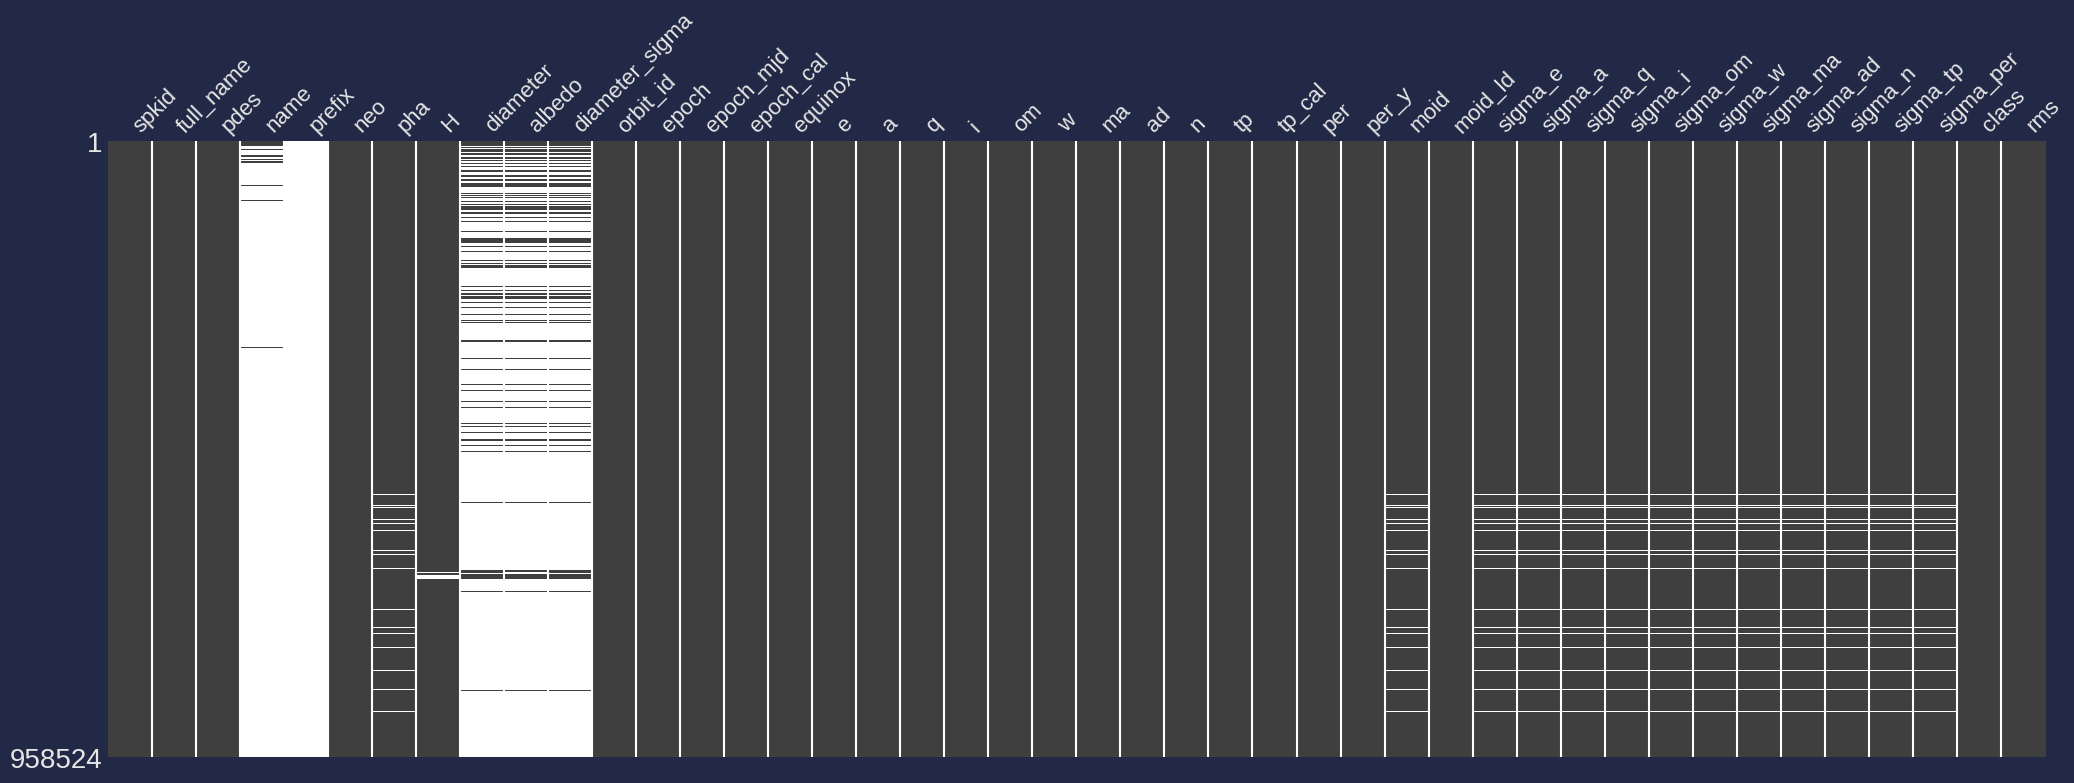

In [7]:
_, ax = plt.subplots(1, 1, figsize=(25, 8))
msno.matrix(df_asteroids, ax=ax);

In [8]:
cantidad = df_asteroids.isna().sum()
cantidad = cantidad[cantidad.values > 0]
porcentaje = cantidad * 100 / df_asteroids.shape[0]
df_nulls = pd.DataFrame(data={"Number of missing values":cantidad, "Percentage of missing values":porcentaje}, index=cantidad.index).sort_values(by=["Percentage of missing values"], ascending=False)
df_nulls

Number of missing values  Percentage of missing values
prefix                            958506                     99.998122
name                              936460                     97.698128
albedo                            823421                     85.905100
diameter_sigma                    822443                     85.803068
diameter                          822315                     85.789714
sigma_per                          19926                      2.078821
sigma_ad                           19926                      2.078821
sigma_i                            19922                      2.078404
sigma_q                            19922                      2.078404
sigma_a                            19922                      2.078404
sigma_e                            19922                      2.078404
sigma_n                            19922                      2.078404
sigma_ma                           19922                      2.078404
sigma_w                            19922                      2.078404
sigma_tp                           19922                      2.078404
sigma_om                           19922                      2.078404
moid                               19921                      2.078300
pha                                19921                      2.078300
H                                   6263                      0.653400
moid_ld                              127                      0.013250
per                                    4                      0.000417
ad                                     4                      0.000417
neo                                    4                      0.000417
rms                                    2                      0.000209
per_y                                  1                      0.000104
ma                                     1                      0.000104

Our `target` is `pha`, and as we can see, it has missing values. Fortunately, they only represent 2.07% of the total data.  
Without `target` values, these records are not useful for prediction.  
Let's take a look at them:  




In [9]:
df_asteroids[df_asteroids["pha"].isna()]

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


spkid           full_name       pdes name prefix neo  pha      H  \
id                                                                              
bJ39R00R   3246903           (1939 RR)    1939 RR  NaN    NaN   N  NaN  12.00   
bJ90O05K   3803913          (1990 OK5)   1990 OK5  NaN    NaN   N  NaN  16.40   
bJ91R28N   3884244         (1991 RN28)  1991 RN28  NaN    NaN   N  NaN  19.20   
bJ93T11C   3884246         (1993 TC11)  1993 TC11  NaN    NaN   N  NaN  19.30   
bJ94A09F   3884247          (1994 AF9)   1994 AF9  NaN    NaN   N  NaN  18.50   
...            ...                 ...        ...  ...    ...  ..  ...    ...   
bK20K03Q  54017210          (2020 KQ3)   2020 KQ3  NaN    NaN   N  NaN  19.90   
bK20K03R  54017211          (2020 KR3)   2020 KR3  NaN    NaN   N  NaN  19.40   
bK20K03V  54017212          (2020 KV3)   2020 KV3  NaN    NaN   N  NaN  19.91   
bK20K04A  54017209          (2020 KA4)   2020 KA4  NaN    NaN   N  NaN  18.50   
bK20K04C  54017222          (2020 KC4)   2020 KC4  NaN    NaN   N  NaN  21.70   

          diameter  albedo  diameter_sigma   orbit_id      epoch  epoch_mjd  \
id                                                                            
bJ39R00R       NaN     NaN             NaN   MPC06878  2429540.5      29540   
bJ90O05K       NaN     NaN             NaN   E2018H56  2458200.5      58200   
bJ91R28N       NaN     NaN             NaN  E2019-UR1  2458600.5      58600   
bJ93T11C       NaN     NaN             NaN  E2019-UR1  2458600.5      58600   
bJ94A09F       NaN     NaN             NaN  E2019-UR1  2458600.5      58600   
...            ...     ...             ...        ...        ...        ...   
bK20K03Q       NaN     NaN             NaN  E2020-KF3  2458980.5      58980   
bK20K03R       NaN     NaN             NaN  E2020-KF3  2458980.5      58980   
bK20K03V       NaN     NaN             NaN  E2020-KF3  2458989.5      58989   
bK20K04A       NaN     NaN             NaN  E2020-KF3  2458980.5      58980   
bK20K04C       NaN     NaN             NaN  E2020-KG3  2458983.5      58983   

           epoch_cal equinox         e         a         q         i  \
id                                                                     
bJ39R00R  19391004.0   J2000  0.253684  2.904675  2.167804  13.13929   
bJ90O05K  20180323.0   J2000  0.048582  3.167181  3.013314  16.48233   
bJ91R28N  20190427.0   J2000  0.233075  2.245953  1.722478   6.20213   
bJ93T11C  20190427.0   J2000  0.353036  2.585657  1.672827   6.31091   
bJ94A09F  20190427.0   J2000  0.130933  2.290446  1.990551   2.31549   
...              ...     ...       ...       ...       ...       ...   
bK20K03Q  20200511.0   J2000  0.190999  1.830298  1.480712  21.40511   
bK20K03R  20200511.0   J2000  0.061128  1.804802  1.694479  24.93236   
bK20K03V  20200520.0   J2000  0.095684  1.855324  1.677798  23.96564   
bK20K04A  20200511.0   J2000  0.387112  2.647610  1.622689  42.19332   
bK20K04C  20200514.0   J2000  0.413199  2.656652  1.558925   8.73332   

                 om          w         ma        ad         n            tp  \
id                                                                            
bJ39R00R  322.99733   64.83753  324.19341  3.641545  0.199094  2.429720e+06   
bJ90O05K  149.24058   82.29764   16.33585  3.321047  0.174862  2.458107e+06   
bJ91R28N  152.94720  205.86183   67.44659  2.769427  0.292822  2.458370e+06   
bJ93T11C   13.48929   37.29188   38.53043  3.498486  0.237054  2.458438e+06   
bJ94A09F  288.84566  155.70348  131.37613  2.590340  0.284331  2.458138e+06   
...             ...        ...        ...       ...       ...           ...   
bK20K03Q  221.92604  268.54669   91.47042  2.179884  0.398035  2.458751e+06   
bK20K03R  102.72236  344.28217  139.68895  1.915125  0.406499  2.458637e+06   
bK20K03V   92.99596  245.91250  264.52310  2.032849  0.390009  2.459234e+06   
bK20K04A  235.44532  352.56750  354.47736  3.672531  0.228783  2.459005e+06   
bK20K04C   41.22403  201.33779  355.50905  3.7

Apparently, these records contain many other columns with missing data, so it will be beneficial to discard them.

In [10]:
df_asteroids = df_asteroids[~df_asteroids["pha"].isna()]
cantidad = df_asteroids.isna().sum()
cantidad = cantidad[cantidad.values > 0]
porcentaje = cantidad * 100 / df_asteroids.shape[0]
df_nulls = pd.DataFrame(data={"Number of missing values":cantidad, "Percentage of missing values":porcentaje}, index=cantidad.index).sort_values(by=["Percentage of missing values"], ascending=False)
df_nulls

Number of missing values  Percentage of missing values
prefix                            938585                     99.998082
name                              916539                     97.649272
albedo                            803500                     85.605948
diameter_sigma                    802522                     85.501751
diameter                          802394                     85.488114
H                                   6262                      0.667162
sigma_per                              5                      0.000533
sigma_ad                               5                      0.000533
neo                                    4                      0.000426
ad                                     4                      0.000426
per                                    4                      0.000426
sigma_w                                1                      0.000107
sigma_tp                               1                      0.000107
sigma_n                                1                      0.000107
sigma_ma                               1                      0.000107
sigma_e                                1                      0.000107
sigma_om                               1                      0.000107
sigma_i                                1                      0.000107
sigma_q                                1                      0.000107
sigma_a                                1                      0.000107
per_y                                  1                      0.000107
ma                                     1                      0.000107
rms                                    1                      0.000107

As we can see, the percentage of missing values in many `features` has significantly decreased.  
I will consider that `features` with a missing value percentage greater than 3% can be discarded.  


In [11]:
columns_nan = df_nulls[df_nulls["Percentage of missing values"] > 3].index
df_nulls[df_nulls["Percentage of missing values"] > 3]

Number of missing values  Percentage of missing values
prefix                            938585                     99.998082
name                              916539                     97.649272
albedo                            803500                     85.605948
diameter_sigma                    802522                     85.501751
diameter                          802394                     85.488114

These features will be discarded due to their abundant amount of missing values.  

In [12]:
df_asteroids.drop(columns_nan, axis=1, inplace=True)
df_asteroids.head()

spkid       full_name pdes neo pha     H orbit_id      epoch  \
id                                                                         
a0000001  2000001         1 Ceres    1   N   N  3.40   JPL 47  2458600.5   
a0000002  2000002        2 Pallas    2   N   N  4.20   JPL 37  2459000.5   
a0000003  2000003          3 Juno    3   N   N  5.33  JPL 112  2459000.5   
a0000004  2000004         4 Vesta    4   N   N  3.00   JPL 35  2458600.5   
a0000005  2000005       5 Astraea    5   N   N  6.90  JPL 114  2459000.5   

          epoch_mjd   epoch_cal equinox         e         a         q  \
id                                                                      
a0000001      58600  20190427.0   J2000  0.076009  2.769165  2.558684   
a0000002      59000  20200531.0   J2000  0.229972  2.773841  2.135935   
a0000003      59000  20200531.0   J2000  0.256936  2.668285  1.982706   
a0000004      58600  20190427.0   J2000  0.088721  2.361418  2.151909   
a0000005      59000  20200531.0   J2000  0.190913  2.574037  2.082619   

                  i          om           w          ma        ad         n  \
id                                                                            
a0000001  10.594067   80.305531   73.597695   77.372098  2.979647  0.213885   
a0000002  34.832932  173.024741  310.202392  144.975675  3.411748  0.213345   
a0000003  12.991043  169.851482  248.066193  125.435355  3.353865  0.226129   
a0000004   7.141771  103.810804  150.728541   95.861938  2.570926  0.271609   
a0000005   5.367427  141.571026  358.648418   17.846343  3.065455  0.238661   

                    tp        tp_cal          per     per_y     moid  \
id                                                                     
a0000001  2.458239e+06  2.018043e+07  1683.145703  4.608202  1.59478   
a0000002  2.458321e+06  2.018072e+07  1687.410992  4.619880  1.23429   
a0000003  2.458446e+06  2.018112e+07  1592.013769  4.358696  1.03429   
a0000004  2.458248e+06  2.018051e+07  1325.432763  3.628837  1.13948   
a0000005  2.458926e+06  2.020032e+07  1508.414421  4.129814  1.09575   

             moid_ld       sigma_e       sigma_a       sigma_q       sigma_i  \
id                                                                             
a0000001  620.640533  4.819000e-12  1.032800e-11  1.956900e-11  4.608900e-09   
a0000002  480.348639  3.193400e-08  4.033700e-09  8.832200e-08  3.469400e-06   
a0000003  402.514639  3.052000e-08  3.471800e-09  8.139200e-08  3.223100e-06   
a0000004  443.451432  2.332100e-10  1.514300e-09  1.928600e-09  2.170600e-07   
a0000005  426.433027  2.373700e-08  3.970900e-09  6.092400e-08  2.740800e-06   

              sigma_om       sigma_w      sigma_ma      sigma_ad  \
id                                                                 
a0000001  6.168800e-08  6.624800e-08  7.820700e-09  1.111300e-11   
a0000002  6.272400e-06  9.128200e-06  8.859100e-06  4.961300e-09   
a0000003  1.664600e-05  1.772100e-05  8.110400e-06  4.363900e-09   
a0000004  3.880800e-07  1.789300e-07  1.206800e-06  1.648600e-09   
a0000005  2.894900e-05  2.984200e-05  8.303800e-06  4.729000e-09   

               sigma_n      sigma_tp     sigma_per class      rms  
id                                                                 
a0000001  1.196500e-12  3.782900e-08  9.415900e-09   MBA  0.43301  
a0000002  4.653600e-10  4.078700e-05  3.680700e-06   MBA  0.35936  
a0000003  4.413400e-10  3.528800e-05  3.107200e-06   MBA  0.33848  
a0000004  2.612500e-10  4.103700e-06  1.274900e-06   MBA  0.39980  
a0000005  5.522700e-10  3.474300e-05  3.490500e-06   MBA  0.52191

/usr/local/lib/python3.10/dist-packages/missingno/missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


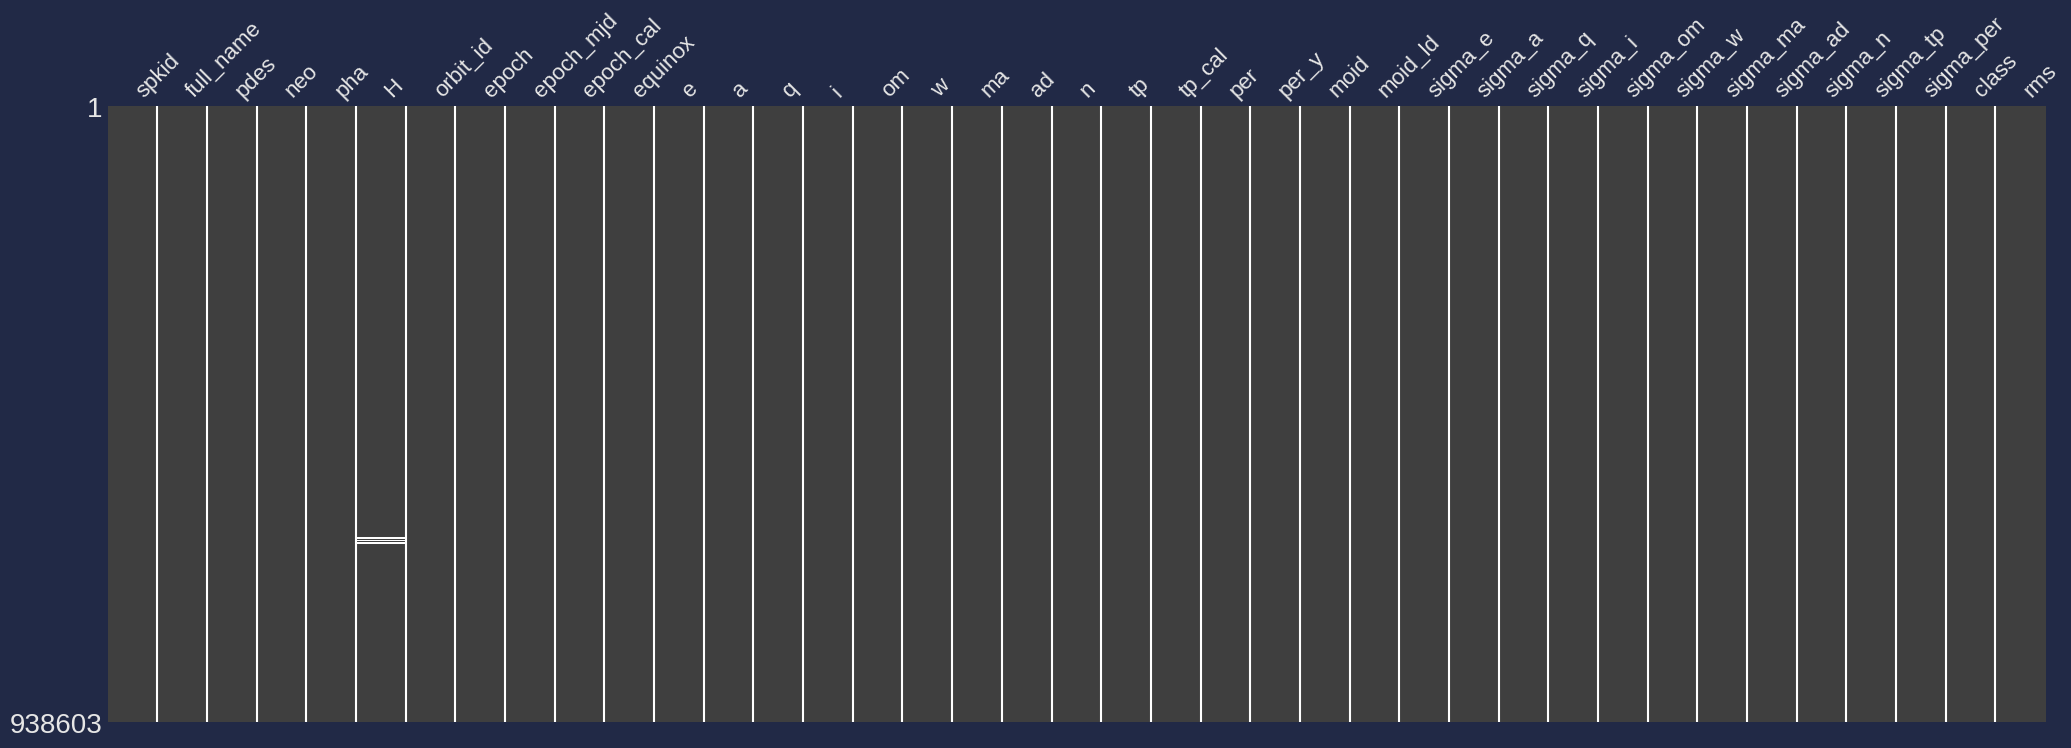

In [13]:
_, ax = plt.subplots(1, 1, figsize=(25, 8))
msno.matrix(df_asteroids, ax=ax);

Once the `features` with the highest amount of missing data have been discarded, let's proceed to explore the dataset.

# Outliers detection

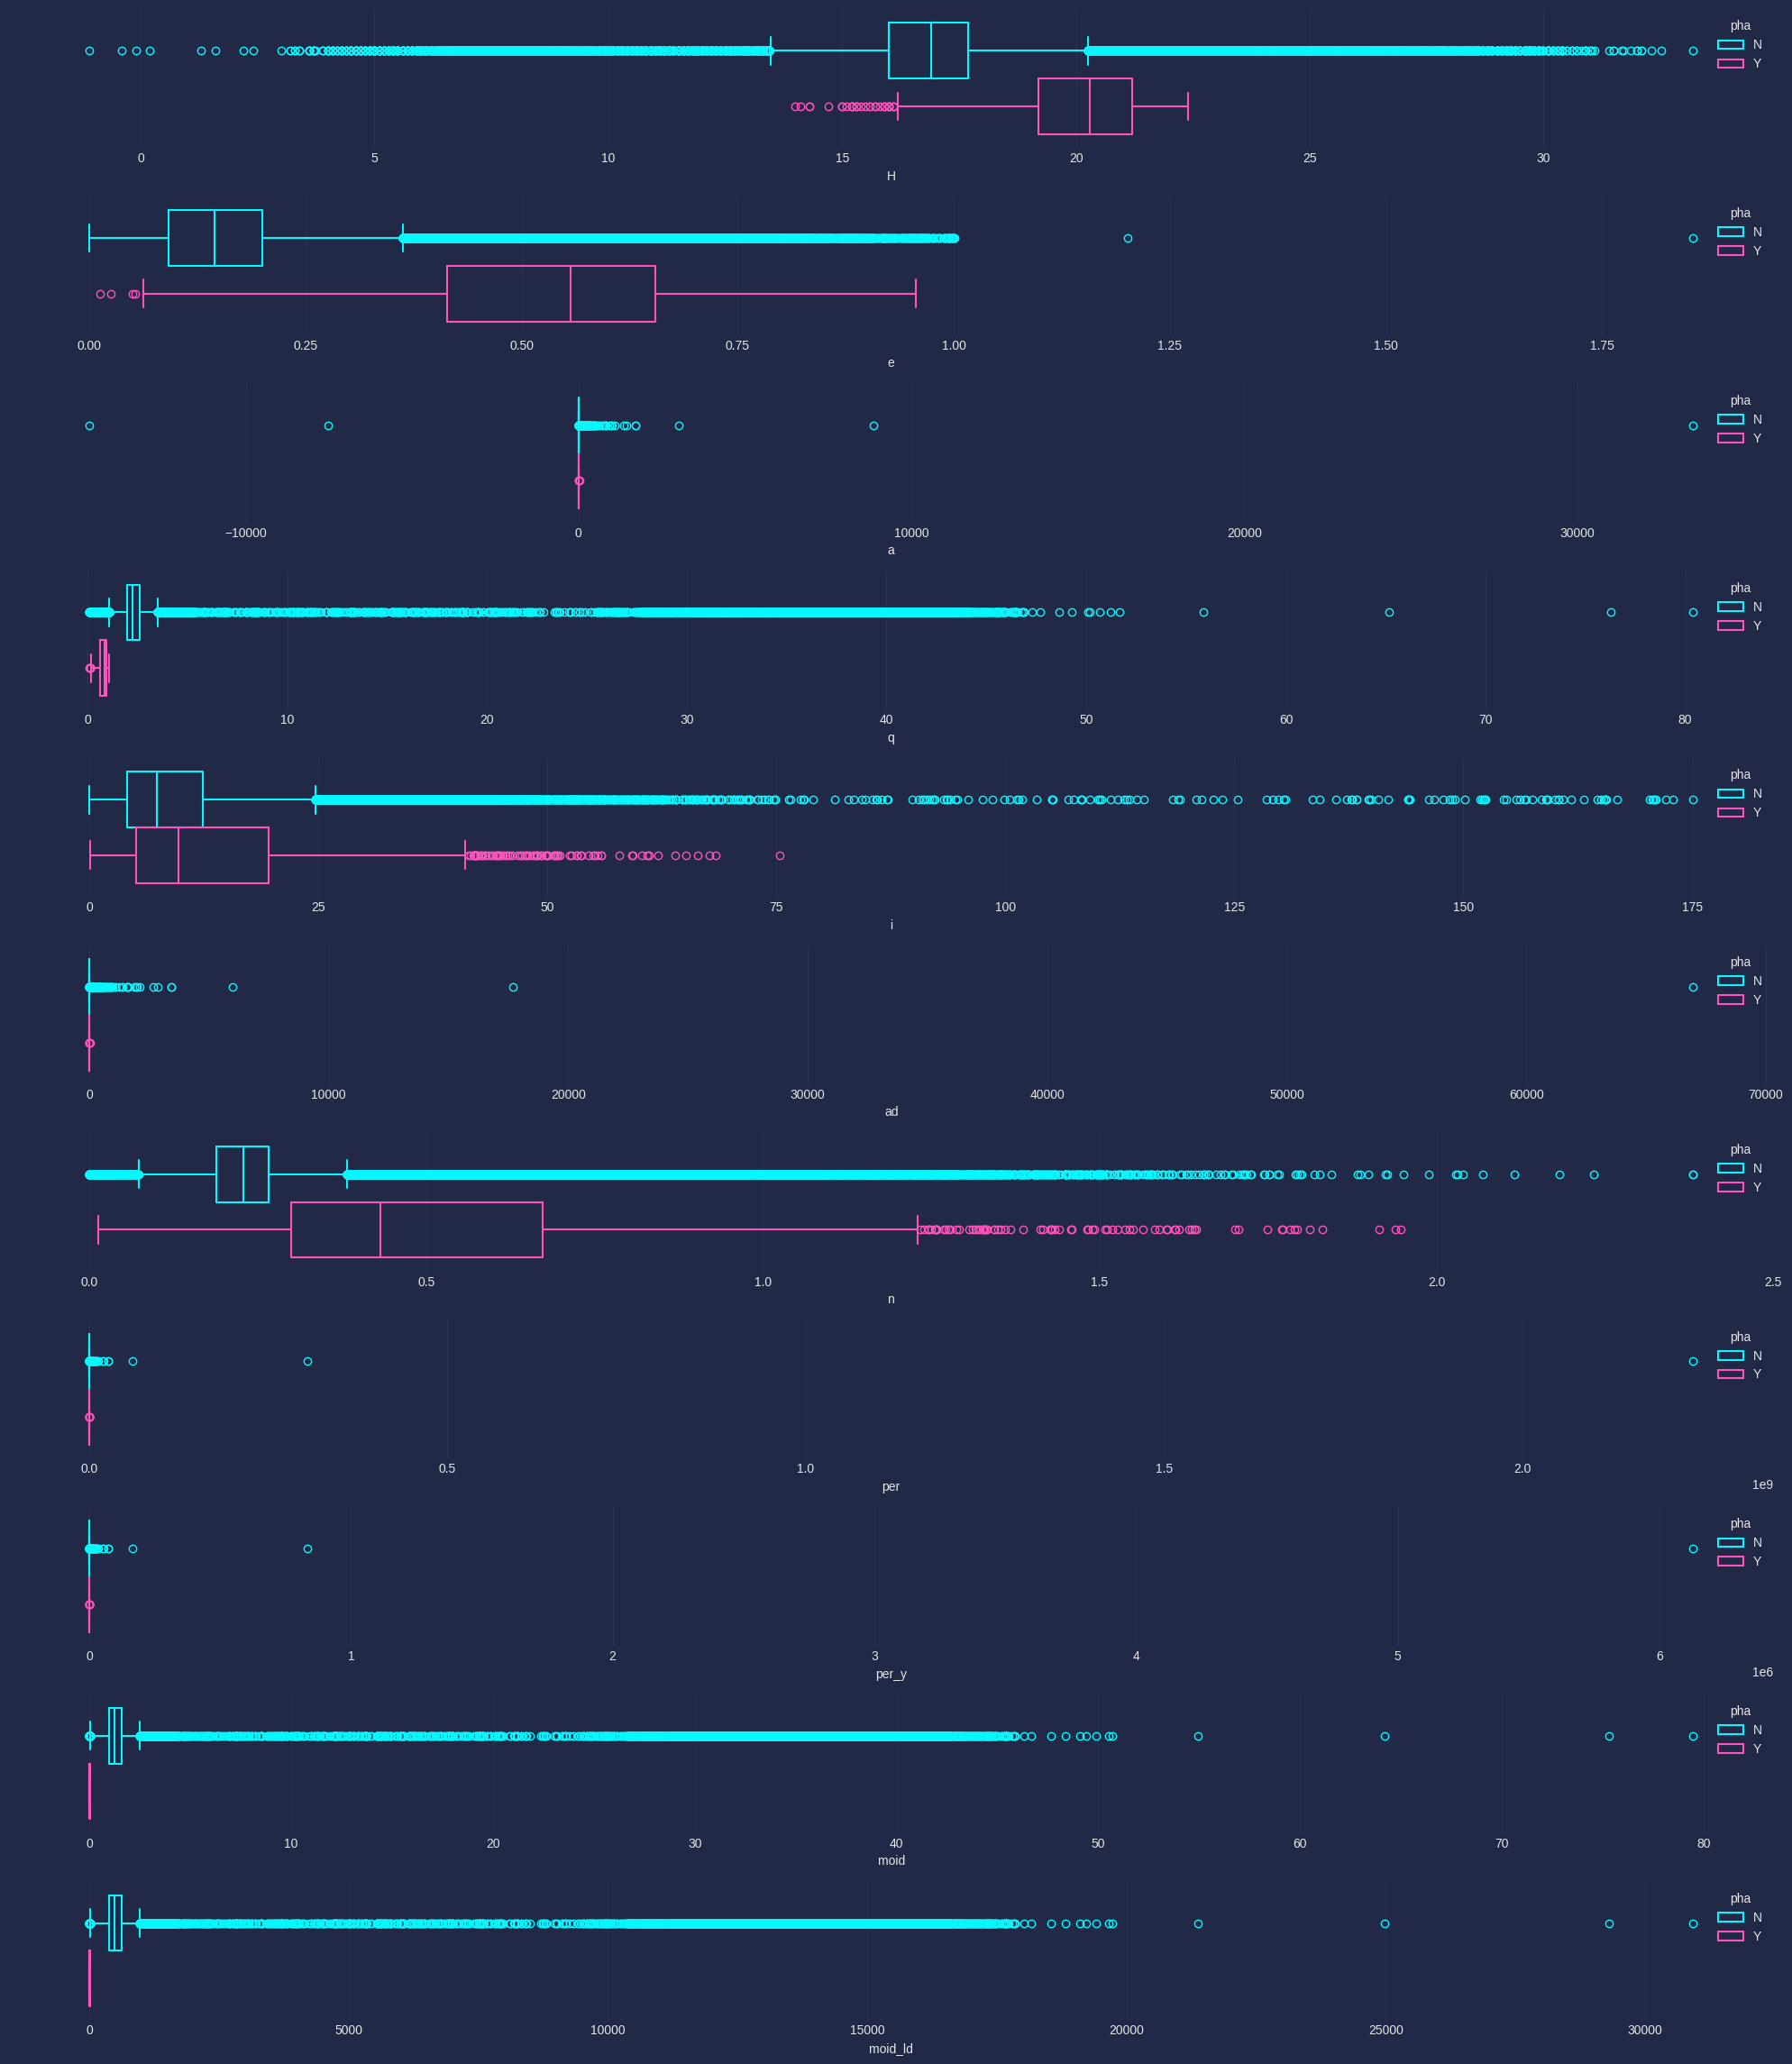

In [14]:
columns_numerics = ["H", "e", "a", "q", "i", "ad", "n", "per", "per_y", "moid", "moid_ld"]

fig = plt.figure(figsize=(20, 25))
axs = fig.subplots(len(columns_numerics), 1)
for i, col in enumerate(columns_numerics):
    sns.boxplot(data=df_asteroids, x=col, ax=axs[i], hue="pha", fill=False)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [15]:
df_asteroids[columns_numerics].describe().transpose()

count         mean           std           min          25%  \
H        932341.0    16.889969  1.801386e+00 -1.100000e+00    16.000000   
e        938603.0     0.156146  9.300582e-02  0.000000e+00     0.092064   
a        938603.0     2.906752  4.013775e+01 -1.470245e+04     2.388114   
q        938603.0     2.397725  2.159374e+00  7.051073e-02     1.971656   
i        938603.0     9.048065  6.646721e+00  7.744220e-03     4.154593   
ad       938599.0     3.463186  7.252509e+01  6.537730e-01     2.781941   
n        938603.0     0.236729  7.996385e-02  1.608247e-07     0.189435   
per      938599.0  5157.181148  2.333335e+06  1.511918e+02  1347.973542   
per_y    938602.0    14.119547  6.388312e+03  0.000000e+00     3.690548   
moid     938603.0     1.415162  2.156731e+00  4.544120e-07     0.979702   
moid_ld  938603.0   550.738745  8.393348e+02  1.768435e-04   381.270627   

                 50%          75%           max  
H          16.900000    17.700000  3.320000e+01  
e           0.144865     0.200598  1.855356e+00  
a           2.647342     3.002579  3.348890e+04  
q           2.226687     2.579723  8.039882e+01  
i           7.404507    12.398180  1.750829e+02  
ad          3.047348     3.365392  6.697280e+04  
n           0.228817     0.267068  2.381082e+00  
per      1573.310707  1900.379371  2.238462e+09  
per_y       4.307484     5.202952  6.128574e+06  
moid        1.240850     1.593370  7.947660e+01  
moid_ld   482.901594   620.091803  3.092991e+04

In [16]:
old_len = len(df_asteroids)
df_asteroids.pha.value_counts()

pha
N    936537
Y      2066
Name: count, dtype: int64

As we can see in our data, we have many extreme outliers. These will pose a problem for the training of our models. Let's see how we can handle them.  

In [17]:
def get_outliers(df, col, tipo="leve"):
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  if tipo == "leve":
    k = 1.5
  else:
    k = 3
  return df[(df[col] >= Q3 + k*IQR) | (df[col] <= Q1 - k*IQR)]

def table_outliers(df, columns):
  df_outliers = pd.DataFrame(columns=["Feature", "Mild outliers", "Percentage of mild outliers", "Extreme outliers", "Percentage of extreme outliers", "PHA = Y", "PHA = N"])
  for col in columns:
    leves = get_outliers(df, col, tipo="leve")
    extremos = get_outliers(df, col, tipo="extremo")
    df_new = pd.DataFrame(data={"Feature":[col],
                                "Mild outliers":[len(leves)],
                                "Percentage of mild outliers": len(leves)*100 / len(df),
                                "Extreme outliers":[len(extremos)],
                                "Percentage of extreme outliers": len(extremos)*100 / len(df),
                                "PHA = Y": [len(extremos[extremos["pha"] == "Y"])],
                                "PHA = N": [len(extremos[extremos["pha"] == "N"])],
                                })
    df_outliers = pd.concat((df_outliers, df_new), axis=0, ignore_index = True)
  return df_outliers

table_outliers(df_asteroids, columns_numerics).sort_values(by=["PHA = Y", "PHA = N"], ascending=[True, False])

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
<ipython-input-17-38ba08b9ae9c>:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_outliers = pd.concat((df_outlie

Feature Mild outliers  Percentage of mild outliers Extreme outliers  \
0         H         39678                     4.227346            17160   
9      moid         24551                     2.615696            11465   
10  moid_ld         24551                     2.615696            11465   
7       per         22113                     2.355948            12221   
8     per_y         22116                     2.356268            12221   
2         a         24747                     2.636578            12186   
3         q         29274                     3.118891            11546   
5        ad         29694                     3.163638            13404   
4         i         29787                     3.173546             1625   
6         n         23985                     2.555393             9772   
1         e         24658                     2.627096             8761   

    Percentage of extreme outliers PHA = Y PHA = N  
0                         1.828249       0   17160  
9                         1.221496       0   11465  
10                        1.221496       0   11465  
7                         1.302041       1   12220  
8                         1.302041       1   12220  
2                         1.298312       1   12185  
3                         1.230126      12   11534  
5                         1.428080      55   13349  
4                         0.173130     114    1511  
6                         1.041122     851    8921  
1                         0.933408    1166    7595

We will address the variables with the highest number of extreme outliers. As we can see, these represent less than 2% of our dataset. With nearly 1M records, removing these outliers will not have a significant impact on our dataset. However, we must ensure not to unbalance our data too much, as we have few positive records of `pha`. According to the table above, we can see that the outliers in `H` are all negative cases of `pha`. Removing these data will also slightly help balance our target.

In [18]:
H_outliers = get_outliers(df_asteroids, "H", "extremos")
df_asteroids.drop(H_outliers.index, axis=0, inplace=True)
table_outliers(df_asteroids, ["e", "a", "q", "i", "ad", "n", "per", "per_y", "moid", "moid_ld"]).sort_values(by=["PHA = Y", "PHA = N"], ascending=[True, False])

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
<ipython-input-17-38ba08b9ae9c>:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_outliers = pd.concat((df_outliers, df_new), axis=0, ignore_index = True)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value en

Feature Mild outliers  Percentage of mild outliers Extreme outliers  \
8     moid         12605                     1.367963             7789   
9  moid_ld         12605                     1.367963             7789   
6      per         15052                     1.633525             8469   
7    per_y         15053                     1.633633             8469   
1        a         15875                     1.722841             8437   
2        q         15710                     1.704935             7870   
4       ad         21096                     2.289453             9686   
3        i         28817                     3.127377             1467   
5        n         13609                     1.476923             3616   
0        e         17665                     1.917102             5388   

   Percentage of extreme outliers PHA = Y PHA = N  
8                        0.845305       0    7789  
9                        0.845305       0    7789  
6                        0.919102       1    8468  
7                        0.919102       1    8468  
1                        0.915629       1    8436  
2                        0.854095      19    7851  
4                        1.051177      72    9614  
3                        0.159207     116    1351  
5                        0.392428     858    2758  
0                        0.584735    1194    4194

Alright, we handled the variable `H`, so we excluded it from the table. Now let's proceed with `moid`, as it does not have any positive values in the target.  

In [19]:
moid_outliers = get_outliers(df_asteroids, "moid", "extremos")
df_asteroids.drop(moid_outliers.index, axis=0, inplace=True)
table_outliers(df_asteroids, ["e", "a", "q", "i", "ad", "n", "per", "per_y"]).sort_values(by=["PHA = Y", "PHA = N"], ascending=[True, False])

<ipython-input-17-38ba08b9ae9c>:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_outliers = pd.concat((df_outliers, df_new), axis=0, ignore_index = True)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value en

Feature Mild outliers  Percentage of mild outliers Extreme outliers  \
6     per          7369                     0.806542              684   
7   per_y          7369                     0.806542              684   
1       a          8260                     0.904062              656   
2       q          8127                     0.889505              161   
4      ad         13843                     1.515125             2077   
3       i         28201                     3.086617             1415   
5       n         13700                     1.499474             3632   
0       e         17574                     1.923485             5339   

   Percentage of extreme outliers PHA = Y PHA = N  
6                        0.074864       1     683  
7                        0.074864       1     683  
1                        0.071800       1     655  
2                        0.017622      25     136  
4                        0.227329      87    1990  
3                        0.154873     118    1297  
5                        0.397525     860    2772  
0                        0.584357    1199    4140

Since `moid` and `moid_ld` represent the same values but with different scales and we have already addressed them, we can exclude them from the table. The next column to handle is `per`.  

In [20]:
per_outliers = get_outliers(df_asteroids, "per", "extremos")
df_asteroids.drop(per_outliers.index, axis=0, inplace=True)
table_outliers(df_asteroids, ["e", "a", "q", "i", "ad", "n"]).sort_values(by=["PHA = Y", "PHA = N"], ascending=[True, False])

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
<ipython-input-17-38ba08b9ae9c>:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_outliers = pd.concat((df_outliers, df_new), axis=0, ignore_index = True)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value en

Feature Mild outliers  Percentage of mild outliers Extreme outliers  \
1       a          7586                     0.830914                4   
2       q          7699                     0.843292               79   
4      ad         13212                     1.447145             1408   
3       i         28106                     3.078524             1288   
5       n         13496                     1.478252             3632   
0       e         17296                     1.894476             5141   

   Percentage of extreme outliers PHA = Y PHA = N  
1                        0.000438       0       4  
2                        0.008653      25      54  
4                        0.154222      89    1319  
3                        0.141078     118    1170  
5                        0.397822     860    2772  
0                        0.563107    1198    3943

Once again, we exclude `per` and `per_y` as they represent the same variable. Finally, we are left to process the variable `a`.

In [21]:
a_outliers = get_outliers(df_asteroids, "a", "extremos")
df_asteroids.drop(a_outliers.index, axis=0, inplace=True)
table_outliers(df_asteroids, ["e", "q", "i", "ad", "n"]).sort_values(by=["PHA = Y", "PHA = N"], ascending=[True, False])

<ipython-input-17-38ba08b9ae9c>:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_outliers = pd.concat((df_outliers, df_new), axis=0, ignore_index = True)


Feature Mild outliers  Percentage of mild outliers Extreme outliers  \
1       q          7695                     0.842857               78   
3      ad         13209                     1.446823             1405   
2       i         28105                     3.078428             1287   
4       n         13492                     1.477821             3628   
0       e         17293                     1.894156             5139   

   Percentage of extreme outliers PHA = Y PHA = N  
1                        0.008544      25      53  
3                        0.153894      89    1316  
2                        0.140969     118    1169  
4                        0.397386     860    2768  
0                        0.562891    1198    3941

I will not continue treating outliers on the remaining columns, as this would imply discarding some of the few positive records we have, which would be more harmful.  

In [22]:
print(f"A total of {old_len - len(df_asteroids)} records have been removed from the original {old_len} records. These records represent {round((old_len - len(df_asteroids))*100/old_len, 2)}% of our dataset.")

A total of 25637 records have been removed from the original 938603 records. These records represent 2.73% of our dataset.


## Uncertainty in measurements  
Our dataset contains features that indicate the uncertainty considered during the measurement of a given parameter. A high uncertainty implies a very low confidence in the measurements, and vice versa. To maintain reliable records, we can discard those records with high uncertainties.

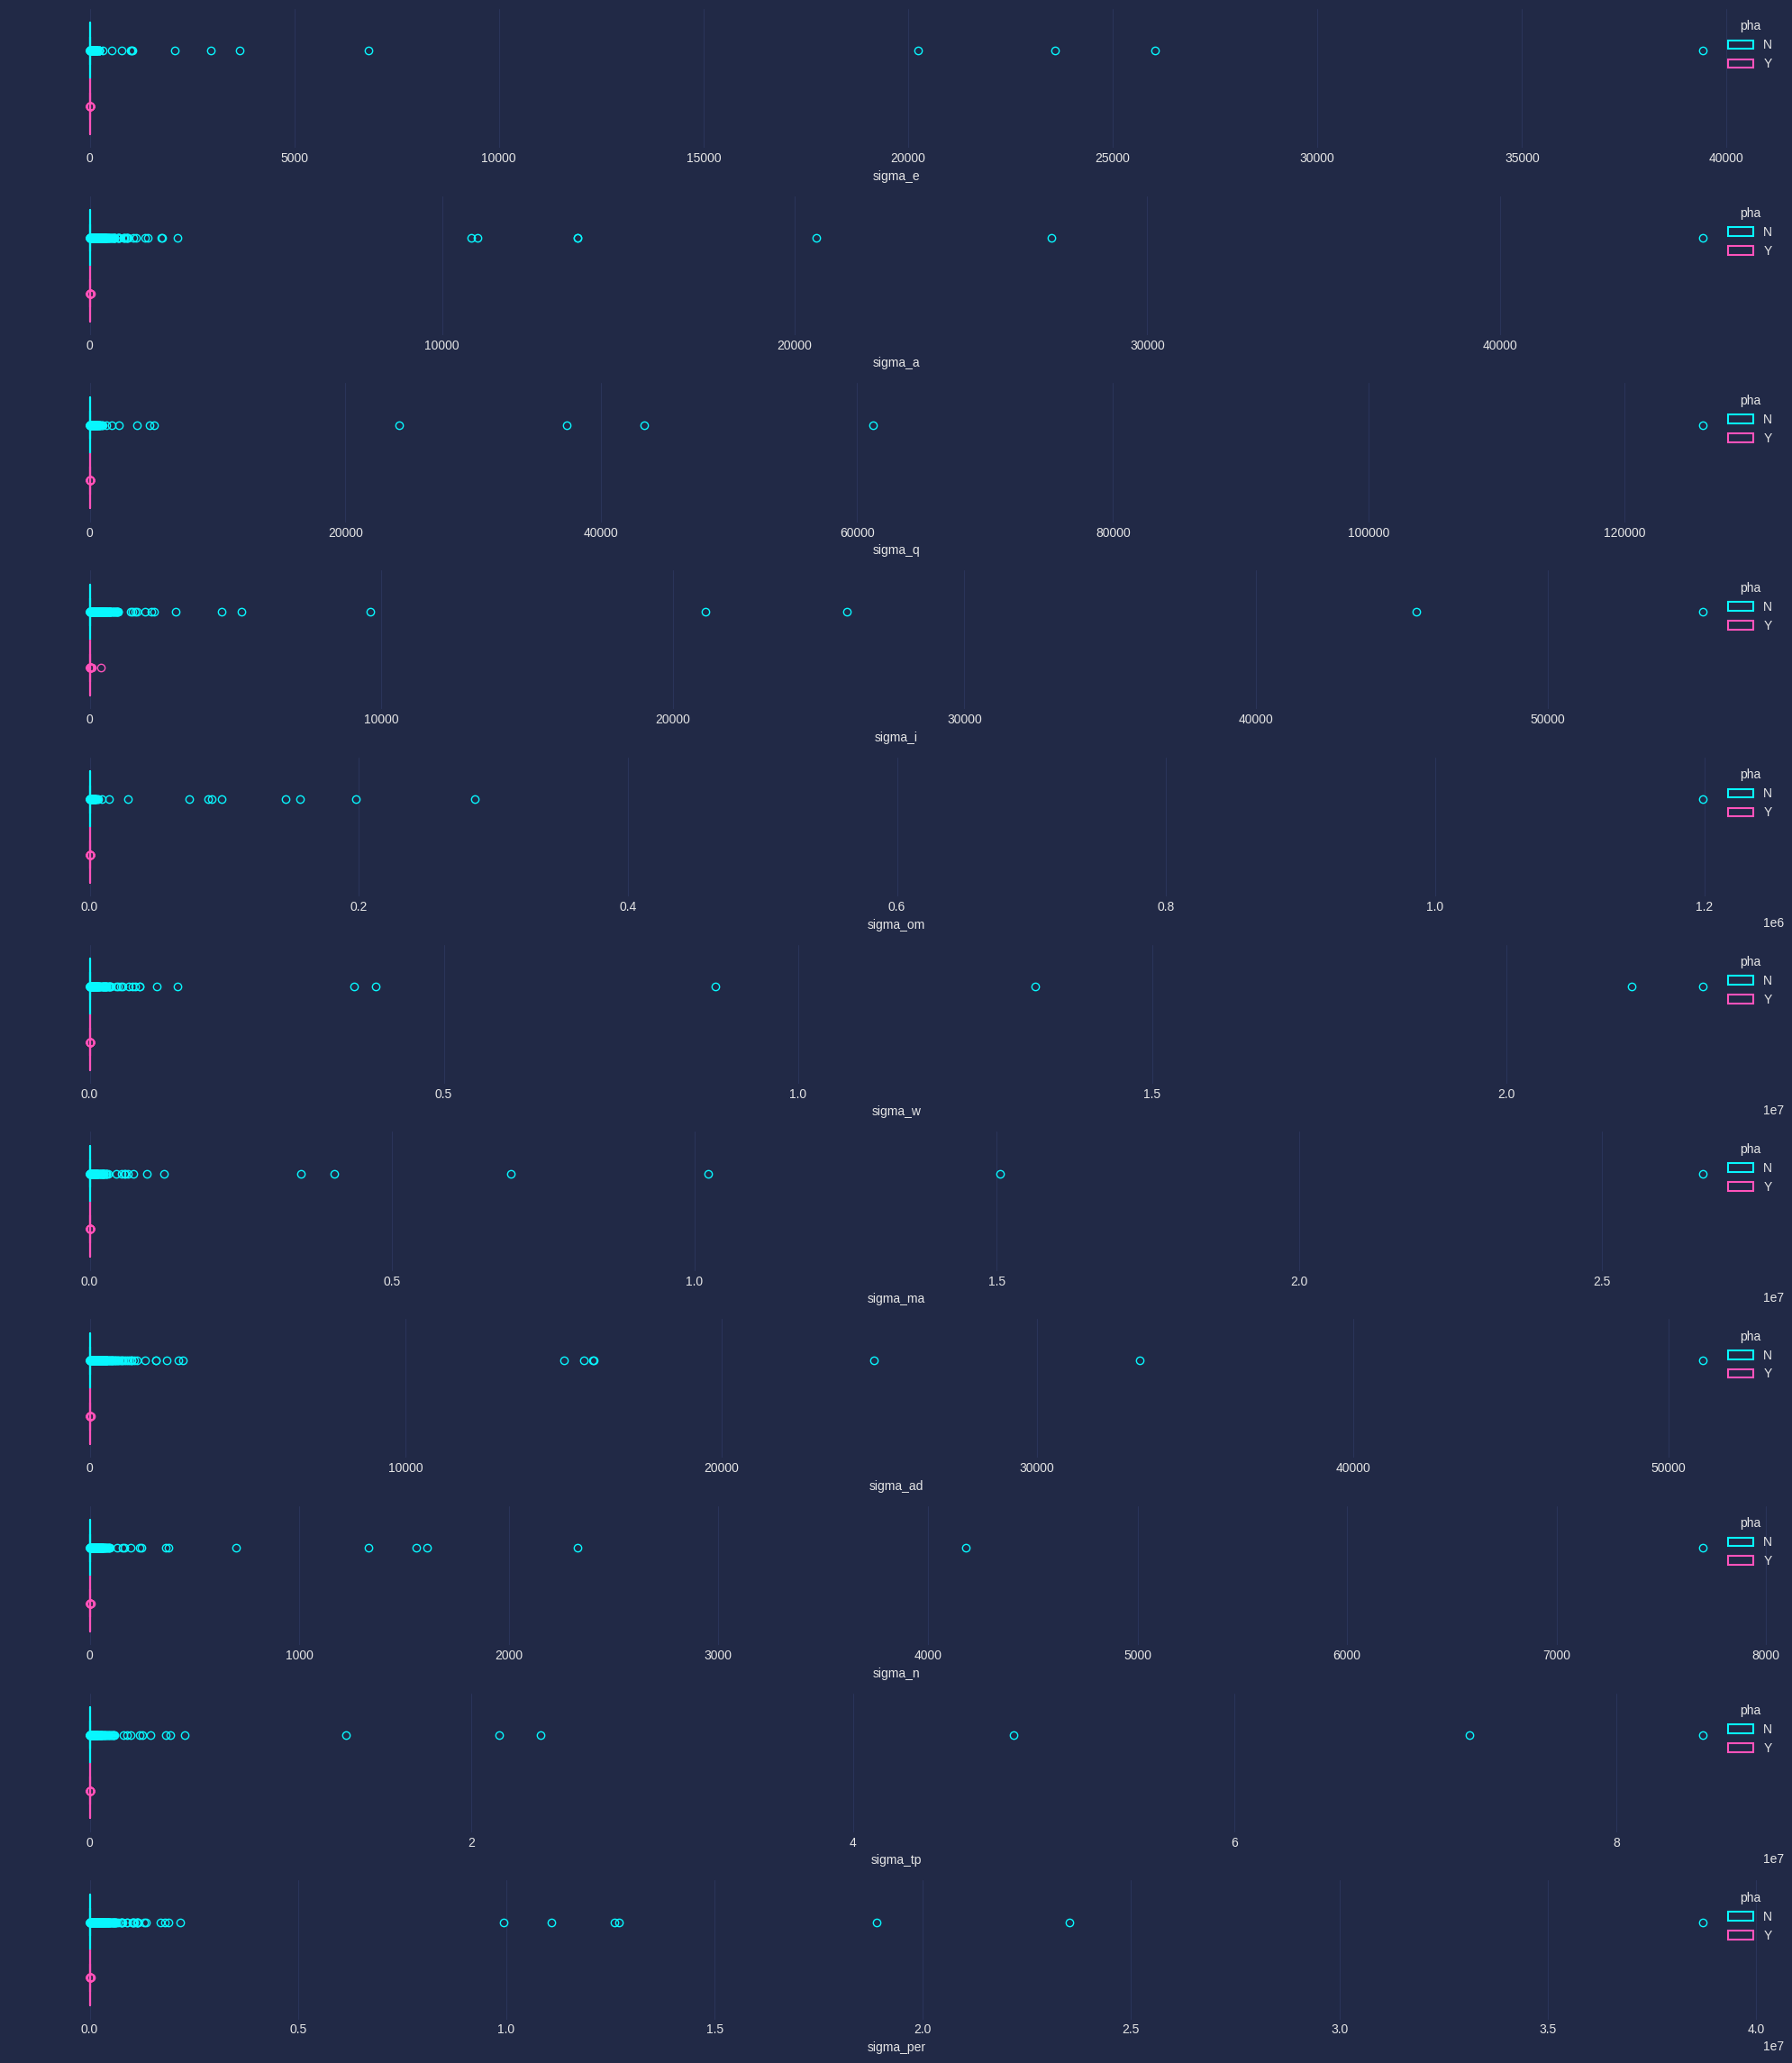

In [23]:
columns_sigma = ["sigma_e", "sigma_a", "sigma_q", "sigma_i", "sigma_om", "sigma_w", "sigma_ma", "sigma_ad", "sigma_n", "sigma_tp", "sigma_per"]

fig = plt.figure(figsize=(20, 25))
axs = fig.subplots(len(columns_sigma), 1)
for i, col in enumerate(columns_sigma):
  sns.boxplot(data=df_asteroids, x=col, ax=axs[i], hue="pha", fill=False)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [24]:
table_outliers(df_asteroids, columns_sigma).sort_values(by=["PHA = Y", "PHA = N"], ascending=[True, False])

<ipython-input-17-38ba08b9ae9c>:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_outliers = pd.concat((df_outliers, df_new), axis=0, ignore_index = True)


Feature Mild outliers  Percentage of mild outliers Extreme outliers  \
5     sigma_w        169703                    18.588096           151966   
4    sigma_om        133127                    14.581814           108035   
2     sigma_q        186220                    20.397255           172997   
9    sigma_tp        175296                    19.200715           159219   
6    sigma_ma        177963                    19.492840           162262   
10  sigma_per        171498                    18.784708           158174   
3     sigma_i        152375                    16.690107           133217   
1     sigma_a        172912                    18.939588           159599   
0     sigma_e        188276                    20.622455           175568   
7    sigma_ad        174106                    19.070371           160759   
8     sigma_n        178137                    19.511899           165385   

    Percentage of extreme outliers PHA = Y PHA = N  
5                        16.645308     328  151638  
4                        11.833409     367  107668  
2                        18.948898     444  172553  
9                        17.439751     481  158738  
6                        17.773061     566  161696  
10                       17.325289     606  157568  
3                        14.591672     617  132600  
1                        17.481374     628  158971  
0                        19.230508     635  174933  
7                        17.608432     652  160107  
8                        18.115132     802  164583

In [25]:
sigw_outliers = get_outliers(df_asteroids, "sigma_w", "extremos")
df_asteroids.drop(sigw_outliers.index, axis=0, inplace=True)
columns_sigma.remove("sigma_w")
table_outliers(df_asteroids, columns_sigma).sort_values(by=["PHA = Y", "PHA = N"], ascending=[True, False])

<ipython-input-17-38ba08b9ae9c>:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_outliers = pd.concat((df_outliers, df_new), axis=0, ignore_index = True)


Feature Mild outliers  Percentage of mild outliers Extreme outliers  \
4   sigma_om         65317                     8.583049            29657   
8   sigma_tp         79213                    10.409067            47108   
2    sigma_q         82686                    10.865440            56256   
9  sigma_per         64615                     8.490802            38907   
5   sigma_ma         81203                    10.670565            50174   
1    sigma_a         64868                     8.524047            39642   
6   sigma_ad         66274                     8.708804            41100   
0    sigma_e         85925                    11.291064            59611   
3    sigma_i         53623                     7.046386            25237   
7    sigma_n         67878                     8.919580            43889   

   Percentage of extreme outliers PHA = Y PHA = N  
4                        3.897109     114   29543  
8                        6.190276     226   46882  
2                        7.392378     253   56003  
9                        5.112615     345   38562  
5                        6.593167     353   49821  
1                        5.209198     377   39265  
6                        5.400788     436   40664  
0                        7.833246     478   59133  
3                        3.316294     524   24713  
7                        5.767280     640   43249

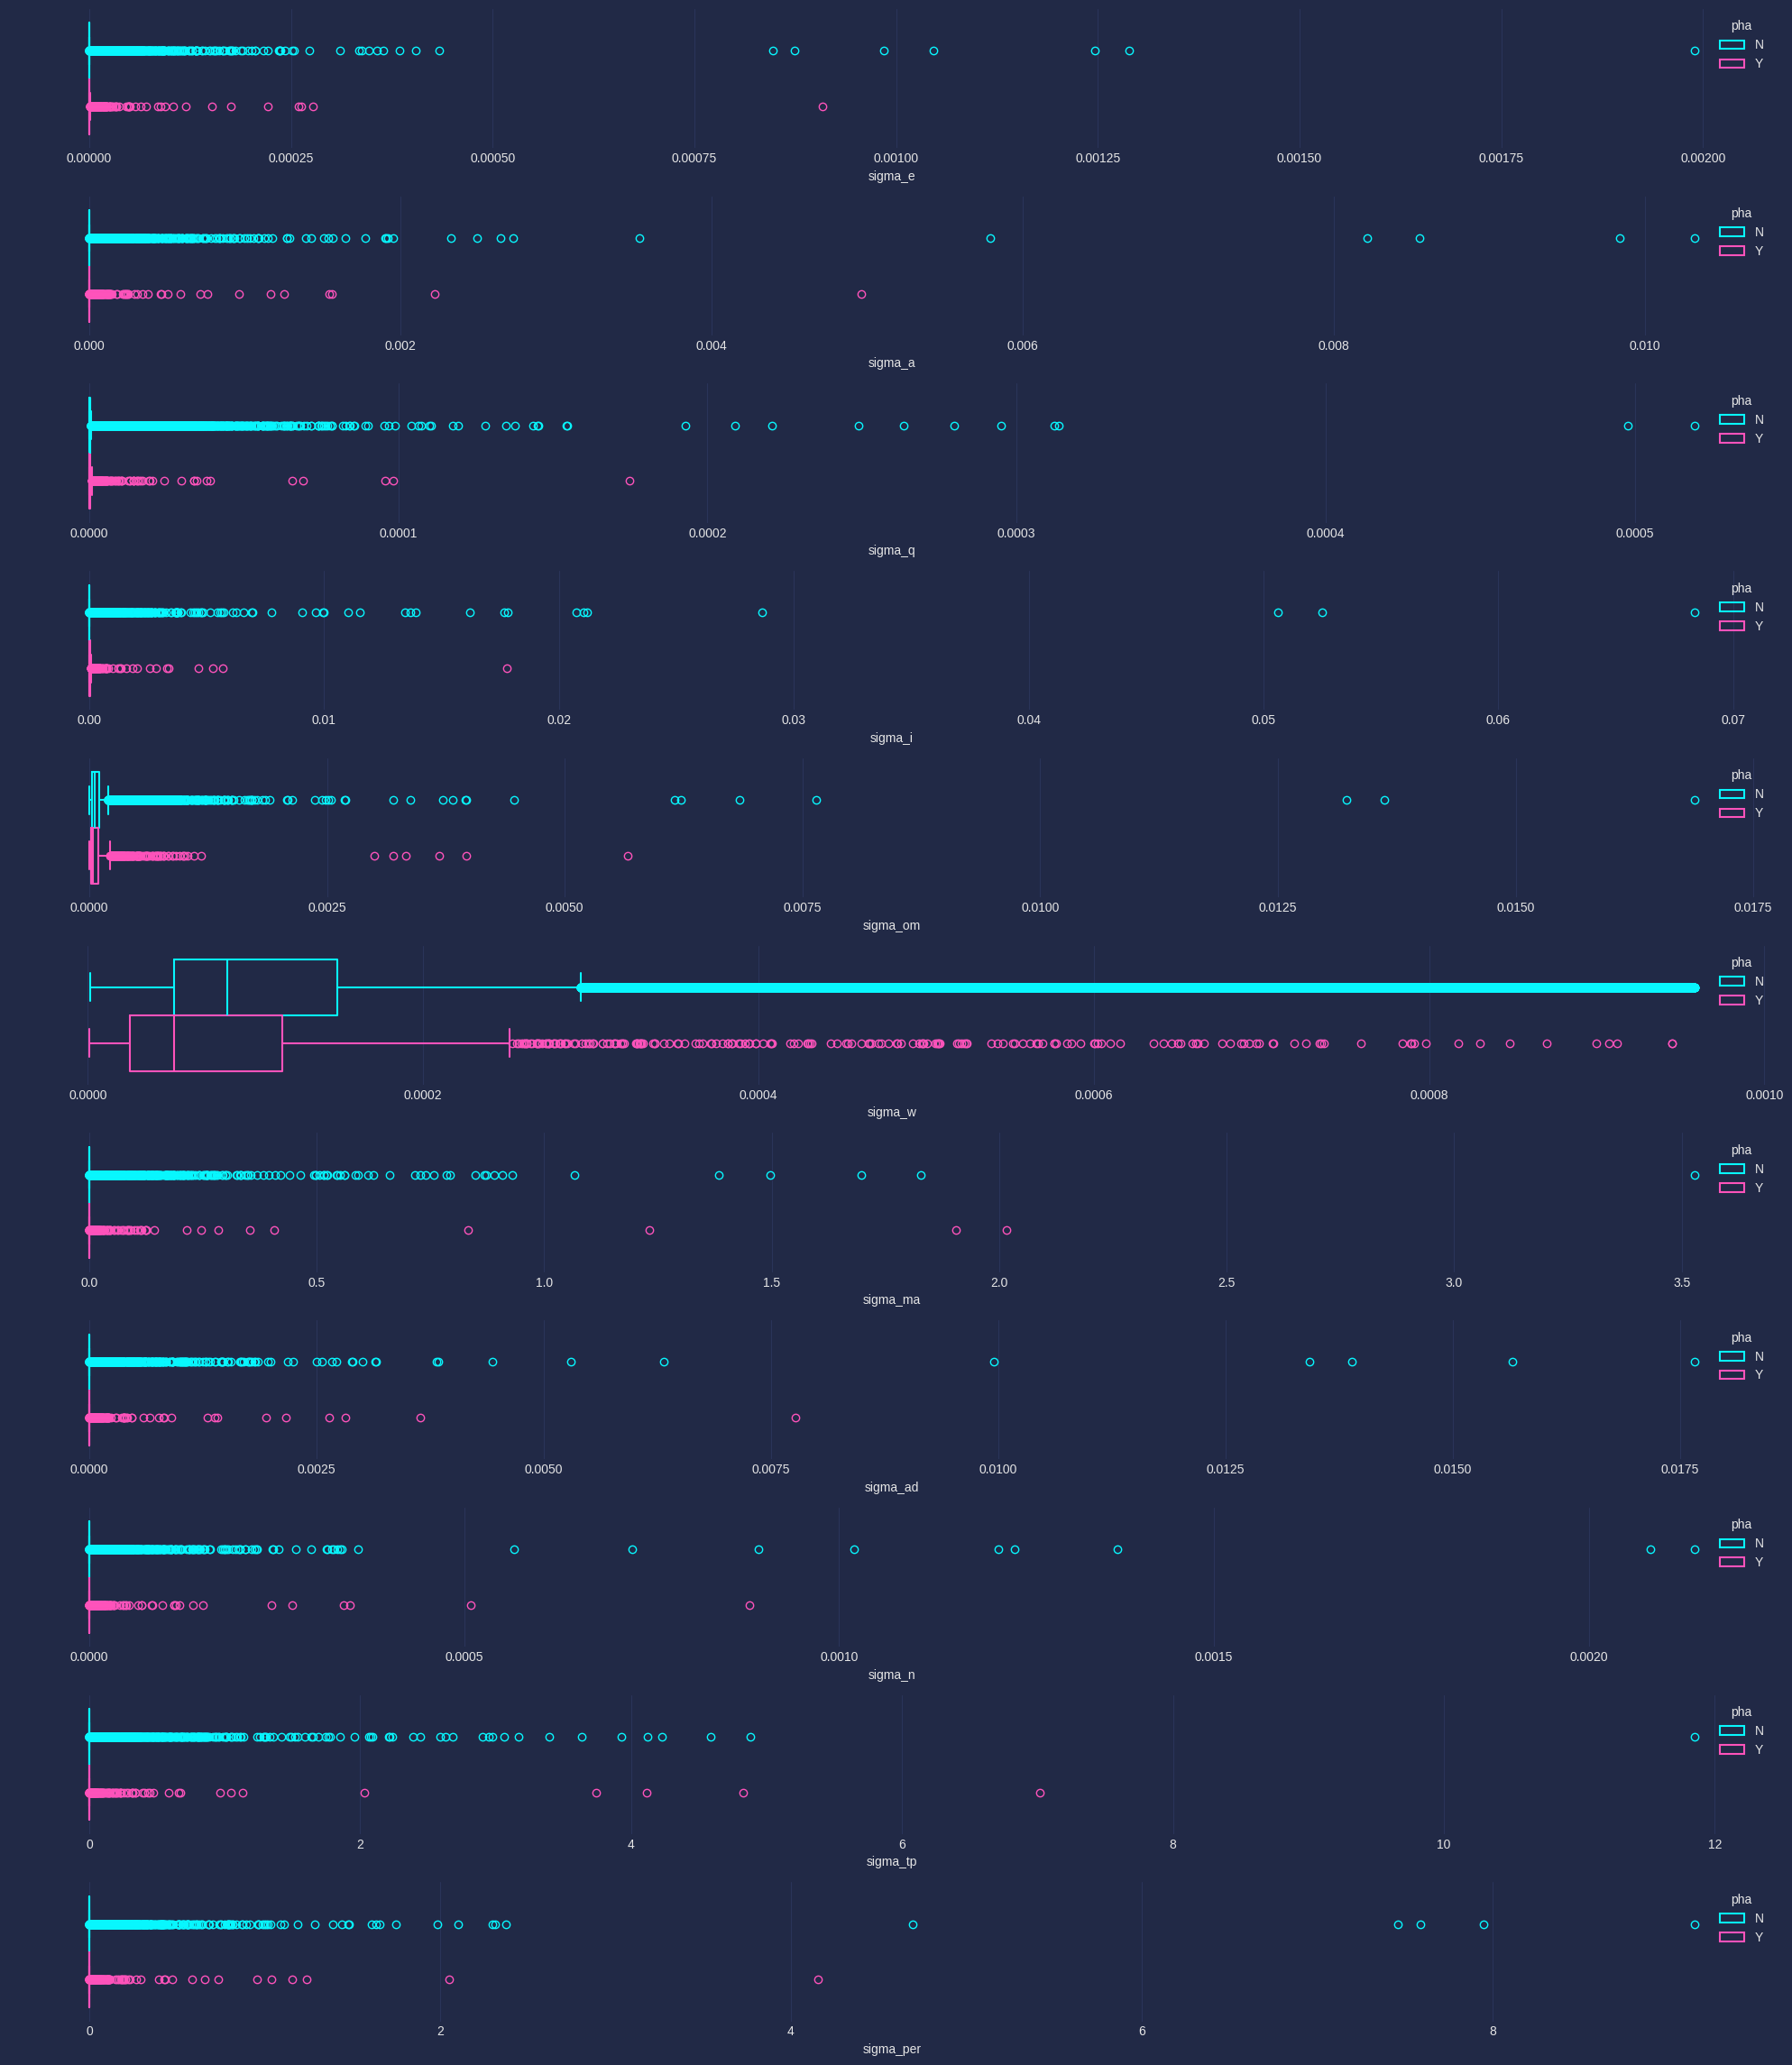

In [26]:
columns_sigma = ["sigma_e", "sigma_a", "sigma_q", "sigma_i", "sigma_om", "sigma_w", "sigma_ma", "sigma_ad", "sigma_n", "sigma_tp", "sigma_per"]

fig = plt.figure(figsize=(20, 25))
axs = fig.subplots(len(columns_sigma), 1)
for i, col in enumerate(columns_sigma):
  sns.boxplot(data=df_asteroids, x=col, ax=axs[i], hue="pha", fill=False)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [27]:
print(f"A total of {old_len - len(df_asteroids)} records have been removed from the original {old_len} records. These records represent {round((old_len - len(df_asteroids))*100/old_len, 2)}% of our dataset.")

A total of 177603 records have been removed from the original 938603 records. These records represent 18.92% of our dataset.


In [28]:
gc.collect()

87852

# Replacing missing data

/usr/local/lib/python3.10/dist-packages/missingno/missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


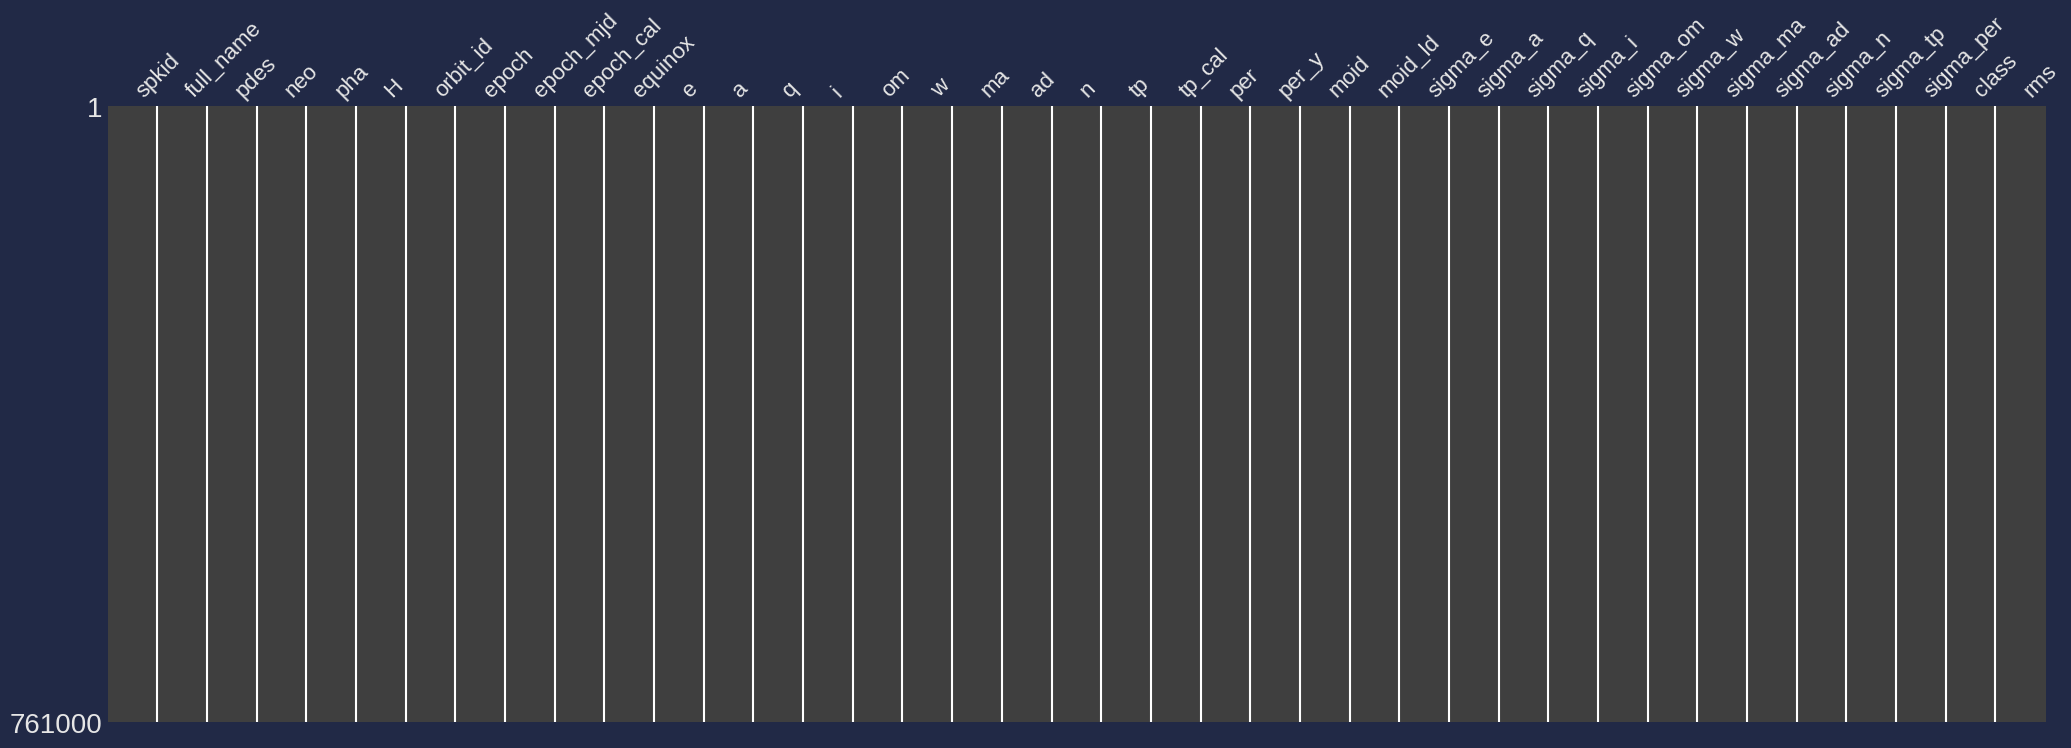

In [29]:
_, ax = plt.subplots(1, 1, figsize=(25, 8))
msno.matrix(df_asteroids, ax=ax);

In [30]:
df_asteroids.isna().sum()

spkid        0
full_name    0
pdes         0
neo          0
pha          0
H            0
orbit_id     0
epoch        0
epoch_mjd    0
epoch_cal    0
equinox      0
e            0
a            0
q            0
i            0
om           0
w            0
ma           0
ad           0
n            0
tp           0
tp_cal       0
per          0
per_y        0
moid         0
moid_ld      0
sigma_e      0
sigma_a      0
sigma_q      0
sigma_i      0
sigma_om     0
sigma_w      0
sigma_ma     0
sigma_ad     0
sigma_n      0
sigma_tp     0
sigma_per    0
class        0
rms          0
dtype: int64

/usr/local/lib/python3.10/dist-packages/missingno/missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


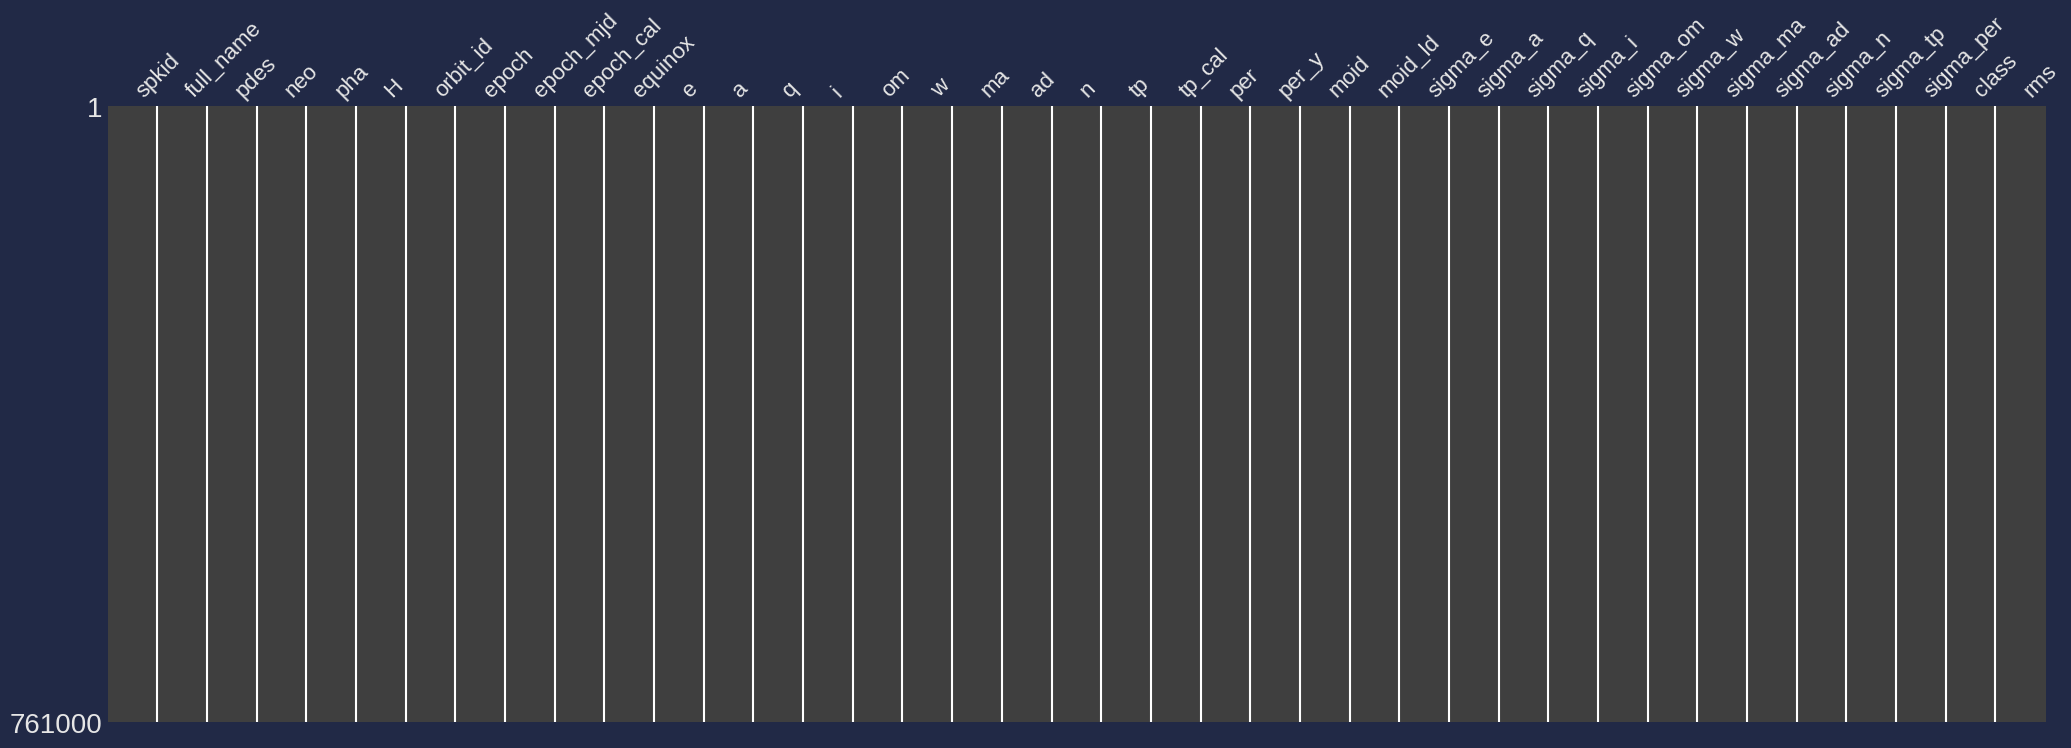

In [31]:
si = SimpleImputer(missing_values=np.nan, strategy='mean')
df_asteroids[df_asteroids.select_dtypes(['number']).columns] = si.fit_transform(df_asteroids.select_dtypes(['number']))
_, ax = plt.subplots(1, 1, figsize=(25, 8))
msno.matrix(df_asteroids, ax=ax);

# Data visualization  
## Balance of categorical data  
### By `PHA`  


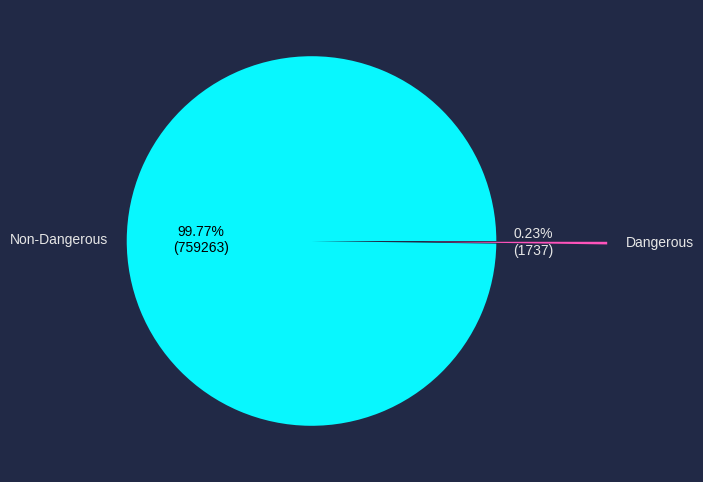

In [32]:
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.2f}%\n({v:d})'.format(pct, v=val)
        return my_format

cmap = mpl.colormaps['Paired']
plt.figure(figsize=(6, 6))
pha_counts = df_asteroids["pha"].value_counts()
_, _, autotexts = plt.pie(pha_counts, labels=["Non-Dangerous", "Dangerous"], autopct=autopct_format(pha_counts), explode=(0, 0.6))
autotexts[0].set_color('black')

As we can observe, our dataset is highly imbalanced with respect to the `target`, meaning we have many records of non-hazardous asteroids compared to the few records of hazardous asteroids. This can pose a problem, and later we will explore how to address it.

### By `NEO`, `ORBIT_ID`, `EQUINOX` and `CLASS`

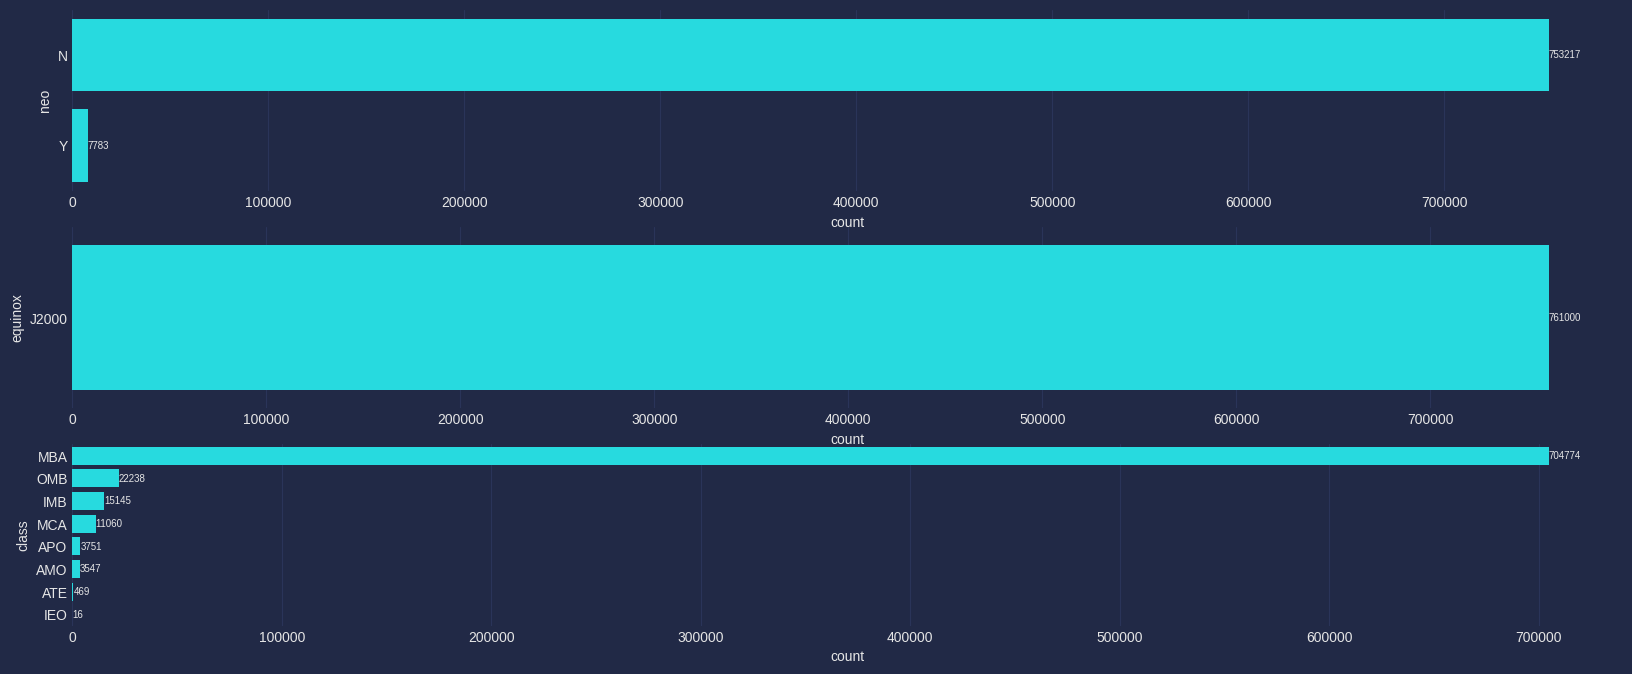

In [33]:
fig = plt.figure(figsize=(20, 8))
axs = fig.subplots(3, 1)
for i, col in enumerate(["neo", "equinox", "class"]):
  sns.countplot(data=df_asteroids, y=col, ax=axs[i], order=df_asteroids[col].value_counts().index)
  for container in axs[i].containers:
    axs[i].bar_label(container, fontsize=7)
mplcyberpunk.add_glow_effects()

We have 3 charts, and we'll discuss them briefly:

+ `neo` is a parameter that defines whether an asteroid is a Near-Earth Object (NEO). As expected, most asteroids are not near the Earth, and this aligns with what we saw earlier. We had observed that there is a large percentage of asteroids that are not dangerous to Earth, so it’s normal that most of these asteroids are far from Earth. However, this does not imply that an asteroid far from Earth cannot be potentially dangerous.

+ The first thing to highlight is that all the values of `equinox` are `J2000`, so if all values are the same, this feature is not very useful at first glance. But after doing some research, I found the following on this [Wikipedia](https://es.wikipedia.org/wiki/Fecha_juliana#J2000.0) page:

  > *In astronomy, **J2000.0** refers to the Julian date 2451545.0 TT (Terrestrial Time), or January 1, 2000, noon TT. It is equivalent to January 1, 2000, 11:59:27.816 TAI, or January 1, 2000, 11:58:55.816 UTC.*
  >
  > *This date is widely used to indicate a standard instant in time for measuring the positions of celestial bodies and other stellar events. For example, although imperceptible to the naked eye, stars move through space, and it is necessary, to describe their position in the sky, to specify the date to which that position refers. As we can see, most of the asteroids for which we have records are not close to Earth.*

  If we observe our dataset, for example, we’ll see that we have 3 features named `epoch`, `epoch_mjd`, and `epoch_cal`, which are times associated with sets of osculating elements, and along with `equinox`, they indicate that they are within the **J2000** reference frame.

+ On the other hand, we can observe that most of the asteroids are classified as MBA (Main-belt Asteroid), meaning they are asteroids with orbital elements restricted by (2.0 AU < a < 3.2 AU; q > 1.666 AU).

  <img src=https://astronomy.swin.edu.au/cms/cpg15x/albums/userpics/mainasteroidbelt1.gif width="300">

  But what are AU? They are Astronomical Units, created because distances in the Solar System are very large. To compare the average distances between the Sun and the planets, it is more convenient to express them in terms of the average separation between the Earth and the Sun.

  1 AU = average distance between the sun and the Earth = 1.496 × 10^8 km

  <img src=https://astronomy.swin.edu.au/cms/cpg15x/albums/userpics/AU.gif)

  After researching asteroid classification, I found the following table:

| Abbreviation | Title | Description |
  | ------------- | ------ | ----------- |
  |AMO|Amor|Near-Earth asteroid, orbit similar to 1221 Amor (a > 1.0 AU; 1.017 AU < q < 1.3 AU).|
  |APO|Apollo|Near-Earth asteroids with orbits that cross Earth's orbit, similar to 1862 Apollo (a > 1.0 AU; q < 1.017 AU).|
  |AST|Asteroid|The asteroid's orbit does not match any defined class.|
  |ATE|Aten|Near-Earth asteroid, orbit similar to 2062 Aten (a < 1.0 AU; Q > 0.983 AU).|
  |CEN|Centaur|Objects with orbits between Jupiter and Neptune (5.5 AU < a < 30.1 AU).|
  |HYA|Hyperbolic Asteroid|Asteroids in hyperbolic orbits (e > 1.0).|
  |IEO|Interior Earth Object|An asteroid's orbit entirely contained within Earth's orbit (Q < 0.983 AU).|
  |IMB|Inner Main-belt Asteroid|Asteroids with orbital elements restricted by (a < 2.0 AU; q > 1.666 AU).|
  |MBA|Main-belt Asteroid|Asteroids with orbital elements restricted by (2.0 AU < a < 3.2 AU; q > 1.666 AU).|
  |MCA|Mars-crossing Asteroid|Asteroids that cross Mars's orbit, restricted by (1.3 AU < q < 1.666 AU; a < 3.2 AU).|
  |OMB|Outer Main-belt Asteroid|Asteroids with orbital elements restricted by (3.2 AU < a < 4.6 AU).|
  |PAA|Parabolic Asteroid|Asteroids in parabolic orbits (e = 1.0).|
  |TJN|Jupiter Trojan|Asteroids trapped in Jupiter's Lagrange points L4/L5 (4.6 AU < a < 5.5 AU; e < 0.3).|
  |TNO|TransNeptunian Object|Objects with orbits beyond Neptune (a > 30.1 AU).|

  Where `a` is the semi-major axis of the orbit, `q` is the perihelion distance, `Q` or `ad` is the aphelion distance, and `e` is the orbital eccentricity. Let's see what these parameters are.

  Generally, an orbit follows an elliptical shape (elliptical orbit), and the semi-major axis `a` of an ellipse is as follows:

  <img src=https://upload.wikimedia.org/wikipedia/commons/thumb/a/a1/Ellipse_semi-major_and_minor_axes.svg/450px-Ellipse_semi-major_and_minor_axes.svg.png width="300">

  In these cases, `a` > 0.  
  An orbit can also follow a hyperbolic shape (hyperbolic orbit), where `a` is the distance between the center of the hyperbola and one of its vertices:

  <img src=https://oer.pressbooks.pub/app/uploads/sites/30/2021/02/hyperbolic-orbit.gif width="300">

  Therefore, `a` can be negative or positive.  
  There are also two special cases of an ellipse: if `a` is equal to the radius of the orbit, we are in the presence of a circular orbit:

  <img src=https://oer-pressbooks-pub.translate.goog/app/uploads/sites/30/2021/02/circular-orbit.png width="300">

  And if `a` is infinitely large, we are in the presence of a parabolic orbit, which is the limiting case between the elliptical orbit (closed) and the hyperbolic orbit (open).

  <img src=https://oer.pressbooks.pub/app/uploads/sites/30/2021/02/Rf65408b6aad113c302c4bdcac83c0a54.gif width="300">

  The aphelion is the point in an orbit that is furthest from the Sun (`Q`), and on the other side, the perihelion is the point in an orbit closest to the Sun (`q`):

  <img src=https://upload.wikimedia.org/wikipedia/commons/thumb/5/5b/Afelio_Perihelio_Sol_Tierra.png/375px-Afelio_Perihelio_Sol_Tierra.png width="300">

  Lastly, eccentricity `e` is a parameter that determines the degree of deviation of a conic section from a circle. Therefore, it defines the shape of the celestial body's orbit:

  <img src=https://upload.wikimedia.org/wikipedia/commons/thumb/f/fb/Excentricidad.svg/330px-Excentricidad.svg.png width="300">

  Based on the eccentricity of the orbit, it can be classified following this table:

|Eccentricity|Orbit Type|
  |-------------|----------|
  |0 < e < 1|Elliptical Orbit|
  |e = 0|Circular Orbit|
  |e = 1|Parabolic Orbit|
  |e > 1|Hyperbolic Orbit|

  And visually, they look like this:

  <img src=https://upload.wikimedia.org/wikipedia/commons/thumb/1/11/Conic_Sections.svg/langes-800px-Conic_Sections.svg.png width="300">
  
  <img src=https://upload.wikimedia.org/wikipedia/commons/thumb/7/7b/Conic_sections_ani.gif/330px-Conic_sections_ani.gif width="300">

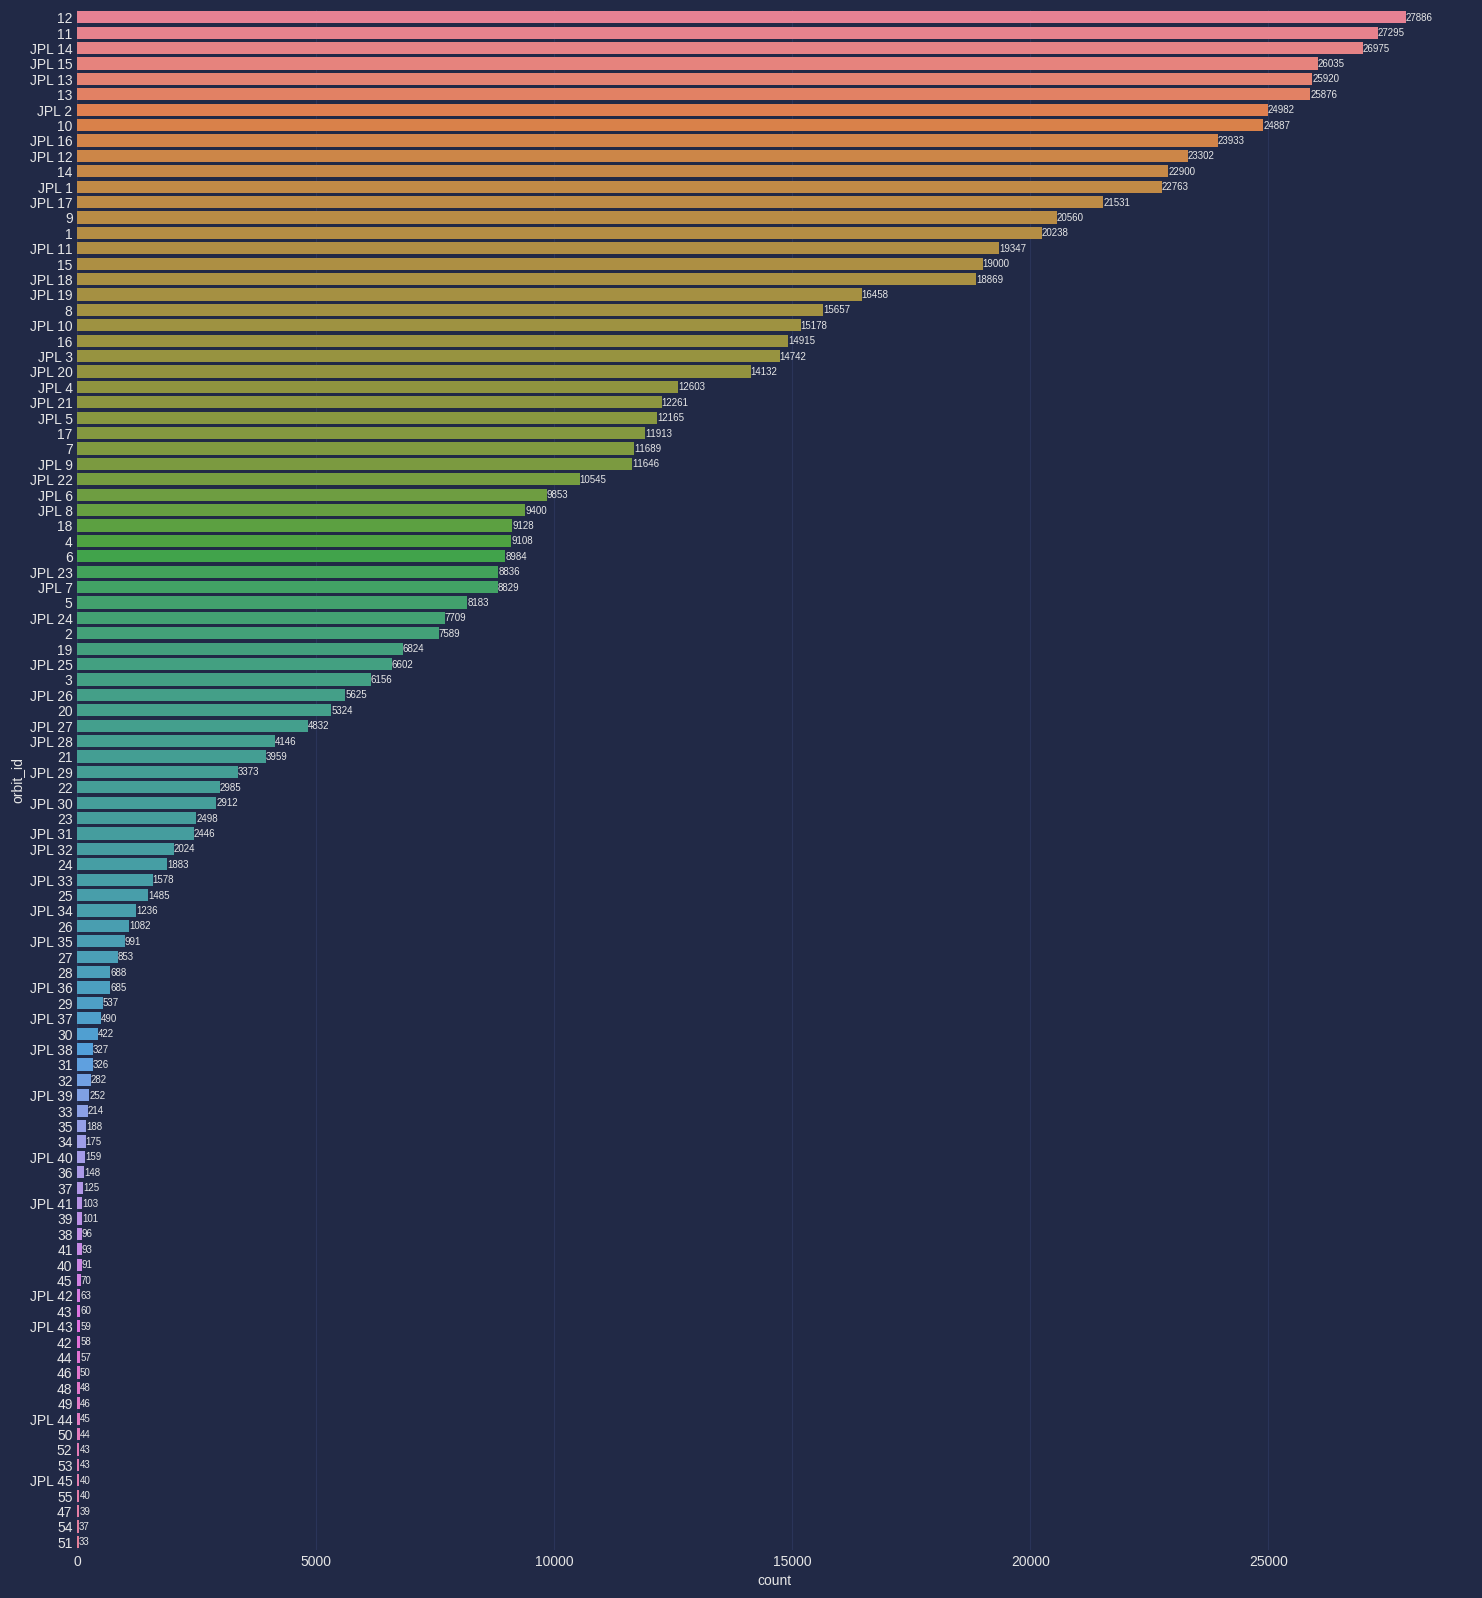

In [34]:
aux = df_asteroids["orbit_id"].value_counts().iloc[:100].reset_index()

fig = plt.figure(figsize=(18, 20))
ax = sns.barplot(data=aux, y="orbit_id", x="count", hue="orbit_id")
for container in ax.containers:
    ax.bar_label(container, fontsize=7)

## Numerical features by `PHA`


### Shapes of asteroid orbits according to `a` (semi-major axis of the orbit) and `e` (orbital eccentricity)

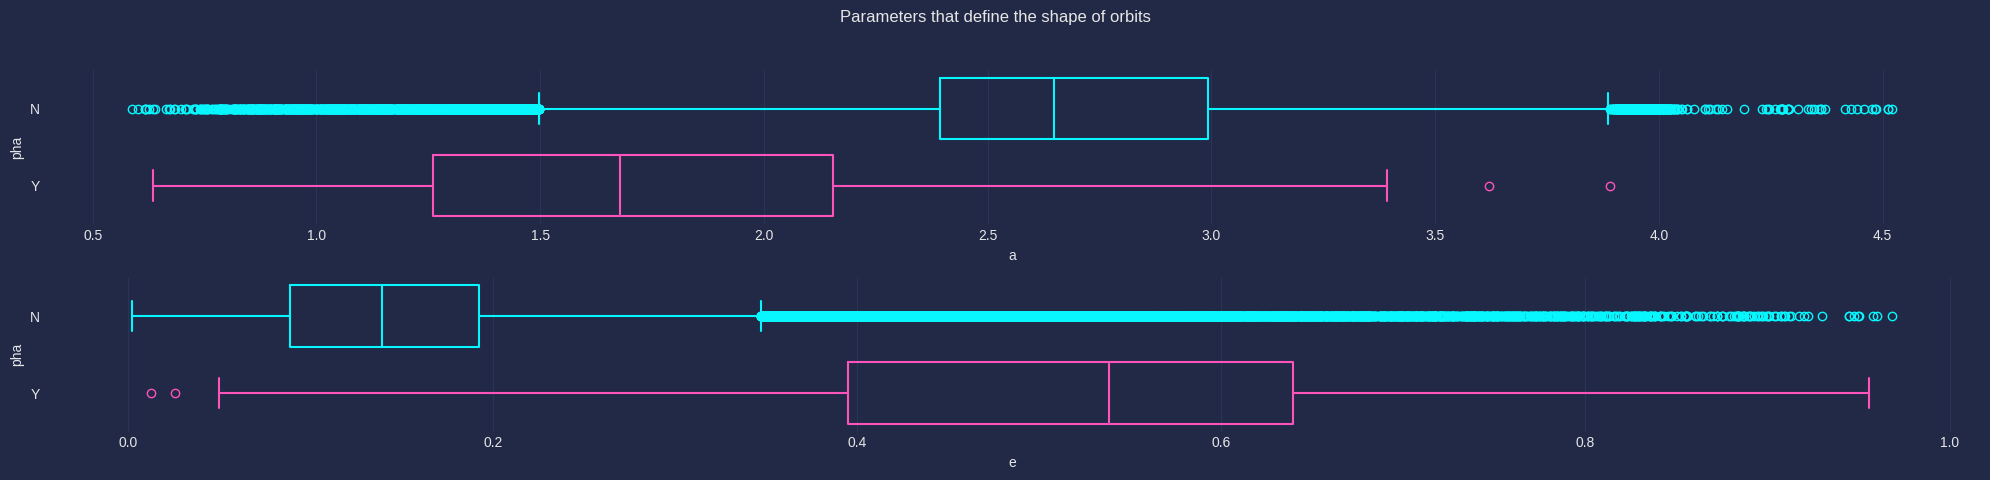

In [35]:
fig = plt.figure(figsize=(20, 5))
axs = fig.subplots(2, 1)
sns.boxplot(data=df_asteroids, y="pha", x="a", ax=axs[0], hue="pha", fill=False)
sns.boxplot(data=df_asteroids, y="pha", x="e", ax=axs[1], hue="pha", fill=False)
plt.suptitle("Parameters that define the shape of orbits")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [36]:
df_asteroids.loc[ df_asteroids["pha"] == 'Y', ["a", "e"]].describe().transpose()

count      mean       std       min       25%       50%       75%  \
a  1737.0  1.725794  0.570476  0.635237  1.260581  1.677777  2.154868   
e  1737.0  0.516548  0.174132  0.012176  0.395379  0.538288  0.639446   

        max  
a  3.891236  
e  0.955945

In [37]:
df_asteroids.loc[df_asteroids["pha"] == 'N', ["a", "e"]].describe().transpose()

count     mean       std       min       25%       50%       75%  \
a  759263.0  2.67373  0.347634  0.588650  2.394397  2.648678  2.992177   
e  759263.0  0.14671  0.079136  0.002157  0.088949  0.138947  0.192300   

        max  
a  4.521041  
e  0.968396

According to these two parameters, we can describe the shape of an asteroid's orbit:

- As we can see, the mean values of **potentially hazardous asteroids (PHA)** indicate that they follow an **elliptical orbit** (0 < e < 1), with a **mean semi-major axis (`a`) tending to 1.77 AU**. This suggests that the farthest point of the asteroid’s orbit remains relatively close to its center. If we consider the center of the orbit as the position of the **Sun**, then these asteroids are **very close to Earth's orbit**.

- **Non-hazardous asteroids**, on the other hand, have **elliptical orbits with a tendency toward circular orbits** (e → 0). Their **mean semi-major axis is approximately 2.67 AU**, indicating that they are **farther from the Sun** than potentially hazardous asteroids. As a result, their distance from Earth is also greater.


### Distances to the Sun (`q`, `ad`) and intersection with Earth's orbit (`moid`)

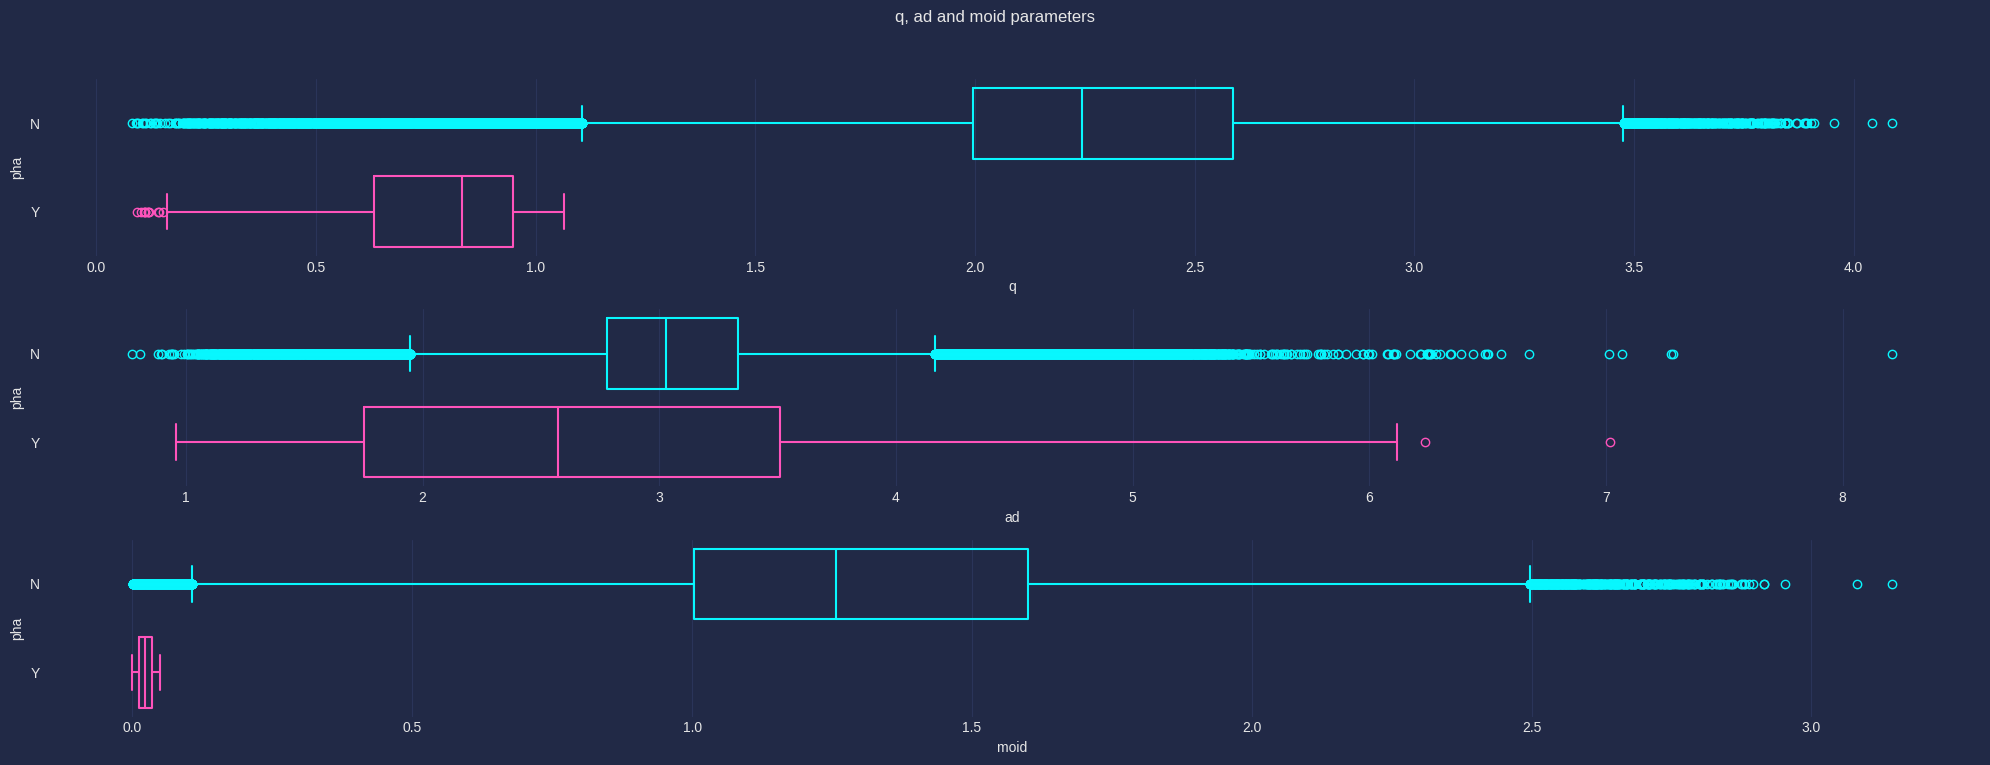

In [38]:
fig = plt.figure(figsize=(20, 8))
axs = fig.subplots(3, 1)
Y = df_asteroids[df_asteroids["pha"] == "Y"]
N = df_asteroids[df_asteroids["pha"] == "N"]
for i, col in enumerate(["q", "ad", "moid"]):
  sns.boxplot(data=df_asteroids, x=col, y="pha", ax=axs[i], hue="pha", fill=False)
plt.suptitle("q, ad and moid parameters")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [39]:
df_asteroids.loc[ df_asteroids["pha"] == 'Y', ["q", "ad", "moid"]].describe().transpose()

count      mean       std       min       25%       50%       75%  \
q     1737.0  0.772882  0.216736  0.092924  0.632853  0.833029  0.947844   
ad    1737.0  2.678706  1.086418  0.956053  1.754060  2.572915  3.511260   
moid  1737.0  0.023482  0.014392  0.000027  0.011055  0.023233  0.035039   

           max  
q     1.064284  
ad    7.016173  
moid  0.049991

In [40]:
df_asteroids.loc[ df_asteroids["pha"] == 'N', ["q", "ad", "moid"]].describe().transpose()

count      mean       std       min       25%       50%       75%  \
q     759263.0  2.285278  0.385105  0.081820  1.994405  2.243618  2.587117   
ad    759263.0  3.062181  0.426442  0.773666  2.779532  3.029316  3.334100   
moid  759263.0  1.299769  0.379235  0.000226  1.002650  1.257760  1.600210   

           max  
q     4.087681  
ad    8.208638  
moid  3.143950

- If we look at the graphs, we can conclude that both the perihelion distance (`q`) and the aphelion distance (`ad`) have lower average values for potentially hazardous asteroids compared to non-hazardous ones. This suggests that these asteroids have orbits closer to the Sun, increasing the likelihood of intersecting Earth's orbit.
- To confirm this observation, we can analyze the `moid` variable, which represents the minimum orbit intersection distance (MOID). It is defined as the shortest distance between the closest points of both orbits:

  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9e/4953_DYK.svg/450px-4953_DYK.svg.png" width="300">

  > Orbit of asteroid (4953) 1990 MU in relation to Earth's orbit. Its MOID of 0.0276 AU classifies it as a potentially hazardous object.

  Observing this variable, it is expected that potentially hazardous asteroids have lower `moid` values compared to non-hazardous ones, which is precisely what we observe.


### Asteroid diameters according to the `H` variable and the `albedo`

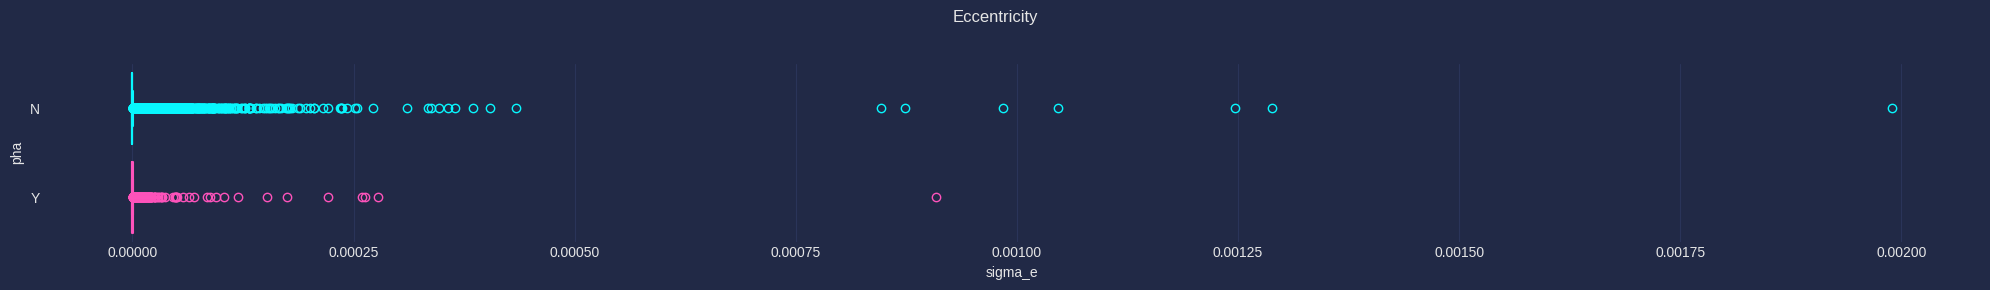

In [41]:
fig = plt.figure(figsize=(20, 3))
sns.boxplot(data=df_asteroids, y="pha", x="sigma_e", hue="pha", fill=False)
plt.suptitle("Eccentricity")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

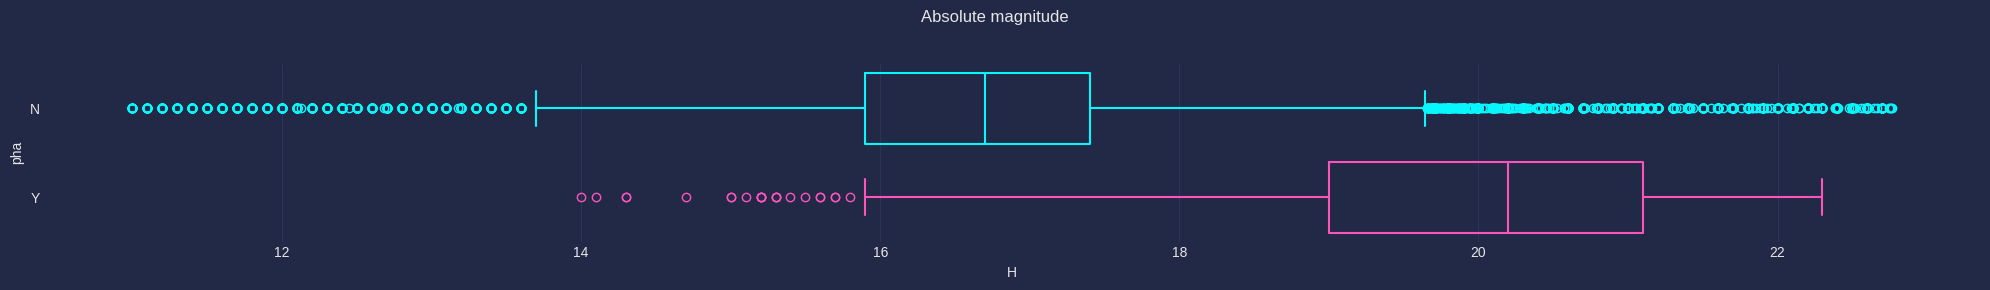

In [42]:
fig = plt.figure(figsize=(20, 3))
sns.boxplot(data=df_asteroids, y="pha", x="H", hue="pha", fill=False)
plt.suptitle("Absolute magnitude")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

+ The first point to clarify is that while we do not have data on the `albedo` of the asteroids, since we discarded this data earlier due to its high number of null values, it is generally considered that the albedo falls between 0.25 and 0.05. Based on this, with the absolute magnitude `H`, we can approximate some ranges of asteroid diameters. The absolute magnitude is the magnitude that an observer would see if the asteroid were at a distance of 1 AU from the Sun, with a phase angle (α) of zero. This angle is formed between the Sun and the Earth as seen from the asteroid:

  <img src=https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/Phase_angle_explanation.png/375px-Phase_angle_explanation.png width="200">

  Once this is understood, we can create the following table:
  
  <img src=https://josevicentediaz.files.wordpress.com/2014/09/captura79.jpg width="300">

  From this, we can conclude that the smaller the absolute magnitude, the larger the estimated diameter of the asteroid.

+ As mentioned earlier, potentially dangerous asteroids on average have smaller diameters compared to non-dangerous asteroids. This might seem counterintuitive because one would expect larger asteroids to be more dangerous. However, the danger posed by an asteroid is not only dependent on its size, but as we have seen, it mainly depends on the likelihood of it intersecting with Earth's orbit. In other words, an asteroid, no matter how large, does not pose a potential risk if it does not have a chance of colliding with Earth. However, the asteroid's diameter does affect its destructive potential, because if it does collide with Earth, the larger its diameter, the greater the damage it is likely to cause.


### Angular variables

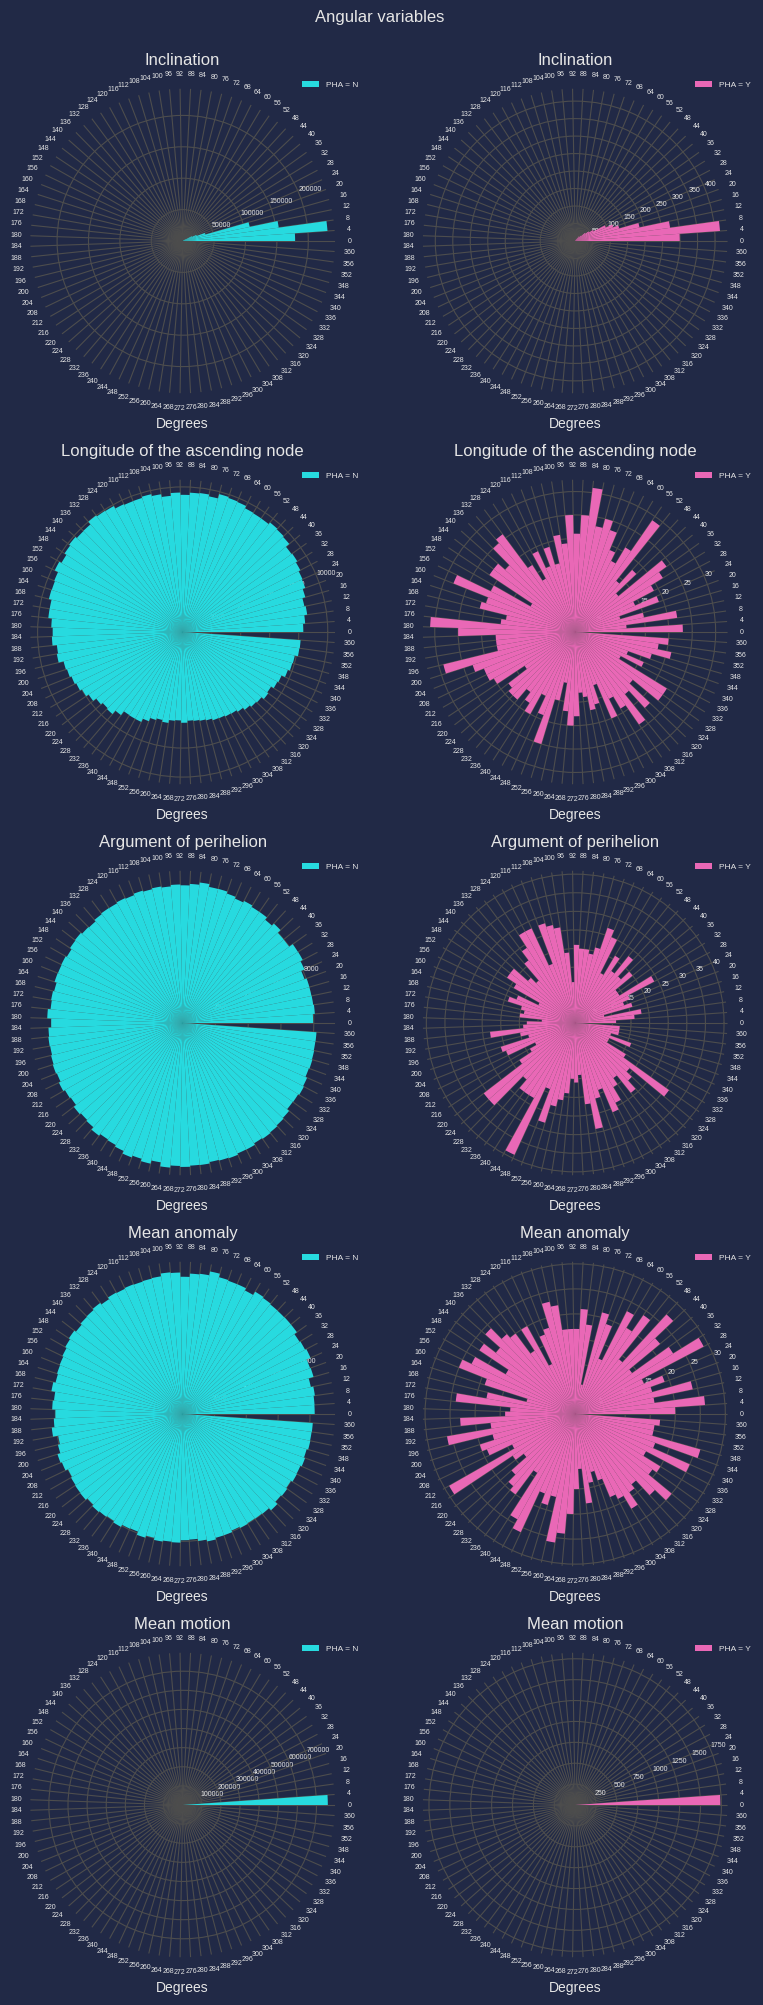

In [43]:
n=4
theta = np.linspace(0.0, 2 * np.pi, 364//n, endpoint=False)
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(8, 20), subplot_kw=dict(polar=True))
titles = {'i':"Inclination", 'om':"Longitude of the ascending node", 'w':"Argument of perihelion", 'ma':"Mean anomaly", 'n':"Mean motion"}
for i, col in enumerate(['i', 'om', 'w', 'ma', 'n']):
  ax = axs[i]
  data = [df_asteroids.loc[df_asteroids["pha"] == 'N', col], df_asteroids.loc[df_asteroids["pha"] == 'Y', col]]

  bars = ax[0].hist(data[0]*np.pi/180, bins=theta, color='#27DADF')
  ax[0].set_xticks(theta)
  ax[0].set_xticklabels(np.arange(0, 364, n))
  ax[0].xaxis.set_tick_params(labelsize=5)
  ax[0].yaxis.set_tick_params(labelsize=5)
  #ax[0].set_thetamax(180)
  ax[0].set_xlabel("Degrees")
  ax[0].set_title(titles[col], y=1.05)
  ax[0].legend(['PHA = N'], bbox_to_anchor=(1.1, 1.05), prop={'size': 6})
  ax[0].grid(color=(0.3, 0.3, 0.3))


  bars = ax[1].hist(data[1]*np.pi/180, bins=theta, color='#E968B6')
  ax[1].set_xticks(theta)
  ax[1].set_xticklabels(np.arange(0, 364, n))
  ax[1].xaxis.set_tick_params(labelsize=5)
  ax[1].yaxis.set_tick_params(labelsize=5)
  #ax[1].set_thetamax(180)
  ax[1].set_xlabel("Degrees")
  ax[1].set_title(titles[col], y=1.05)
  ax[1].legend(['PHA = Y'], bbox_to_anchor=(1.1, 1.05), prop={'size': 6})
  ax[1].grid(color=(0.3, 0.3, 0.3))
plt.suptitle("Angular variables", y=1.0001)
fig.tight_layout()

+ The `i` variable is the inclination of the asteroid's orbit relative to the ecliptic plane.

  <img src=https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Orbital_elements.svg/450px-Orbital_elements.svg.png width="300">

  In this diagram, we can also observe the variables `om` and `w`, which we will discuss shortly. The ecliptic plane is the plane defined by the Earth's orbit around the Sun, i.e., it is the plane that the Earth's orbit defines.

  <img src=https://upload.wikimedia.org/wikipedia/commons/f/f1/Ecl%C3%ADptica_diagrama2.png width="250">

  From the graph, we can see that the mean value (~9°) of this variable does not differ between potentially dangerous asteroids and those that are not.

+ The longitude of the ascending node `om` shows quite a random behavior for potentially dangerous asteroids. However, for asteroids that are not dangerous, we observe a slight inclination towards values between `0° < om < 180°`. The longitude of the ascending node is the angle from a reference direction, called the origin of longitude, to the direction of the ascending node, measured in a reference plane, as shown in the adjacent image:

  <img src=https://upload.wikimedia.org/wikipedia/commons/thumb/e/eb/Orbit1.svg/langes-600px-Orbit1.svg.png width="300">

+ The argument of perihelion `w` is the angle from the ascending node to the perihelion, measured in the orbital plane of the object and in the direction of its motion. As we can see, this characteristic shows asteroids distributed evenly between 0° and 360°. However, for potentially dangerous asteroids, there is a slight inclination towards values between 180° and 360°.

+ The mean anomaly `ma` is the angle measured from the perihelion, in the direction of motion, at the moment of the epoch. It is defined as the product of the difference between the current time and the epoch when it passed through the perihelion and the mean motion `n`.



### Plotting the orbits of the asteroids
#### Orbits of potentially dangerous asteroids and non-dangerous asteroids

In [44]:
pio.renderers.default = "iframe"

In [45]:
def au2km(x):
  return x*149597870.7

def asteroid_orbit_from_orbital_elements(df, index, object_center="sun"):
  asteroid = df_asteroids.loc[index, :]
  ma = asteroid.ma   #mean anomaly
  e = asteroid.e     #eccentricity
  a = au2km(asteroid.a)     #semi-major axis
  nu = ma + (2*e - (e**3)/4)*np.sin(ma) + (5/4)*(e**2)*np.sin(2*ma) + (13/12)*(e**3)*np.sin(3*ma)     #true anomaly
  p = a*(1-e**2)  #semi-latus rectum
  if object_center == "sun":
    obc = Sun
    mu = 1.32712E11 #standard gravitational parameter of the Sun
  elif object_center == "earth":
    obc = Earth
    mu = 3.98600E5 #standard gravitational parameter of the Earth
  omega = asteroid.w
  i = asteroid.i
  epoch = Time([asteroid.epoch], format='jd')

  # According to https://downloads.rene-schwarz.com/download/M001-Keplerian_Orbit_Elements_to_Cartesian_State_Vectors.pdf

  # Transform to perifocal frame
  r_w = (p / (1 + e * np.cos(nu))) * np.array((np.cos(nu), np.sin(nu), 0))
  v_w = ((mu/p)**(1/2)) * np.array((-np.sin(nu), e + np.cos(nu), 0))

  # Rotate the perifocal frame
  R = Rotation.from_euler("ZXZ", [-omega, -i, -omega])
  r_rot = r_w @ R.as_matrix()
  v_rot = v_w @ R.as_matrix()

  # Change units
  r = r_rot * u.km
  v = v_rot * u.km / u.s

  return r, v, epoch, asteroid.full_name, Orbit.from_vectors(obc, r, v, epoch, plane=Planes.EARTH_ECLIPTIC)

##### Orbits in 2D

In [46]:
asteroids_phaY = df_asteroids[df_asteroids["pha"] == 'Y'].index[0:10].tolist()
asteroids_phaN = df_asteroids[df_asteroids["pha"] == 'N'].index[0:10].tolist()
list_asteroid = [[index, "PHA=Yes"] for index in asteroids_phaY] + [[index, "PHA=No"] for index in asteroids_phaN]

EPOCH = Time("2000-01-01 12:00:00", scale="tdb")
frame = plot_solar_system(outer=False, epoch=EPOCH, interactive=True)
#frame._ax.figure.set_size_inches(25, 12)
for i in list_asteroid:
  _, _, epoch, ast_name, orb = asteroid_orbit_from_orbital_elements(df_asteroids, i[0], object_center="sun")

  if i[1] == "PHA=Yes":
    frame.plot(orb, label=ast_name + " " + i[1], color="red", )
  else:
    frame.plot(orb, label=ast_name.replace("  ", "") + " " + i[1])

frame._figure.update_layout(autosize=False, legend=dict(orientation="h", font=dict(size=8)), width=600, height=700, margin=dict(l=20, r=20, b=20, t=20, pad=0), template="plotly_dark")
frame.show()

##### Orbits in 3D

In [47]:
frame = plot_solar_system(outer=False, epoch=EPOCH, interactive=True, use_3d=True)
#frame._ax.figure.set_size_inches(25, 12)
for i in list_asteroid:
  _, _, epoch, ast_name, orb = asteroid_orbit_from_orbital_elements(df_asteroids, i[0], object_center="sun")

  if i[1] == "PHA=Yes":
    frame.plot(orb, label=ast_name + " " + i[1], color="red")
  else:
    frame.plot(orb, label=ast_name.replace("  ", "") + " " + i[1])

frame._figure.update_layout(autosize=False, legend=dict(orientation="h", font=dict(size=8)), width=600, height=700, margin=dict(l=20, r=20, b=20, t=20, pad=0), template="plotly_dark")
frame.show()

##### Near-Earth Objects

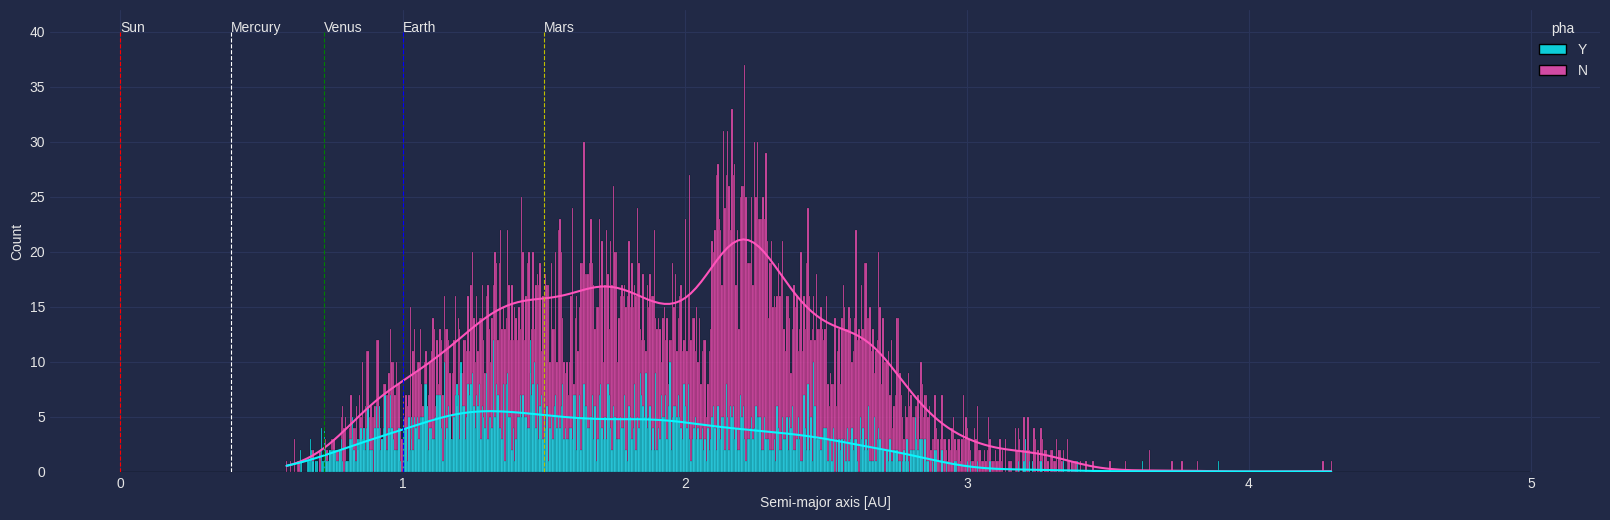

In [48]:
neos = df_asteroids[df_asteroids["neo"] == 'Y']

fig = plt.figure(figsize=(20, 6))
bin_w = 0.005
neos_min = 0
neos_max = 5
bins = np.arange(neos_min, neos_max, bin_w)
sns.histplot(data=neos, x="a", hue="pha", hue_order=["Y", "N"], kde=True, bins=bins, alpha=0.8)
plt.xlabel("Semi-major axis [AU]")

plt.plot( [0, 0], [40, 0], 'r--', lw=0.8)
plt.text( 0, 40, "Sun")

plt.plot( [0.39, 0.39], [40, 0], 'w--', lw=0.8)
plt.text( 0.39, 40, "Mercury")

plt.plot( [0.72, 0.72], [40, 0], 'g--', lw=0.8)
plt.text( 0.72, 40, "Venus")

plt.plot( [1, 1], [40, 0], 'b--', lw=0.8)
plt.text( 1, 40, "Earth")

plt.plot( [1.5, 1.5], [40, 0], 'y--', lw=0.8)
plt.text( 1.5, 40, "Mars");

In [49]:
df_asteroids.groupby(["pha"]).a.mean()

pha
N    2.673730
Y    1.725794
Name: a, dtype: float64

The NEOs that are potentially dangerous have orbits with lower semi-major axis values.

In [50]:
df_asteroids.loc[df_asteroids["pha"] == "Y", "neo"].value_counts()

neo
Y    1737
Name: count, dtype: int64

In [51]:
df_asteroids.loc[df_asteroids["neo"] == "Y", "pha"].value_counts()

pha
N    6046
Y    1737
Name: count, dtype: int64

As we can see, not all near-Earth objects are potentially dangerous, but it can be confirmed that all potentially dangerous asteroids are near-Earth objects.




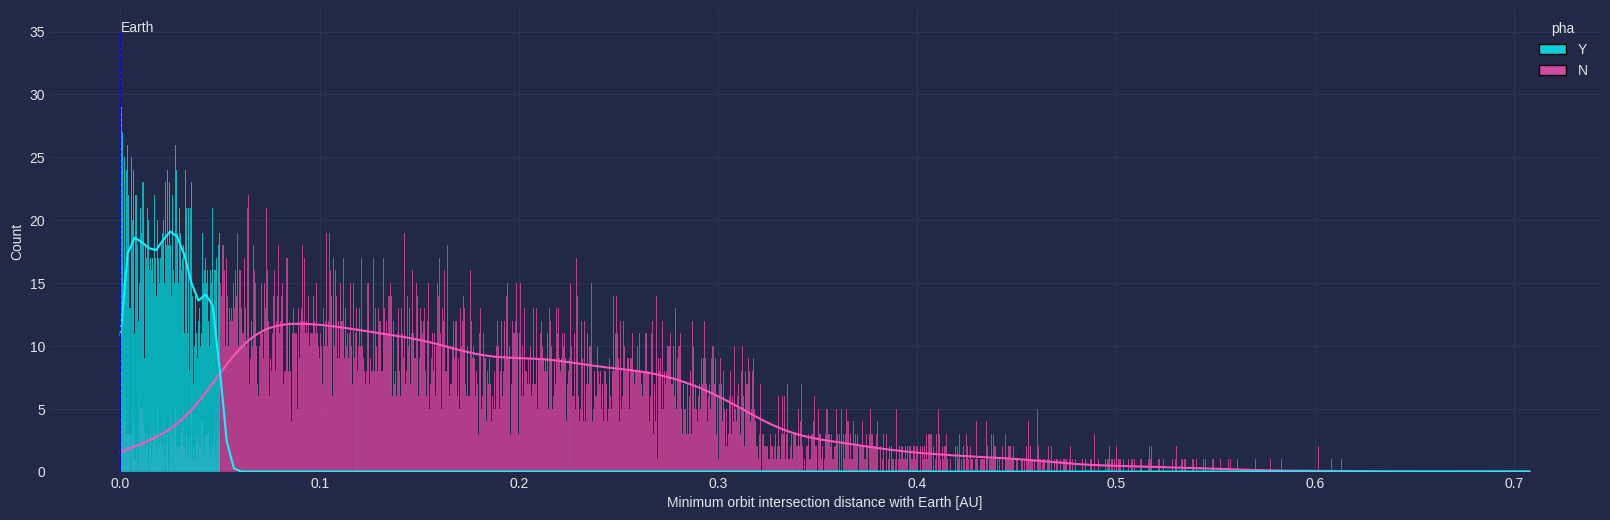

In [52]:
moid = df_asteroids[df_asteroids["neo"] == 'Y']

fig = plt.figure(figsize=(20, 6))
bin_w = 0.0005
moid_min = moid.moid.min()
moid_max = moid.moid.max()
bins = np.arange(moid_min, moid_max, bin_w)
sns.histplot(data=moid, x="moid", hue="pha", kde=True, hue_order=["Y", "N"], bins=bins, alpha=0.8)
plt.xlabel("Minimum orbit intersection distance with Earth [AU]")
plt.plot( [0, 0], [35, 0], 'b--', lw=0.8)
plt.text( 0, 35, "Earth");

+ Once again, not all `neos` are potentially dangerous, but those objects that have smaller intersection distances with the Earth's orbit are.
+ We can conclude that potentially dangerous asteroids have orbits with a very high probability of intersecting with the Earth's orbit.


In [53]:
asteroids_neo_Y = df_asteroids[df_asteroids["neo"] == 'Y'].index[0:10].tolist()
asteroids_neo_N = df_asteroids[df_asteroids["neo"] == 'N'].index[0:10].tolist()
list_asteroid = [[index, "NEO=Yes"] for index in asteroids_neo_Y] + [[index, "NEO=No"] for index in asteroids_neo_N]

frame = plot_solar_system(outer=False, epoch=EPOCH, interactive=True, use_3d=True)
#frame._ax.figure.set_size_inches(25, 12)
for i in list_asteroid:
  _, _, epoch, ast_name, orb = asteroid_orbit_from_orbital_elements(df_asteroids, i[0], object_center="sun")

  if i[1] == "NEO=Yes":
    frame.plot(orb, label=ast_name + " " + i[1], color="red")
  else:
    frame.plot(orb, label=ast_name.replace("  ", "") + " " + i[1], color="green")

frame._figure.update_layout(autosize=False, legend=dict(orientation="h", font=dict(size=8)), width=600, height=700, margin=dict(l=20, r=20, b=20, t=20, pad=0), template="plotly_dark")
frame.show()

##### Circular orbits

In [54]:
circulares = df_asteroids[df_asteroids["e"] < 0.1].sort_values(by='e', ascending=True).index[0:10].tolist()
list_asteroid = [[index, f"e={round(df_asteroids.loc[index, 'e'], 4)}"] for index in circulares]

frame = plot_solar_system(outer=False, epoch=EPOCH, interactive=True, use_3d=True)
for i in list_asteroid:
  _, _, epoch, ast_name, orb = asteroid_orbit_from_orbital_elements(df_asteroids, i[0], object_center="sun")
  frame.plot(orb, label=ast_name + " " + i[1])

frame._figure.update_layout(autosize=False, legend=dict(orientation="h", font=dict(size=8)), width=600, height=700, margin=dict(l=20, r=20, b=20, t=20, pad=0), template="plotly_dark")
frame.show()

##### Elliptical orbits

In [55]:
circulares = df_asteroids[(df_asteroids["e"] > 0.4) & (df_asteroids["e"] < 0.6)].index[0:10].tolist()
list_asteroid = [[index, f"e={round(df_asteroids.loc[index, 'e'], 4)}"] for index in circulares]

frame = plot_solar_system(outer=False, epoch=EPOCH, interactive=True, use_3d=True)
for i in list_asteroid:
  _, _, epoch, ast_name, orb = asteroid_orbit_from_orbital_elements(df_asteroids, i[0], object_center="sun")
  frame.plot(orb, label=ast_name + " " + i[1])

frame._figure.update_layout(autosize=False, legend=dict(orientation="h", font=dict(size=8)), width=600, height=700, margin=dict(l=20, r=20, b=20, t=20, pad=0), template="plotly_dark")
frame.show()

##### Parabolic and hyperbolic orbits

In [56]:
hyperbolics = df_asteroids[df_asteroids["e"] > 0.9].sort_values(by='e', ascending=False).index[0:10].tolist()
list_asteroid = [[index, f"e={round(df_asteroids.loc[index, 'e'], 4)}"] for index in hyperbolics]

frame = plot_solar_system(outer=False, epoch=EPOCH, interactive=True, use_3d=True)
for i in list_asteroid:
  _, _, epoch, ast_name, orb = asteroid_orbit_from_orbital_elements(df_asteroids, i[0], object_center="sun")
  frame.plot(orb, label=ast_name + " " + i[1])

frame._figure.update_layout(autosize=False, legend=dict(orientation="h", font=dict(size=8)), width=600, height=700, margin=dict(l=20, r=20, b=20, t=20, pad=0), template="plotly_dark")
frame.show()

#### Orbits by classification

| Abbreviation | Title | Description |
  | ------------- | ------ | ----------- |
  |AMO|Amor|Near-Earth asteroid, orbit similar to 1221 Amor (a > 1.0 AU; 1.017 AU < q < 1.3 AU).|
  |APO|Apollo|Near-Earth asteroids with orbits that cross Earth's orbit, similar to 1862 Apollo (a > 1.0 AU; q < 1.017 AU).|
  |AST|Asteroid|The asteroid's orbit does not match any defined class.|
  |ATE|Aten|Near-Earth asteroid, orbit similar to 2062 Aten (a < 1.0 AU; Q > 0.983 AU).|
  |CEN|Centaur|Objects with orbits between Jupiter and Neptune (5.5 AU < a < 30.1 AU).|
  |HYA|Hyperbolic Asteroid|Asteroids in hyperbolic orbits (e > 1.0).|
  |IEO|Interior Earth Object|An asteroid's orbit entirely contained within Earth's orbit (Q < 0.983 AU).|
  |IMB|Inner Main-belt Asteroid|Asteroids with orbital elements restricted by (a < 2.0 AU; q > 1.666 AU).|
  |MBA|Main-belt Asteroid|Asteroids with orbital elements restricted by (2.0 AU < a < 3.2 AU; q > 1.666 AU).|
  |MCA|Mars-crossing Asteroid|Asteroids that cross Mars's orbit, restricted by (1.3 AU < q < 1.666 AU; a < 3.2 AU).|
  |OMB|Outer Main-belt Asteroid|Asteroids with orbital elements restricted by (3.2 AU < a < 4.6 AU).|
  |PAA|Parabolic Asteroid|Asteroids in parabolic orbits (e = 1.0).|
  |TJN|Jupiter Trojan|Asteroids trapped in Jupiter's Lagrange points L4/L5 (4.6 AU < a < 5.5 AU; e < 0.3).|
  |TNO|TransNeptunian Object|Objects with orbits beyond Neptune (a > 30.1 AU).|

##### The main asteroid belt

Let’s take a look at some of the asteroids that are in the main asteroid belt, which have orbits between the orbits of Mars and Jupiter.




In [57]:
mba = df_asteroids[df_asteroids["class"] == "MBA"].index[0:5].tolist()
imb = df_asteroids[df_asteroids["class"] == "IMB"].index[0:5].tolist()
omb = df_asteroids[df_asteroids["class"] == "OMB"].index[0:5].tolist()
list_asteroid = [[index, f"class: MBA"] for index in mba] + [[index, f"class: IMB"] for index in imb] + [[index, f"class: OMB"] for index in omb]

frame = plot_solar_system(outer=True, epoch=EPOCH, interactive=True, use_3d=True)
for i in list_asteroid:
  _, _, epoch, ast_name, orb = asteroid_orbit_from_orbital_elements(df_asteroids, i[0], object_center="sun")
  frame.plot(orb, label=ast_name + " " + i[1])

frame._figure.update_layout(autosize=False, legend=dict(orientation="h", font=dict(size=8)), width=600, height=700, margin=dict(l=20, r=20, b=20, t=20, pad=0), template="plotly_dark")
frame.show()

##### Kirkwood Gaps

The Kirkwood gaps are regions in the asteroid belt where the density of asteroids is notably reduced compared to the average density of the belt. These gaps coincide with orbits whose parameters (their semi-major axis or equivalently their orbital period) have a simple ratio with Jupiter's orbit. It is said that the gaps correspond to the orbital resonances with Jupiter.

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



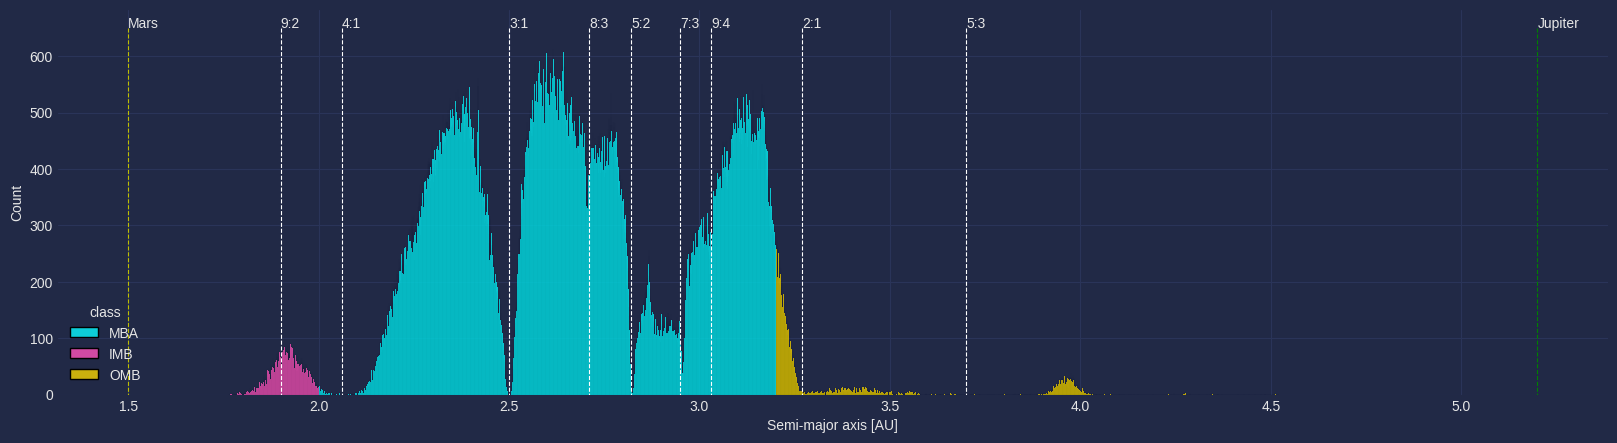

In [58]:
gaps = {"9:2":1.9,
        "4:1":2.06,
        "3:1":2.5,
        "5:2":2.82,
        "7:3":2.95,
        "2:1":3.27,
        "8:3":2.71,
        "9:4":3.03,
        "5:3":3.7,
        }

mainbelt = df_asteroids[df_asteroids["class"].isin(["MBA", "IMB", "OMB", "TJN"])]

fig = plt.figure(figsize=(20, 5))
bin_w = 0.0005
a_min = mainbelt["a"].min()
a_max = mainbelt["a"].max()
bins = np.arange(a_min, a_max, bin_w)
sns.histplot(data=mainbelt, x="a", hue="class", bins=bins, alpha=0.8)
plt.xlabel("Semi-major axis [AU]")

for gap in gaps:
    plt.plot( [gaps[gap], gaps[gap]], [650, 0], 'w--', lw=0.8)
    plt.text( gaps[gap], 650, gap)

plt.plot( [5.2, 5.2], [650, 0], 'g--', lw=0.8)
plt.text( 5.2, 650, "Jupiter")

plt.plot( [1.5, 1.5], [650, 0], 'y--', lw=0.8)
plt.text( 1.5, 650, "Mars");

These resonances are identified as `J:A` where J is the number of revolutions of Jupiter and A is the number of revolutions of the asteroid. That is, while Jupiter makes `J` revolutions, the asteroid will make `A` revolutions. This could cause the asteroid to coincide with a maximum approach to Jupiter every `A` orbits, which would lead to a resonant attraction that could eventually expel it from that orbit.

In Jupiter's orbit, we can find the 1:1 resonance. Asteroids that are in this resonance are known as Trojan asteroids.

As we can observe, the orbits of Mars and Jupiter evidently form the boundaries of this asteroid belt.




##### Orbits completely contained within Earth's orbit

Let’s take a look at some of the asteroids that have orbits completely contained within Earth's orbit.

In [59]:
mba = df_asteroids[df_asteroids["class"] == "IEO"].index[0:15].tolist()
list_asteroid = [[index, f"class: IEO"] for index in mba]

frame = plot_solar_system(outer=False, epoch=EPOCH, interactive=True, use_3d=True)
for i in list_asteroid:
  _, _, epoch, ast_name, orb = asteroid_orbit_from_orbital_elements(df_asteroids, i[0], object_center="sun")
  frame.plot(orb, label=ast_name + " " + i[1])

frame._figure.update_layout(autosize=False, legend=dict(orientation="h", font=dict(size=8)), width=600, height=700, margin=dict(l=20, r=20, b=20, t=20, pad=0), template="plotly_dark")
frame.show()

# Feature Engineering
## Diameters according to the absolute magnitude


In [60]:
#Source: https://authors.library.caltech.edu/70302/1/aj_152_4_79.pdf
#Other source: https://josevicentediaz.com/tag/asteroide-amor/
#We assume an albedo of 0.0615, a value that we had to discard earlier.
albedo = 0.0615
df_asteroids["diametro"] = (1329/albedo)*np.power(10, -0.4*df_asteroids["H"])
df_asteroids[["diametro"]]

diametro
id                
a0000155  0.715566
a0000157  0.784603
a0000220  0.715566
a0000228  0.284872
a0000244  0.375535
...            ...
bK20H07J  0.000460
bK20H08G  0.000221
bK20H10Y  0.000138
bPLS6331  0.000860
bPLS6344  0.000150

[761000 rows x 1 columns]

## Feature elimination

There are some features that are purely for identification purposes. These features will not be useful for our model, as they do not provide relevant information and, in most cases, contain highly varied categorical information.


In [61]:
columns = df_asteroids.columns.tolist()
df_unique = pd.DataFrame(data={"Feature":columns, "Number of values":np.zeros(len(columns), dtype='int32')})
df_unique["Type"] = ""

for col in columns:
  unique = len(df_asteroids[col].unique())
  df_unique.loc[df_unique["Feature"] == col, "Number of values"] = unique
  df_unique.loc[df_unique["Feature"] == col, "Tipo"]= "Categoric" if df_asteroids[col].dtype == 'O' else "Numeric"
df_unique

Feature  Number of values Type       Tipo
0       spkid            761000         Numeric
1   full_name            761000       Categoric
2        pdes            761000       Categoric
3         neo                 2       Categoric
4         pha                 2       Categoric
5           H              4010         Numeric
6    orbit_id               520       Categoric
7       epoch                59         Numeric
8   epoch_mjd                59         Numeric
9   epoch_cal                59         Numeric
10    equinox                 1       Categoric
11          e            761000         Numeric
12          a            761000         Numeric
13          q            761000         Numeric
14          i            761000         Numeric
15         om            761000         Numeric
16          w            761000         Numeric
17         ma            761000         Numeric
18         ad            761000         Numeric
19          n            761000         Numeric
20         tp            761000         Numeric
21     tp_cal            760984         Numeric
22        per            761000         Numeric
23      per_y            761000         Numeric
24       moid            256848         Numeric
25    moid_ld            256848         Numeric
26    sigma_e            132893         Numeric
27    sigma_a            146193         Numeric
28    sigma_q            125463         Numeric
29    sigma_i            102263         Numeric
30   sigma_om            131529         Numeric
31    sigma_w            140806         Numeric
32   sigma_ma            142121         Numeric
33   sigma_ad            142096         Numeric
34    sigma_n            125858         Numeric
35   sigma_tp            164680         Numeric
36  sigma_per            155444         Numeric
37      class                 8       Categoric
38        rms             44140         Numeric
39   diametro              4010         Numeric

### Focus on categorical ceatures (Including `spkid`)
* The features `spkid`, `full_name`, `orbit_id`, and `pdes` have millions of distinct categorical values that provide information not inherent to the potential danger of an asteroid.
* The features`pha`, `neo`, and `class` have fewer categorical values, and later we will see how to handle these features.
* The feature `equinox` has the same value for all records, which is "J2000". We discussed this value earlier, and since it is the same for all records, it will be very irrelevant for our model, as presenting the same value across all records is equivalent to providing no additional information.




In [62]:
df_asteroids.drop(["orbit_id", "full_name", "pdes", "equinox"], axis=1, inplace=True)
df_asteroids.head()

spkid neo pha     H      epoch  epoch_mjd   epoch_cal         e  \
id                                                                              
a0000155  2000155.0   N   N  11.2  2459000.5    59000.0  20200531.0  0.275781   
a0000157  2000157.0   N   N  11.1  2459000.5    59000.0  20200531.0  0.197300   
a0000220  2000220.0   N   N  11.2  2459000.5    59000.0  20200531.0  0.257317   
a0000228  2000228.0   N   N  12.2  2459000.5    59000.0  20200531.0  0.241806   
a0000244  2000244.0   N   N  11.9  2459000.5    59000.0  20200531.0  0.137159   

                 a         q          i          om           w          ma  \
id                                                                            
a0000155  2.759568  1.998532  11.370602   40.953383   46.062853  175.029882   
a0000157  2.579741  2.070759  12.161860   62.043841   46.503346  284.574673   
a0000220  2.348769  1.744390   7.594172  257.882715   78.614094  152.786206   
a0000228  2.201366  1.669063   2.536735  313.299574   19.025757   61.740291   
a0000244  2.174534  1.876277   2.845077  208.965314  166.427697  116.239421   

                ad         n            tp        tp_cal          per  \
id                                                                      
a0000155  3.520604  0.215002  2.458186e+06  2.018031e+07  1674.403485   
a0000157  3.088724  0.237870  2.459318e+06  2.021041e+07  1513.431016   
a0000220  2.953147  0.273806  2.458442e+06  2.018112e+07  1314.797385   
a0000228  2.733669  0.301763  2.458796e+06  2.019111e+07  1192.989967   
a0000244  2.472791  0.307365  2.458622e+06  2.019052e+07  1171.245112   

             per_y      moid     moid_ld       sigma_e       sigma_a  \
id                                                                     
a0000155  4.584267  1.032250  401.720732  3.381800e-08  8.433400e-09   
a0000157  4.143548  1.106940  430.787840  4.208800e-08  9.703700e-09   
a0000220  3.599719  0.754377  293.580897  3.382900e-08  6.353700e-09   
a0000228  3.266229  0.658827  256.395704  3.795700e-08  4.910800e-09   
a0000244  3.206694  0.877480  341.488892  2.841600e-08  4.699100e-09   

               sigma_q   sigma_i  sigma_om   sigma_w  sigma_ma      sigma_ad  \
id                                                                             
a0000155  9.402700e-08  0.000005  0.000018  0.000020  0.000009  1.075900e-08   
a0000157  1.086000e-07  0.000004  0.000022  0.000024  0.000012  1.161800e-08   
a0000220  7.925500e-08  0.000004  0.000028  0.000029  0.000009  7.988700e-09   
a0000228  8.470000e-08  0.000004  0.000078  0.000079  0.000007  6.098200e-09   
a0000244  6.148300e-08  0.000003  0.000077  0.000078  0.000016  5.343600e-09   

               sigma_n  sigma_tp  sigma_per class      rms  diametro  
id                                                                    
a0000155  9.855900e-10  0.000039   0.000008   MBA  0.42023  0.715566  
a0000157  1.342100e-09  0.000050   0.000009   MBA  0.44029  0.784603  
a0000220  1.111000e-09  0.000030   0.000005   MBA  0.44916  0.715566  
a0000228  1.009800e-09  0.000022   0.000004   MBA  0.45723  0.284872  
a0000244  9.963000e-10  0.000052   0.000004   MBA  0.41912  0.375535

### Redundant features

We can then observe that there are many equivalent features that are possibly scaled by some constant. It would be best to retain one of these features and remove the others, as keeping them would be redundant.

Some of these are:
* `epoch` ⟺ `epoch_mjd` and `epoch_cal`
* `tp` ⟺ `tp_cal`
* `per` ⟺ `per_y`
* `moid` ⟺ `moid_ld`


In [63]:
df_asteroids.drop(["epoch_mjd", "epoch_cal", "tp_cal", "per_y", "moid_ld"], axis=1, inplace=True)

The uncertainty features are no longer useful to us, as they are mostly related to the certainty of the measurements rather than the variable we aim to predict.

In [64]:
df_asteroids.drop(columns_sigma, axis=1, inplace=True)

# Let's look at correlations between features


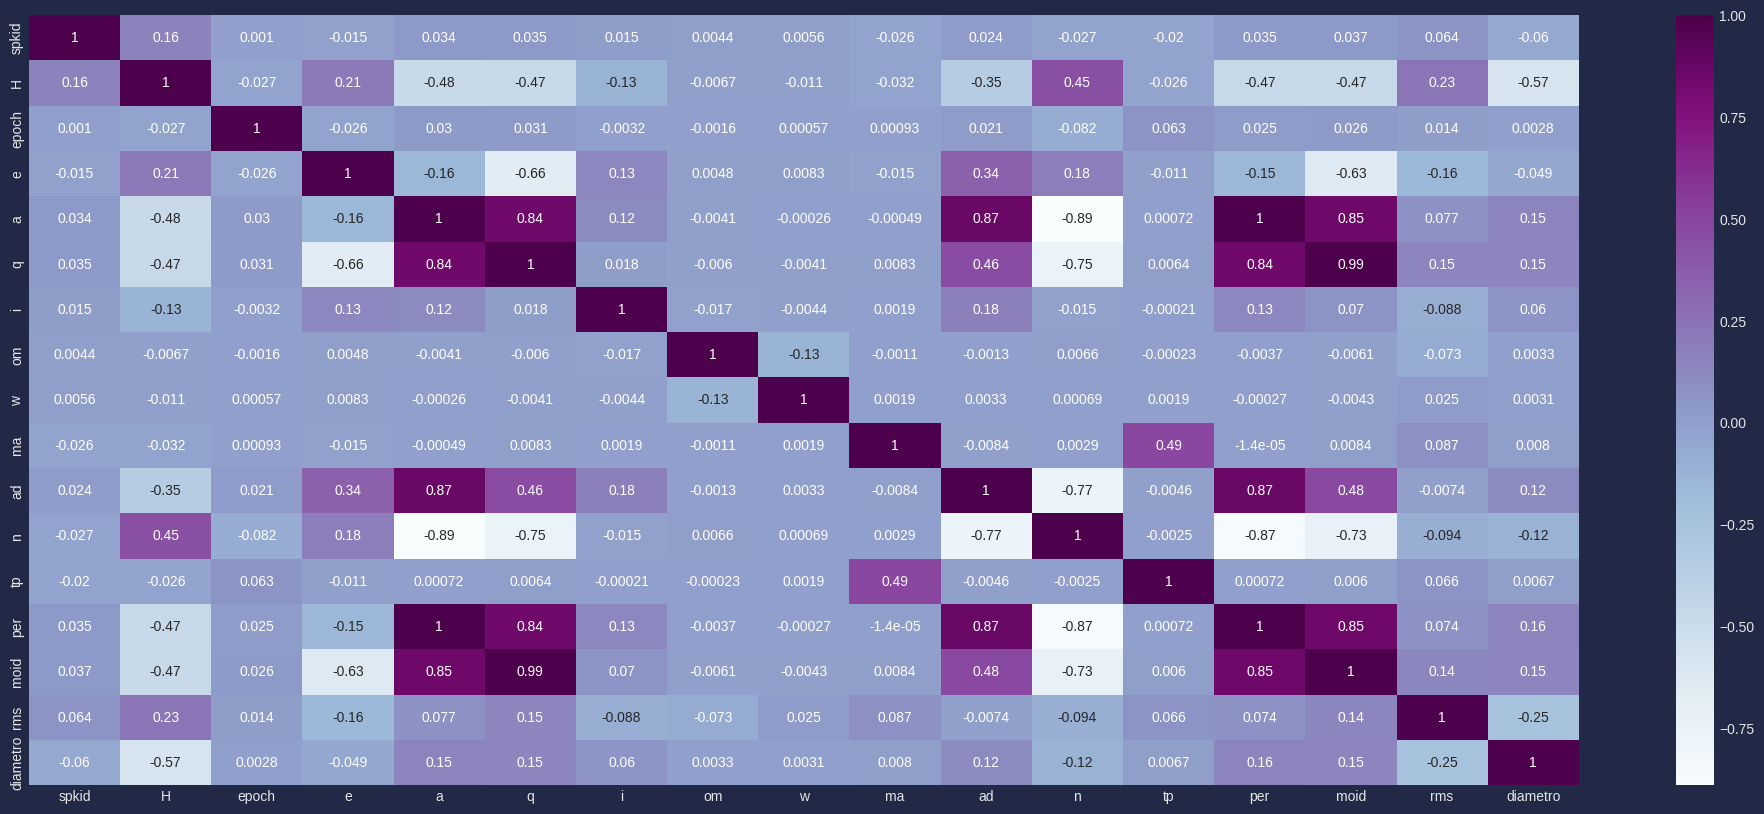

In [65]:
numerical_cols = df_asteroids.select_dtypes(["uint8", "float64"]).columns
categorical_cols = df_asteroids.select_dtypes(["object"]).columns

fig = plt.figure(figsize=(25, 10))
sns.heatmap(df_asteroids[numerical_cols].corr(), annot=True, cmap='BuPu', annot_kws={"size": 10});

## Detecting and handling multicollinearity between features

Multicollinearity occurs when the independent variables (predictors) in a regression model are correlated. Independent variables should be, well, independent.


In [66]:
def detect_VIF(df, corr_list):
    df_ = df.copy()
    df_['intercept'] = 1

    with np.errstate(divide='ignore'):
      while(True):
          df_vif = pd.DataFrame(columns=["Features", "VIF"])
          df_vif["Features"] = df_.columns
          df_vif["VIF"] = [variance_inflation_factor(df_.values.astype(np.float64), i) for i in range(len(df_.columns))]
          df_vif = df_vif[df_vif["Features"] != "intercept"].sort_values("VIF", ascending=False)

          if df_vif.iloc[0]["VIF"] > 10:
              vif_list = df_vif.loc[df_vif["VIF"] == df_vif["VIF"].max(), "Features"].values.tolist()
              for corr in corr_list:
                if corr in vif_list:
                  df_.drop([corr], axis=1, inplace=True)
                  break
              corr_list.remove(corr)
          else:
              break

      df_.drop(["intercept"], axis=1, inplace=True)
    return df[df_.columns.tolist()], df_vif

corr_list = df_asteroids[numerical_cols].corr().index.tolist()
df_asteroids_select, df_vif = detect_VIF(df_asteroids[numerical_cols], corr_list)
numeric_cols = df_asteroids_select.columns
df_vif

Features       VIF
10      moid  5.448662
8          n  3.333921
3          e  2.574054
1          H  2.258365
12  diametro  1.572130
7         ma  1.331994
9         tp  1.330022
11       rms  1.202403
4          i  1.130980
0      spkid  1.054008
5         om  1.024466
2      epoch  1.020487
6          w  1.019469

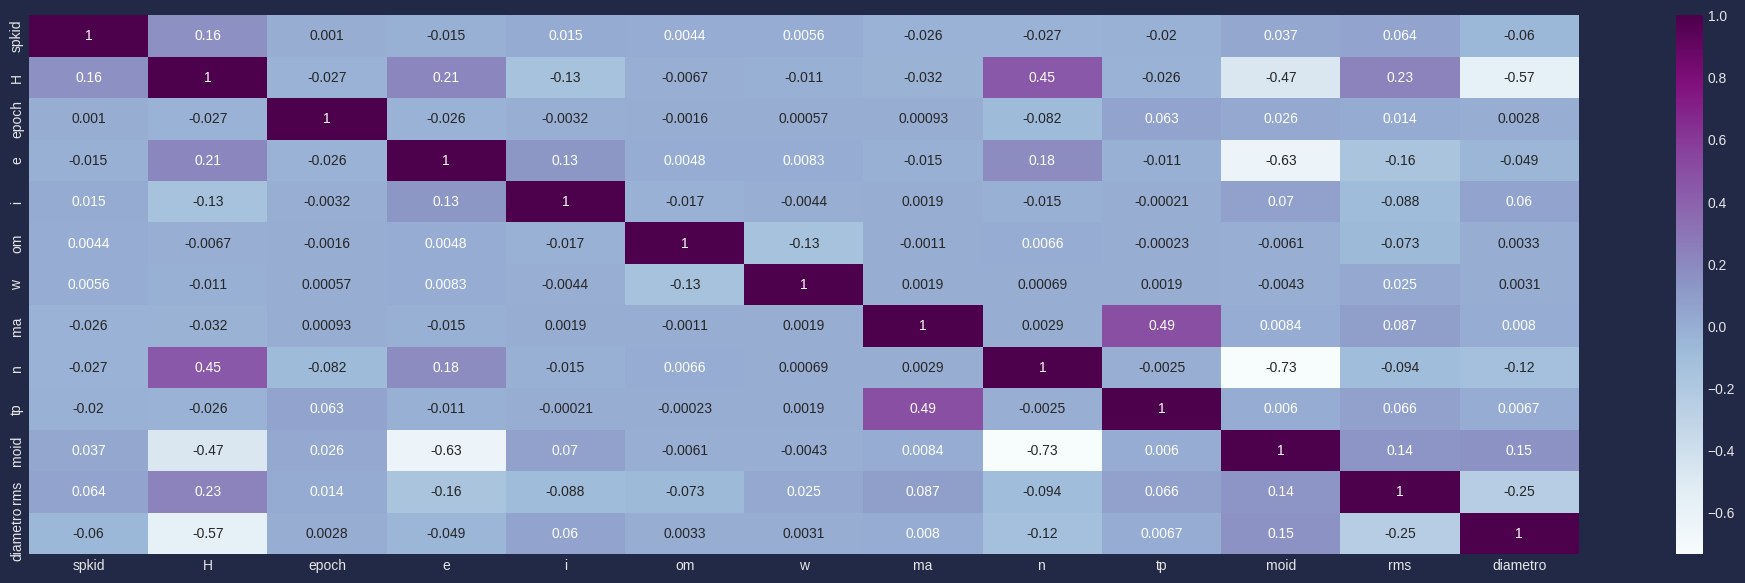

In [67]:
fig = plt.figure(figsize=(25, 7))
sns.heatmap(df_asteroids_select.corr(), annot=True, cmap='BuPu', annot_kws={"size": 10});

# Separating features from the label


In [68]:
df_asteroids_ = df_asteroids[list(numerical_cols) + list(categorical_cols)]
X = df_asteroids_.drop(["pha"], axis=1)
y = df_asteroids_["pha"]
y.value_counts()

pha
N    759263
Y      1737
Name: count, dtype: int64

# Splitting into training, validation, and test datasets


In [69]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, stratify=y, random_state=seed_value)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.25, stratify=y_val, random_state=seed_value)
X_train.shape, X_val.shape, X_test.shape

((532700, 19), (171225, 19), (57075, 19))

In [70]:
y_train.value_counts()

pha
N    531484
Y      1216
Name: count, dtype: int64

# Encoding categorical features

In [71]:
numerical_cols = X_train.select_dtypes(["uint8", "float64"]).columns
categorical_cols = X_train.select_dtypes(["object"]).columns

## Encoding label


In [72]:
le = LabelEncoder()
y_train = le.fit_transform(y_train).astype("uint8")
y_val = le.transform(y_val).astype("uint8")
y_test = le.transform(y_test).astype("uint8")

## Encoding features

In [73]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore").set_output(transform='pandas')
ohe.fit_transform(X_train[categorical_cols]).head()

neo_N  neo_Y  class_AMO  class_APO  class_ATE  class_IEO  class_IMB  \
id                                                                              
a0509205    1.0    0.0        0.0        0.0        0.0        0.0        0.0   
a0400500    1.0    0.0        0.0        0.0        0.0        0.0        0.0   
a0476160    1.0    0.0        0.0        0.0        0.0        0.0        0.0   
a0059146    1.0    0.0        0.0        0.0        0.0        0.0        0.0   
a0133669    1.0    0.0        0.0        0.0        0.0        0.0        0.0   

          class_MBA  class_MCA  class_OMB  
id                                         
a0509205        1.0        0.0        0.0  
a0400500        1.0        0.0        0.0  
a0476160        1.0        0.0        0.0  
a0059146        1.0        0.0        0.0  
a0133669        1.0        0.0        0.0

# Standardization of features

In [74]:
std = StandardScaler().set_output(transform='pandas')
std.fit_transform(X_train[numerical_cols]).head()

spkid         H     epoch         e         a         q  \
id                                                                     
a0509205 -0.146100  0.965208  0.008119  0.069394 -1.003186 -0.812420   
a0400500 -0.164644 -0.483772  0.008119 -0.024884  1.193311  0.917679   
a0476160 -0.151738  0.321217  0.008119 -0.918697  0.640034  1.031563   
a0059146 -0.222875 -1.208262  0.008119  0.368049 -1.006616 -0.958934   
a0133669 -0.210162 -1.047264  0.008119 -0.190586  0.245718  0.285911   

                 i        om         w        ma        ad         n  \
id                                                                     
a0509205 -0.853758  0.738388 -0.456529  1.184853 -0.900631  0.775864   
a0400500  0.445587 -0.724754 -0.891911 -0.530556  1.115703 -0.908600   
a0476160  0.258119 -1.196759 -1.702581  0.261573  0.106955 -0.588581   
a0059146 -0.781785 -1.216319 -1.214081 -1.447369 -0.772742  0.779618   
a0133669  0.066424  0.096950 -0.799781  1.464862  0.141400 -0.325597   

                tp       per      moid       rms  diametro  
id                                                          
a0509205  0.481405 -1.005674 -0.858110  1.579150 -0.307430  
a0400500 -1.400808  1.209842  0.986931 -0.359234 -0.080692  
a0476160  1.683042  0.622265  1.040625  0.354265 -0.249290  
a0059146 -0.174740 -1.008879 -0.965431 -1.553544  0.280896  
a0133669  0.329015  0.215311  0.266661  0.207714  0.172939

#Pipeline for data preprocessing

In [75]:
from sklearn.compose import make_column_transformer

column_transformer = make_column_transformer(
    # Numerical columns
    (
        StandardScaler().set_output(transform='pandas'),
        numerical_cols
    ),
    # Categorical columns
    (
        OneHotEncoder(sparse_output=False, handle_unknown='ignore').set_output(transform='pandas'),
        categorical_cols
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

X_train = column_transformer.fit_transform(X_train)
X_val = column_transformer.transform(X_val)
X_test = column_transformer.transform(X_test)
X_train.head()

spkid         H     epoch         e         a         q  \
id                                                                     
a0509205 -0.146100  0.965208  0.008119  0.069394 -1.003186 -0.812420   
a0400500 -0.164644 -0.483772  0.008119 -0.024884  1.193311  0.917679   
a0476160 -0.151738  0.321217  0.008119 -0.918697  0.640034  1.031563   
a0059146 -0.222875 -1.208262  0.008119  0.368049 -1.006616 -0.958934   
a0133669 -0.210162 -1.047264  0.008119 -0.190586  0.245718  0.285911   

                 i        om         w        ma        ad         n  \
id                                                                     
a0509205 -0.853758  0.738388 -0.456529  1.184853 -0.900631  0.775864   
a0400500  0.445587 -0.724754 -0.891911 -0.530556  1.115703 -0.908600   
a0476160  0.258119 -1.196759 -1.702581  0.261573  0.106955 -0.588581   
a0059146 -0.781785 -1.216319 -1.214081 -1.447369 -0.772742  0.779618   
a0133669  0.066424  0.096950 -0.799781  1.464862  0.141400 -0.325597   

                tp       per      moid       rms  diametro  neo_N  neo_Y  \
id                                                                         
a0509205  0.481405 -1.005674 -0.858110  1.579150 -0.307430    1.0    0.0   
a0400500 -1.400808  1.209842  0.986931 -0.359234 -0.080692    1.0    0.0   
a0476160  1.683042  0.622265  1.040625  0.354265 -0.249290    1.0    0.0   
a0059146 -0.174740 -1.008879 -0.965431 -1.553544  0.280896    1.0    0.0   
a0133669  0.329015  0.215311  0.266661  0.207714  0.172939    1.0    0.0   

          class_AMO  class_APO  class_ATE  class_IEO  class_IMB  class_MBA  \
id                                                                           
a0509205        0.0        0.0        0.0        0.0        0.0        1.0   
a0400500        0.0        0.0        0.0        0.0        0.0        1.0   
a0476160        0.0        0.0        0.0        0.0        0.0        1.0   
a0059146        0.0        0.0        0.0        0.0        0.0        1.0   
a0133669        0.0        0.0        0.0        0.0        0.0        1.0   

          class_MCA  class_OMB  
id                              
a0509205        0.0        0.0  
a0400500        0.0        0.0  
a0476160        0.0        0.0  
a0059146        0.0        0.0  
a0133669        0.0        0.0

# Handling imbalanced data


## Oversampling of the minority class


In [76]:
oversample = SMOTE(sampling_strategy=0.25, random_state=seed_value, k_neighbors=5)
X_train, y_train = oversample.fit_resample(X_train, y_train)
np.unique(y_train, return_counts=True)

(array([0, 1], dtype=uint8), array([531484, 132871]))

## Undersampling of the majority class


In [77]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(random_state=42)
X_train, y_train = undersample.fit_resample(X_train, y_train)
np.unique(y_train, return_counts=True)

(array([0, 1], dtype=uint8), array([132871, 132871]))

# Feature selection

In [80]:
sfs_forward = SequentialFeatureSelector(estimator=LogisticRegression(n_jobs=-1),
                                        n_features_to_select=12,
                                        direction="forward",
                                        scoring='roc_auc',
                                        cv=5,
                                        n_jobs=-1,
                                       ).set_output(transform='pandas')

sfs_forward.fit(X_train, y_train)

selected_features = sfs_forward.get_feature_names_out()
selected_features

array(['H', 'epoch', 'i', 'ma', 'moid', 'diametro', 'neo_Y', 'class_ATE',
       'class_IEO', 'class_IMB', 'class_MBA', 'class_MCA'], dtype=object)

In [81]:
X_train = sfs_forward.transform(X_train)
X_val = sfs_forward.transform(X_val)
X_test = sfs_forward.transform(X_test)

# Save the training, validation, and testing sets for future use


In [82]:
train = X_train.copy()
test = X_test.copy()
val = X_val.copy()

train["pha"] = y_train
test["pha"] = y_test
val["pha"] = y_val

train.to_csv(dest_path+'train.csv', index=True, index_label="id")
test.to_csv(dest_path+'test.csv', index=True, index_label="id")
val.to_csv(dest_path+'val.csv', index=True, index_label="id")

# Recovering training, validation, and testing sets

This approach establishes a new starting point, so we don't need to run the entire notebook from scratch again.

In [83]:
train = pd.read_csv(dest_path+'train.csv', engine='c', low_memory=False, index_col="id")
test = pd.read_csv(dest_path+'test.csv', engine='c', low_memory=False, index_col="id")
val = pd.read_csv(dest_path+'val.csv', engine='c', low_memory=False, index_col="id")

X_train, y_train = train.drop(["pha"], axis=1), train["pha"]
X_test, y_test = test.drop(["pha"], axis=1), test["pha"]
X_val, y_val = val.drop(["pha"], axis=1), val["pha"]

In [84]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 265742 entries, 520093 to 664354
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   H          265742 non-null  float64
 1   epoch      265742 non-null  float64
 2   i          265742 non-null  float64
 3   ma         265742 non-null  float64
 4   moid       265742 non-null  float64
 5   diametro   265742 non-null  float64
 6   neo_Y      265742 non-null  float64
 7   class_ATE  265742 non-null  float64
 8   class_IEO  265742 non-null  float64
 9   class_IMB  265742 non-null  float64
 10  class_MBA  265742 non-null  float64
 11  class_MCA  265742 non-null  float64
dtypes: float64(12)
memory usage: 26.4 MB


# Model training

When choosing and training a model, we have several tools available to evaluate its performance. One of these tools is the **confusion matrix**, which explicitly shows when one class is confused with another. This allows us to work separately with different types of errors. The confusion matrix looks like this:

<table>
    <tr>
        <th colspan="2" rowspan="2"></th>
        <th colspan="2">Prediction</th>
    </tr>
    <tr>
        <td>Negative</td>
        <td>Positive</td>
    </tr>
    <tr>
        <th rowspan="2">Actual</th>
        <td>Negative</td>
        <td>TN</td>
        <td>FP</td>
    </tr>
    <tr>
        <td>Positive</td>
        <td>FN</td>
        <td>TP</td>
    </tr>
</table>

Where we can observe, for our case study:
+ **Negative case**: Harmless asteroid (**AI**)
+ **Positive case**: Potentially hazardous asteroid (**PHA**)
+ **TN**: The prediction says the asteroid is **AI** when it really is **AI**.
+ **TP**: The prediction says the asteroid is **PHA** when it really is **PHA**.
+ **FN**: The prediction says the asteroid is **AI** when it really is **PHA**.
+ **FP**: The prediction says the asteroid is **PHA** when it really is **AI**.

The worst case scenario is an **FN** prediction, as we would be determining that an asteroid is harmless when it is actually potentially hazardous, ignoring the possibility of an imminent collision in the near future. For this reason, we will aim to reduce this type of prediction.

However, we should not neglect the **FP** errors, as our model would become useless.

The metric that will help us analyze the number of **FN** predictions is known as ***Recall***, such that:

$Recall = \frac{TP}{TP + FN}\quad\text{if}\quad FN \rightarrow 0 \Longrightarrow Recall \rightarrow 1$

Additionally:

$Precision = \frac{TP}{TP + FP}\quad\text{if}\quad FP \rightarrow 0 \Longrightarrow Precision \rightarrow 1$

$F1 = \frac{TP}{TP + \frac{FN + FP}{2}}\quad\text{if}\quad FN, FP \rightarrow 0 \Longrightarrow F1 \rightarrow 1$


In [85]:
def get_best_estimator(estimator, params, X_val, y_val, cv=5):
    grid = GridSearchCV(estimator(), params, scoring=["f1", "recall"], refit="f1", cv=cv, verbose=1, n_jobs=-1)
    grid.fit(X_train, y_train)
    print(f"Best parameters: {grid.best_params_}")
    return grid.best_estimator_

## Logistic Regression

In [86]:
start = time.time()

lr = LogisticRegression().fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

end = time.time()
lr_time = end - start
print(f"Total training and prediction time: {lr_time} seconds")

Total training and prediction time: 1.3279826641082764 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [87]:
pd.DataFrame(data=classification_report(y_test, y_pred_lr, digits=6, output_dict=True)).transpose()

precision    recall  f1-score      support
0              1.000000  0.997735  0.998866  56945.00000
1              0.501931  1.000000  0.668380    130.00000
accuracy       0.997740  0.997740  0.997740      0.99774
macro avg      0.750965  0.998867  0.833623  57075.00000
weighted avg   0.998866  0.997740  0.998113  57075.00000

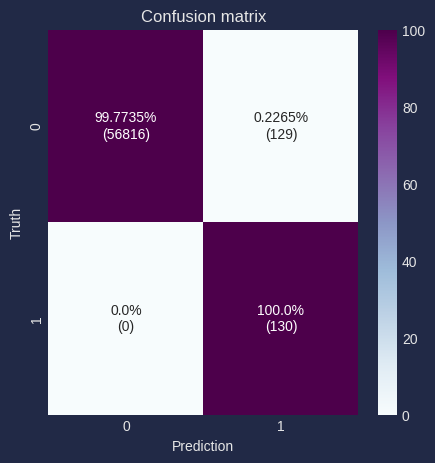

In [88]:
fig = plt.figure(figsize=(5, 5))

cm_val = confusion_matrix(y_test, y_pred_lr)
cm_pgs = np.round(confusion_matrix(y_test, y_pred_lr, normalize='true')*100, 4)

formatted_text = (np.asarray([f"{pgs}%\n({val})" for val, pgs in zip(cm_val.flatten(), cm_pgs.flatten())])).reshape(2, 2)

sns.heatmap(cm_pgs, annot=formatted_text, fmt='', cmap='BuPu')
plt.title("Confusion matrix")
plt.xlabel("Prediction")
plt.ylabel("Truth");

In [89]:
scores = cross_val_score(lr, X_test, y_test, cv=5)
print(f"Mean accuracy: {scores.mean()}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/

Mean accuracy: 0.9989487516425756


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



## Logistic Regression with hyperparameter tuning



In [90]:
start = time.time()

params = {"penalty": ["l2"],
          "C": [300, 400, 500],
          "solver": ["lbfgs", "liblinear"],
          "max_iter": [75, 100, 125],
          "random_state":[42]
          }

lr_best = get_best_estimator(LogisticRegression, params, X_val, y_val)
lr_best.fit(X_train, y_train)
y_pred_lr_best = lr_best.predict(X_test)

end = time.time()
lr_best_time = end - start
print(f"Total training and prediction time: {lr_best_time} seconds")

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Best parameters: {'C': 300, 'max_iter': 125, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs'}
Total training and prediction time: 52.973488569259644 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [91]:
pd.DataFrame(data=classification_report(y_test, y_pred_lr_best, digits=6, output_dict=True)).transpose()

precision    recall  f1-score       support
0              1.000000  0.999017  0.999508  56945.000000
1              0.698925  1.000000  0.822785    130.000000
accuracy       0.999019  0.999019  0.999019      0.999019
macro avg      0.849462  0.999508  0.911146  57075.000000
weighted avg   0.999314  0.999019  0.999106  57075.000000

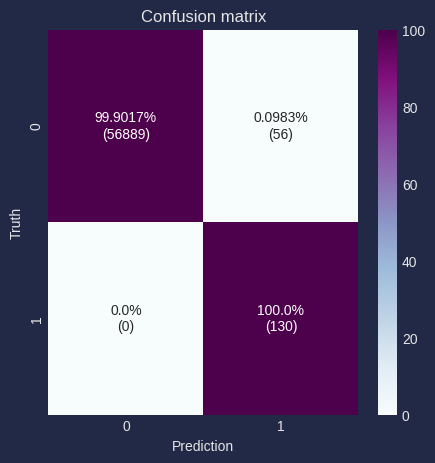

In [92]:
fig = plt.figure(figsize=(5, 5))

cm_val = confusion_matrix(y_test, y_pred_lr_best)
cm_pgs = np.round(confusion_matrix(y_test, y_pred_lr_best, normalize='true')*100, 4)

formatted_text = (np.asarray([f"{pgs}%\n({val})" for val, pgs in zip(cm_val.flatten(), cm_pgs.flatten())])).reshape(2, 2)

sns.heatmap(cm_pgs, annot=formatted_text, fmt='', cmap='BuPu')
plt.title("Confusion matrix")
plt.xlabel("Prediction")
plt.ylabel("Truth");

In [93]:
scores = cross_val_score(lr_best, X_test, y_test, cv=5)
print(f"Mean accuracy: {scores.mean()}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/

Mean accuracy: 0.9993342093736312


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



## K-Nearest Neighbors

In [94]:
start = time.time()

knn = KNeighborsClassifier(n_neighbors=3, leaf_size=50).fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

end = time.time()
knn_time = end - start
print(f"Total training and prediction time: {knn_time} seconds")

Total training and prediction time: 11.16469120979309 seconds


In [95]:
pd.DataFrame(data=classification_report(y_test, y_pred_knn, digits=6, output_dict=True)).transpose()

precision    recall  f1-score       support
0              1.000000  0.995926  0.997959  56945.000000
1              0.359116  1.000000  0.528455    130.000000
accuracy       0.995935  0.995935  0.995935      0.995935
macro avg      0.679558  0.997963  0.763207  57075.000000
weighted avg   0.998540  0.995935  0.996889  57075.000000

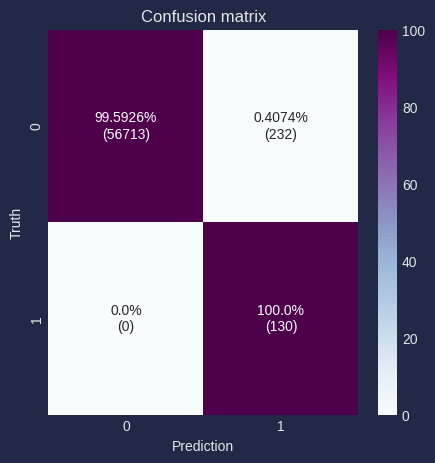

In [96]:
fig = plt.figure(figsize=(5, 5))

cm_val = confusion_matrix(y_test, y_pred_knn)
cm_pgs = np.round(confusion_matrix(y_test, y_pred_knn, normalize='true')*100, 4)

formatted_text = (np.asarray([f"{pgs}%\n({val})" for val, pgs in zip(cm_val.flatten(), cm_pgs.flatten())])).reshape(2, 2)

sns.heatmap(cm_pgs, annot=formatted_text, fmt='', cmap='BuPu')
plt.title("Confusion matrix")
plt.xlabel("Prediction")
plt.ylabel("Truth");

In [97]:
scores = cross_val_score(knn, X_test, y_test, cv=5)
print(f"Mean accuracy: {scores.mean()}")

Mean accuracy: 0.9978098992553658


## Random Forest

In [98]:
start = time.time()

rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42).fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

end = time.time()
rf_time = end - start
print(f"Total training and prediction time: {rf_time} seconds")

Total training and prediction time: 47.18878173828125 seconds


In [99]:
pd.DataFrame(data=classification_report(y_test, y_pred_rf, digits=6, output_dict=True)).transpose()

precision    recall  f1-score       support
0              1.000000  0.999824  0.999912  56945.000000
1              0.928571  1.000000  0.962963    130.000000
accuracy       0.999825  0.999825  0.999825      0.999825
macro avg      0.964286  0.999912  0.981438  57075.000000
weighted avg   0.999837  0.999825  0.999828  57075.000000

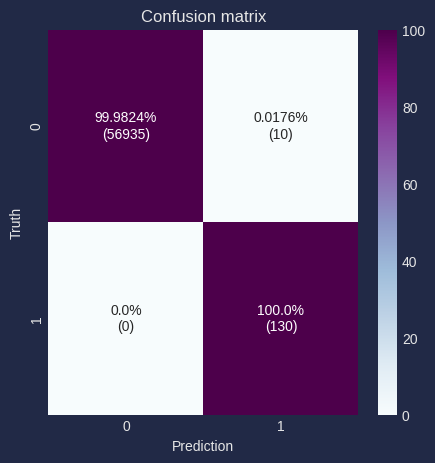

In [100]:
fig = plt.figure(figsize=(5, 5))

cm_val = confusion_matrix(y_test, y_pred_rf)
cm_pgs = np.round(confusion_matrix(y_test, y_pred_rf, normalize='true')*100, 4)

formatted_text = (np.asarray([f"{pgs}%\n({val})" for val, pgs in zip(cm_val.flatten(), cm_pgs.flatten())])).reshape(2, 2)

sns.heatmap(cm_pgs, annot=formatted_text, fmt='', cmap='BuPu')
plt.title("Confusion matrix")
plt.xlabel("Prediction")
plt.ylabel("Truth");

In [101]:
scores = cross_val_score(rf, X_test, y_test, cv=5)
print(f"Mean accuracy: {scores.mean()}")

Mean accuracy: 0.9999123959702146


## Support Vector Machine

In [102]:
start = time.time()

svc = SVC(C=10, random_state=42).fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

end = time.time()
svc_time = end - start
print(f"Total training and prediction time: {svc_time} seconds")

Total training and prediction time: 40.31021690368652 seconds


In [103]:
pd.DataFrame(data=classification_report(y_test, y_pred_svc, digits=6, output_dict=True)).transpose()

precision    recall  f1-score       support
0              1.000000  0.998139  0.999068  56945.000000
1              0.550847  1.000000  0.710383    130.000000
accuracy       0.998143  0.998143  0.998143      0.998143
macro avg      0.775424  0.999069  0.854725  57075.000000
weighted avg   0.998977  0.998143  0.998411  57075.000000

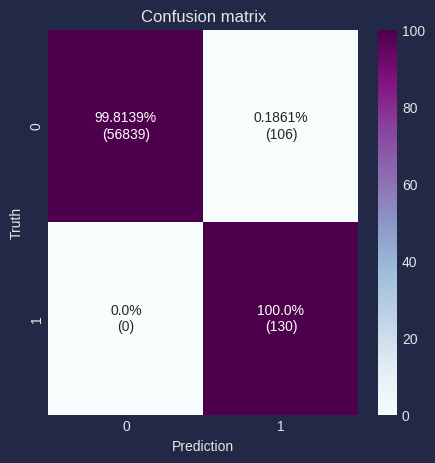

In [104]:
fig = plt.figure(figsize=(5, 5))

cm_val = confusion_matrix(y_test, y_pred_svc)
cm_pgs = np.round(confusion_matrix(y_test, y_pred_svc, normalize='true')*100, 4)

formatted_text = (np.asarray([f"{pgs}%\n({val})" for val, pgs in zip(cm_val.flatten(), cm_pgs.flatten())])).reshape(2, 2)

sns.heatmap(cm_pgs, annot=formatted_text, fmt='', cmap='BuPu')
plt.title("Confusion matrix")
plt.xlabel("Prediction")
plt.ylabel("Truth");

In [105]:
scores = cross_val_score(svc, X_test, y_test, cv=5)
print(f"Mean accuracy: {scores.mean()}")

Mean accuracy: 0.9991239597021464


# Comparing the models
## ROC and DET curves

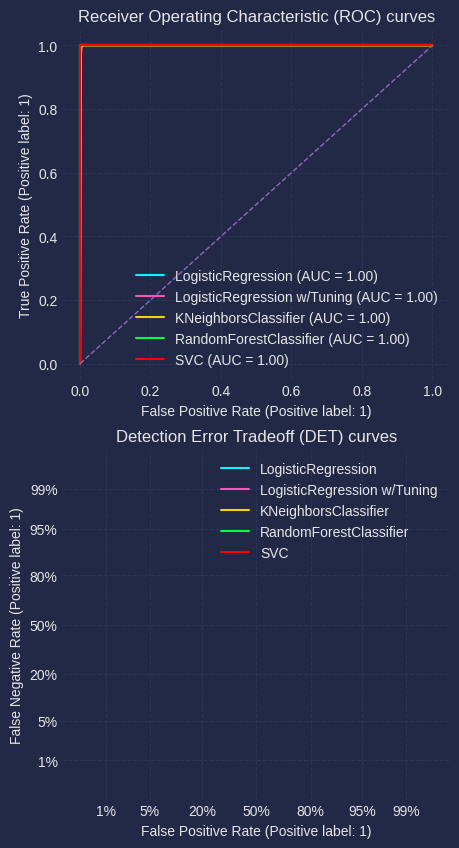

In [106]:
fig, [ax_roc, ax_det] = plt.subplots(2, 1, figsize=(5, 10))

RocCurveDisplay.from_estimator(lr, X_test, y_test, ax=ax_roc)
RocCurveDisplay.from_estimator(lr_best, X_test, y_test, ax=ax_roc, name="LogisticRegression w/Tuning")
RocCurveDisplay.from_estimator(knn, X_test, y_test, ax=ax_roc)
RocCurveDisplay.from_estimator(rf, X_test, y_test, ax=ax_roc)
RocCurveDisplay.from_estimator(svc, X_test, y_test, ax=ax_roc)
ax_roc.plot([0, 1], [0, 1], linestyle='--', lw=1)

DetCurveDisplay.from_estimator(lr, X_test, y_test, ax=ax_det)
DetCurveDisplay.from_estimator(lr_best, X_test, y_test, ax=ax_det, name="LogisticRegression w/Tuning")
DetCurveDisplay.from_estimator(knn, X_test, y_test, ax=ax_det)
DetCurveDisplay.from_estimator(rf, X_test, y_test, ax=ax_det)
DetCurveDisplay.from_estimator(svc, X_test, y_test, ax=ax_det)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()

## Comparison table for performance models

In [107]:
def print_scores(y, y_pred, pp_scores=False):
    ac, pr, rc, f1 = accuracy_score(y, y_pred)*100, precision_score(y, y_pred)*100, recall_score(y, y_pred)*100, f1_score(y, y_pred, average='weighted')*100
    if pp_scores == True:
        print(f"Accuracy:{ac}")
        print(f"Precision:{pr}")
        print(f"Recall:{rc}")
        print(f"F1-score:{f1}")
    return {'Accuracy': ac, 'Precision':pr, 'Recall':rc, 'F1-score':f1}

lr_scores = print_scores(y_test, y_pred_lr)
lr_best_scores = print_scores(y_test, y_pred_lr_best)
knn_scores = print_scores(y_test, y_pred_knn)
rf_scores = print_scores(y_test, y_pred_rf)
svc_scores = print_scores(y_test, y_pred_svc)

scores = pd.DataFrame(data=[list(lr_scores.values()),
                            list(lr_best_scores.values()),
                            list(knn_scores.values()),
                            list(rf_scores.values()),
                            list(svc_scores.values()),
                           ], columns=list(lr_scores.keys()))

scores = scores.transpose()
scores = scores.rename(columns={0:"Linear Regression",
                                1:"Linear Regression w/Tuning",
                                2:"K-Nearest Neighbors",
                                3:"Random Forest",
                                4:"C-Support Vector",
                               })
scores.style.highlight_max(color = 'green', axis = 1).highlight_min(color = 'red', axis = 1)

## Comparison table for training time consumption

In [108]:
times = pd.DataFrame(data={"Time taken (seconds)": [lr_time, lr_best_time, knn_time, rf_time, svc_time]}, index=["Logistic Regression", "Logistic Regression w/tuning", "K-Nearest Neighbors", "Random Forest", "C-Support Vector"])
times = times.sort_values(by=["Time taken (seconds)"])
times.style.highlight_min(color = 'green', axis = 0).highlight_max(color = 'red', axis = 0)

# Analizing the best model
## Learning curve

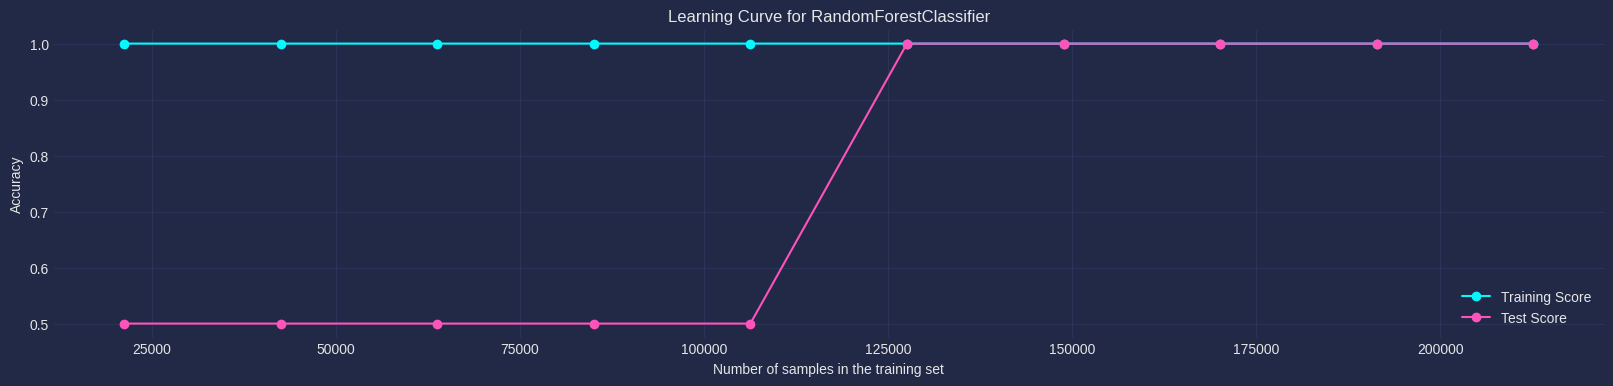

In [110]:
rf_lc = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=seed_value, n_jobs=-1)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))

common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(rf_lc, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {rf_lc.__class__.__name__}");

In [111]:
print(f"We have determined that the optimal performance is achieved when using {round(130000*100/len(X_train))}% to {round(150000*100/len(X_train))}% of the training set.")

We have determined that the optimal performance is achieved when using 49% to 56% of the training set.


## Random Forest trained with 50~60% of the dataset

In [112]:
X_train_min, _, y_train_min, _ = train_test_split(X_train, y_train, test_size=0.55, stratify=y_train, random_state=seed_value)
print(f"We will use {round(len(X_train_min)*100/len(X_train),2)}% ({len(X_train_min)}) of the data.")

We will use 45.0% (119583) of the data.


In [113]:
start = time.time()

rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=seed_value, n_jobs=-1).fit(X_train_min, y_train_min)
y_pred_rf = rf.predict(X_test)

end = time.time()
rf_time = end - start
print(f"Total training and prediction time: {rf_time} seconds")

Total training and prediction time: 19.219871997833252 seconds


In [114]:
pd.DataFrame(data=classification_report(y_test, y_pred_rf, digits=6, output_dict=True)).transpose()

precision    recall  f1-score       support
0              1.000000  0.999824  0.999912  56945.000000
1              0.928571  1.000000  0.962963    130.000000
accuracy       0.999825  0.999825  0.999825      0.999825
macro avg      0.964286  0.999912  0.981438  57075.000000
weighted avg   0.999837  0.999825  0.999828  57075.000000

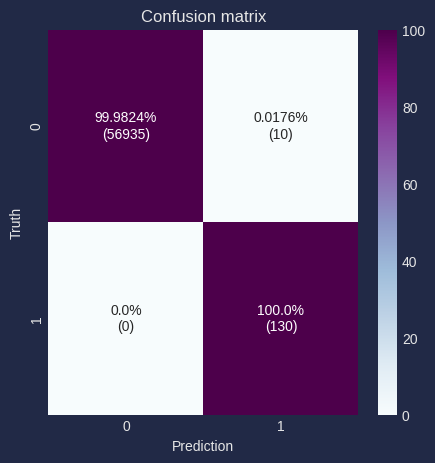

In [115]:
fig = plt.figure(figsize=(5, 5))

cm_val = confusion_matrix(y_test, y_pred_rf)
cm_pgs = np.round(confusion_matrix(y_test, y_pred_rf, normalize='true')*100, 4)

formatted_text = (np.asarray([f"{pgs}%\n({val})" for val, pgs in zip(cm_val.flatten(), cm_pgs.flatten())])).reshape(2, 2)

sns.heatmap(cm_pgs, annot=formatted_text, fmt='', cmap='BuPu')
plt.title("Confusion matrix")
plt.xlabel("Prediction")
plt.ylabel("Truth");

In [116]:
scores = cross_val_score(rf, X_test, y_test, cv=5)
print(f"Mean accuracy: {scores.mean()}")

Mean accuracy: 0.9999123959702146


## Important features for our model

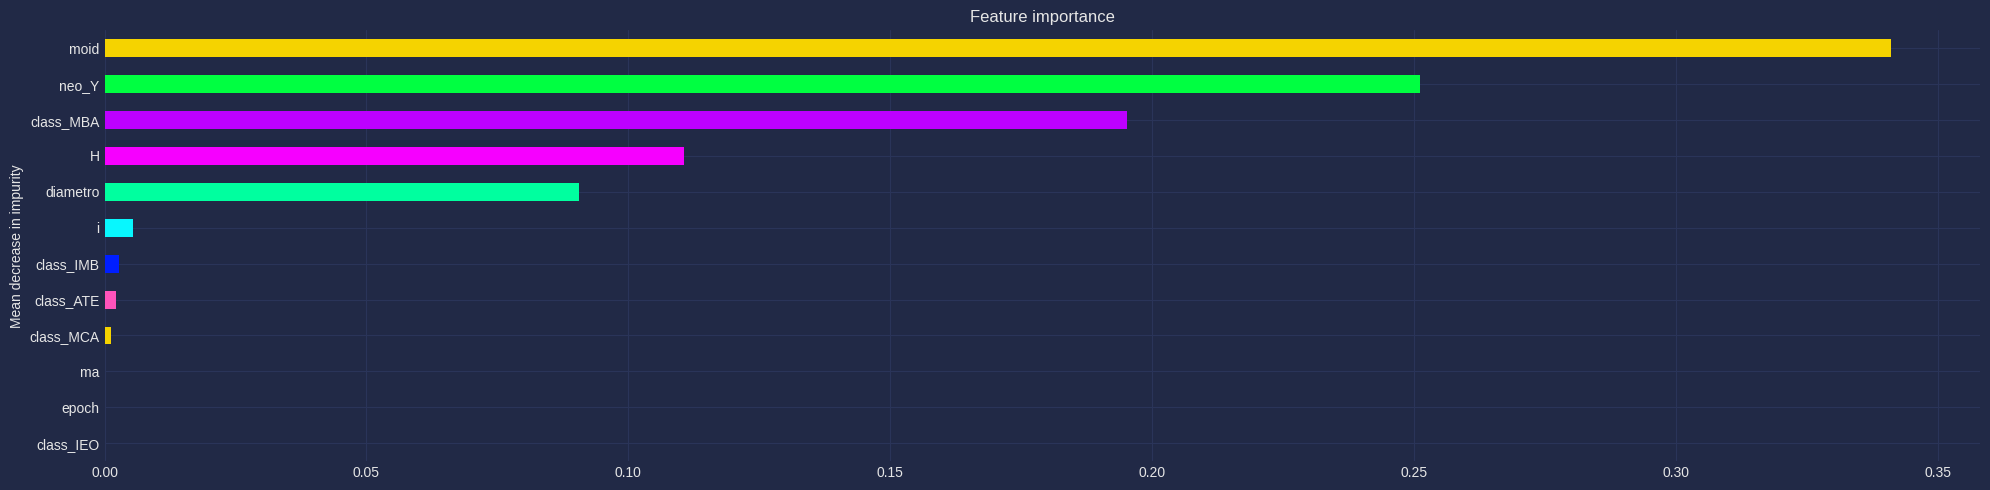

In [117]:
forest_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
colors = [
    "#00ff9f",
    '#08F7FE',  # teal/cyan
    "#001eff",
    '#FE53BB',  # pink
    '#F5D300',  # yellow
    '#00ff41',  # matrix green
    "#bd00ff",
    "#F600ff"
]
fig, ax = plt.subplots(figsize=(20, 5))
forest_importances.sort_values().plot.barh(color=list(reversed(colors)), ax=ax)
ax.set_title("Feature importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### SHAP Values

In [118]:
import shap

shap.initjs()

In [119]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer(X_train, y_train)

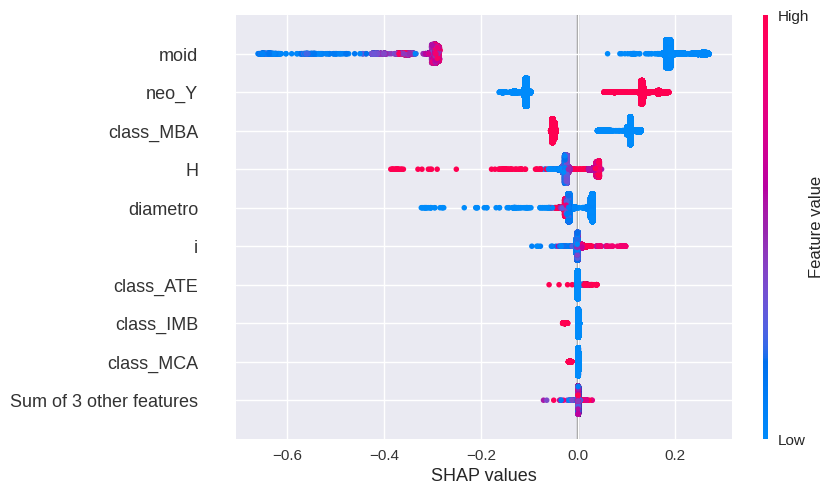

In [120]:
plt.style.use("seaborn-v0_8")
shap.plots.beeswarm(shap_values[:,:,1], show=False)
plt.xlabel(f"SHAP values")
plt.show()

According to the diagram presented above, when a point (an instance) is blue, it indicates that its original feature value in the dataset is low, whereas when a point is red, it indicates that the original feature value in the dataset is high.

With this clarified, four situations can arise:

+ Red point scattered towards negative SHAP values: For this instance, the feature indicates that the higher its value, the lower the prediction value, as it requires the SHAP value contribution to the prediction to be smaller.
+ Red point scattered towards positive SHAP values: On the contrary, for this instance, the feature indicates that the higher its value, the higher the prediction value, as it requires the SHAP value contribution to the prediction to be larger.
+ Blue point scattered towards negative SHAP values: For this instance, the feature indicates that the lower its value, the lower the prediction value, as it requires the SHAP value contribution to the prediction to be smaller.
+ Blue point scattered towards positive SHAP values: For this instance, the feature indicates that the lower its value, the higher the prediction value, as it requires the SHAP value contribution to the prediction to be larger.

In this way, we can conclude that, for example, an asteroid with a low `moid` value is more likely to be classified as a PHA asteroid.

# Saving the pipeline, the label encoder, the feature selector and the best model with CloudPickle

In [121]:
import cloudpickle

with open(dest_path+'HAP_model.bin', 'wb') as f_out:
    cloudpickle.dump((column_transformer, le, sfs_forward, rf), f_out)

# Conclusions

Based on the previously presented information, we can observe some important aspects. The balance of the data is a critical process for this project due to the significant imbalance in the data. This imbalance will cause a bias in the predictions of the estimators, leaning toward the majority class. If we perform oversampling, it is also important to perform undersampling to avoid artificially inflating our minority class excessively.

Feature selection is extremely helpful in reducing the volume of information that the estimators must analyze, significantly reducing training and prediction times. This selection also helps reduce the noise injected into the estimators by omitting non-redundant features in the prediction.

Regarding the performance of the estimators, several types of estimators were applied, most of which demonstrated excellent performance. However, the estimator that achieved the best results was the Random Forest estimator. Despite this, the time required for its training and prediction was the slowest, which may need to be considered for certain applications that require minimal processing speeds.

The most relevant feature according to our estimator is `moid`. As we have already seen, this feature indicates the maximum proximity of asteroids to Earth's orbit. We assumed this factor to be important based on the visual and statistical analysis we performed, and the estimator confirms our hypothesis. This does not mean that it is the most important feature overall, but the estimator determines that it is the most useful for classification. This could vary for other estimators.

Finally, we can observe that to achieve the best performance, only about 50~60% of the training set is necessary. Using a larger sample size could lead to overfitting in our estimators.

#### Thank you for your time! 😃